In [5]:
import time
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from keras import Input, Model
from keras.callbacks import TensorBoard
from keras.layers import Conv2D, BatchNormalization, Activation, Add, Conv2DTranspose, ZeroPadding2D, LeakyReLU
from keras_contrib.layers import InstanceNormalization
from keras.optimizers import Adam

from PIL import Image

from scipy.misc import imread, imresize


Using TensorFlow backend.


## 1. Create Generator

Define Residual Block function (for adding later to Generator):

In [18]:
def residual_block(x):
    
    result = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = "same")(x)
    result = BatchNormalization(axis = 3, momentum = 0.85, epsilon = 1e-5)(result)
    result = Activation('relu')(result)

    result = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = "same")(result)
    result = BatchNormalization(axis = 3, momentum = 0.85, epsilon = 1e-5)(result)

    return Add()([result, x])

Define Convolution Block

In [19]:
def convolution_block(filters, kernel_size, strides, normalization, activation, transpose, x):
    if transpose == True:
        result = Conv2DTranspose(filters = filters, kernel_size = kernel_size, strides = strides, padding = 'same', use_bias = False)(x)
    else:
        result = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = "same")(x)
    
    if normalization == True:
        result = InstanceNormalization(axis = 1)(result)
        
    result = Activation(activation)(result)
        
    return result

Define Generator function:

In [20]:
def build_generator():
       
    input_layer = Input(shape = (256, 256, 3))

    ## Add Convolution blocks
    x = convolution_block(filters = 32, kernel_size = 7, strides = 1, normalization = True, activation = "relu", transpose = False, x = input_layer)
    x = convolution_block(filters = 64, kernel_size = 3, strides = 2, normalization = True, activation = "relu", transpose = False, x = x)
    x = convolution_block(filters = 128, kernel_size = 3, strides = 2, normalization = True, activation = "relu", transpose = False, x = x)
    
    # Add Residual blocks
    for i in range(6):
        x = residual_block(x)
        
    ## Add Upsampling blocks
    x = convolution_block(filters = 64, kernel_size = 3, strides = 2, normalization = True, activation = "relu", transpose = True, x = x)
    x = convolution_block(filters = 64, kernel_size = 3, strides = 2, normalization = True, activation = "relu", transpose = True, x = x)

    # Add Convolution layer
    output = convolution_block(filters = 3, kernel_size = 7, strides = 1, normalization = False, activation = "tanh", transpose = False, x = x)

    model = Model(inputs = [input_layer], outputs = [output])
    return model

## 2. Create Discriminator

Define discriminator function:

In [21]:
def build_discriminator():
    
    input_layer = Input(shape = (256, 256, 3))

    x = ZeroPadding2D(padding = (1, 1))(input_layer)

    # Add Convolutional block
    x = Conv2D(filters = 64, kernel_size = 4, strides = 2, padding = "valid")(x)
    x = LeakyReLU(alpha = 0.25)(x)
    x = ZeroPadding2D(padding = (1, 1))(x)

    # Add 3 Convolution blocks
    for i in range(1, 4):
        x = Conv2D(filters = 2 ** i * 64, kernel_size = 4, strides = 2, padding = "valid")(x)
        x = InstanceNormalization(axis = 1)(x)
        x = LeakyReLU(alpha = 0.25)(x)

        x = ZeroPadding2D(padding = (1, 1))(x)

    # Add Convolution block
    output = Conv2D(filters = 1, kernel_size = 4, strides = 1, activation = "sigmoid")(x)

    model = Model(inputs = [input_layer], outputs = [output])
    
    return model

## 3. Load images

In [22]:
def load_images(folder):
    
    # Get data
    images_A = glob(folder + '/trainA/*.*')
    images_B = glob(folder + '/trainB/*.*')
    
    resized_images_A = []
    resized_images_B = []

    # Get pairs (equal count)
    for i, image in enumerate(images_A):
        image_A = imread(image, mode = "RGB")
        image_B = imread(images_B[i], mode = "RGB")

        image_A = imresize(image_A, (256, 256))
        image_B = imresize(image_B, (256, 256))

        resized_images_A.append(image_A)
        resized_images_B.append(image_B)

    # Normalize images
    resized_images_A = np.array(resized_images_A) / 127.5 - 1.
    resized_images_B = np.array(resized_images_B) / 127.5 - 1.

    return resized_images_A, resized_images_B

## Load several images for testing

In [24]:
def load_test_images(folder):
    images = glob(folder + '/input/*.*')
    images = images[0:6]

    resized_images = []

    for i in range(len(images)):
        # Load images and resize images
        resized_image = imresize(imread(images[i], mode = "RGB").astype(np.float32), (256, 256))
        resized_images.append(resized_image)

    return np.array(resized_images) / 127.5 - 1.0

## Save Images Function

In [25]:
def save_images(generated, path):
    
    figure = plt.figure()

    grid = figure.add_subplot(1, 1, 1)
    grid.imshow(generated)
    grid.axis("off")

    plt.savefig(path)

## Train network

In [ ]:
# Set parameters and hyperparameters
# folder = "../data/monet2photo/"
folder = "../data/vangogh2photo/"
epochs = 50
batch_size = 1

input_shape = (256, 256, 3)

# Load images
images_A, images_B = load_images(folder = folder)

# Build discriminators
discriminatorA = build_discriminator()
discriminatorB = build_discriminator()

discriminatorA.compile(loss = 'mse', optimizer = "adam", metrics = ['accuracy'])
discriminatorB.compile(loss = 'mse', optimizer = "adam", metrics = ['accuracy'])

# Build generators
generatorAToB = build_generator()
generatorBToA = build_generator()

In [ ]:
inputA = Input(shape = input_shape)
inputB = Input(shape = input_shape)

# Generated images
generatedB = generatorAToB(inputA)
generatedA = generatorBToA(inputB)

# Regenerate to original images
backA = generatorBToA(generatedB)
backB = generatorAToB(generatedA)

generatedA2 = generatorBToA(inputA)
generatedB2 = generatorAToB(inputB)

# Freeze discriminators
discriminatorA.trainable = False
discriminatorB.trainable = False

# Get probabilities (evaluation) from discriminators
probabilitiesA = discriminatorA(generatedA)
probabilitiesB = discriminatorB(generatedB)

model = Model(inputs = [inputA, inputB], outputs = [probabilitiesA, probabilitiesB, backA, backB, generatedA2, generatedB2])
model.compile(loss = ['mse', 'mse', 'mae', 'mae', 'mae', 'mae'], loss_weights = [1, 1, 10.0, 10.0, 1.0, 1.0], optimizer = "adam")

labels_real = np.ones((batch_size, 15, 15, 1))
labels_gen = np.zeros((batch_size, 15, 15, 1))

D:\Anaconda\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':
D:\Anaconda\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
D:\Anaconda\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app
D:\Anaconda\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` in

Epoch:0
400
Number of batches:400
Batch:0


D:\Anaconda\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
D:\Anaconda\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


d_loss:[0.6002009  0.30444443]
g_loss:[13.062423, 1.7612692e-08, 6.828614e-05, 0.52959603, 0.6584147, 0.5211545, 0.66109174]
Batch:1
d_loss:[0.49937963 0.5       ]


D:\Anaconda\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


g_loss:[14.559347, 1.9553574e-09, 9.446002e-05, 0.5859231, 0.7376971, 0.57937187, 0.74367875]
Batch:2
d_loss:[0.4888299 0.5      ]
g_loss:[12.03639, 2.9281397e-09, 0.9653197, 0.45324114, 0.5541977, 0.45370182, 0.54297876]
Batch:3
d_loss:[0.28566974 0.7       ]
g_loss:[11.422416, 4.59308e-09, 0.9979609, 0.472862, 0.47379252, 0.46903118, 0.488878]
Batch:4
d_loss:[0.25378212 0.74666667]
g_loss:[13.038168, 2.3682676e-07, 0.97706175, 0.53308535, 0.5608611, 0.5264646, 0.59517664]
Batch:5
d_loss:[0.25000146 0.75      ]
g_loss:[9.778132, 6.2426406e-09, 0.93028563, 0.42176175, 0.38179398, 0.42917663, 0.3831132]
Batch:6
d_loss:[0.35650277 0.63111115]
g_loss:[8.628446, 2.809048e-07, 0.9531197, 0.34943593, 0.34640276, 0.36585206, 0.35108632]
Batch:7
d_loss:[0.44164094 0.5466667 ]
g_loss:[9.893068, 1.0447898e-07, 0.9461475, 0.32423726, 0.48685315, 0.34000742, 0.49600857]
Batch:8
d_loss:[0.498623   0.48333335]
g_loss:[9.384118, 7.1666074e-07, 0.603075, 0.39557287, 0.39894223, 0.38721132, 0.44867983]

g_loss:[6.660209, 0.25361732, 0.28283462, 0.32119548, 0.2370645, 0.31817684, 0.2229805]
Batch:66
d_loss:[0.27152348 0.34333333]
g_loss:[6.215821, 0.28483754, 0.30562168, 0.31794086, 0.19405466, 0.3221547, 0.183252]
Batch:67
d_loss:[0.2877702  0.24555555]
g_loss:[7.2106967, 0.28980756, 0.31116727, 0.3291748, 0.27449888, 0.30224675, 0.27073878]
Batch:68
d_loss:[0.26866817 0.4488889 ]
g_loss:[9.588758, 0.30635437, 0.3090286, 0.2587786, 0.5754082, 0.24738257, 0.3841262]
Batch:69
d_loss:[0.29887372 0.3077778 ]
g_loss:[9.914217, 0.28783512, 0.2939277, 0.27379492, 0.60402083, 0.27313644, 0.2811601]
Batch:70
d_loss:[0.29867384 0.20555556]
g_loss:[9.341264, 0.26120973, 0.27940464, 0.36779344, 0.43179497, 0.38082522, 0.42393935]
Batch:71
d_loss:[0.27043766 0.39111114]
g_loss:[7.1721888, 0.25379106, 0.28973073, 0.29536936, 0.30658495, 0.31547233, 0.29365212]
Batch:72
d_loss:[0.27892712 0.30444443]
g_loss:[6.772393, 0.28033823, 0.29593444, 0.30242175, 0.26270983, 0.2935217, 0.2512828]
Batch:73
d_l

g_loss:[6.2758427, 0.37424922, 0.3272533, 0.3362223, 0.17857258, 0.25943667, 0.16695501]
Batch:130
d_loss:[0.38085878 0.43555558]
g_loss:[7.399214, 0.5082507, 0.22259325, 0.2686131, 0.33795863, 0.26313114, 0.33952165]
Batch:131
d_loss:[0.1956566 0.6677778]
g_loss:[6.6151576, 0.4929855, 0.28722218, 0.24471353, 0.28796983, 0.23268233, 0.2754342]
Batch:132
d_loss:[0.23120838 0.67777777]
g_loss:[7.325103, 0.32756978, 0.30133745, 0.29564297, 0.31647724, 0.2947622, 0.280231]
Batch:133
d_loss:[0.2754477  0.39222223]
g_loss:[6.007075, 0.29240108, 0.27469188, 0.23748654, 0.25810254, 0.22867206, 0.2554191]
Batch:134
d_loss:[0.32023755 0.2288889 ]
g_loss:[7.6271367, 0.28123024, 0.27939263, 0.34209064, 0.30375102, 0.33064398, 0.27745336]
Batch:135
d_loss:[0.25080052 0.4633333 ]
g_loss:[6.357836, 0.2917068, 0.29054376, 0.23183508, 0.2959203, 0.19905445, 0.29897693]
Batch:136
d_loss:[0.25818795 0.48000002]
g_loss:[7.1610465, 0.25704947, 0.30481613, 0.3281147, 0.27629668, 0.3135833, 0.2414842]
Batch:

g_loss:[6.379019, 0.29639047, 0.37434933, 0.25554788, 0.26408157, 0.25394404, 0.25804046]
Batch:194
d_loss:[0.1996266  0.68777776]
g_loss:[6.354691, 0.3143527, 0.49945036, 0.28778994, 0.21675254, 0.2883817, 0.20708117]
Batch:195
d_loss:[0.33974326 0.47333333]
g_loss:[6.18847, 0.45924526, 0.52891624, 0.26448542, 0.20948824, 0.26464248, 0.19592974]
Batch:196
d_loss:[0.2971282  0.44111112]
g_loss:[6.8333354, 0.45566526, 0.4310732, 0.30615085, 0.236115, 0.30445236, 0.21948613]
Batch:197
d_loss:[0.2781306 0.5044445]
g_loss:[7.785845, 0.34847504, 0.3694137, 0.2631333, 0.38076454, 0.24855691, 0.38042092]
Batch:198
d_loss:[0.21380496 0.62888885]
g_loss:[6.3383226, 0.524042, 0.34907714, 0.29823792, 0.20145625, 0.2914426, 0.17681956]
Batch:199
d_loss:[0.2827878 0.5      ]
g_loss:[6.186232, 0.31908002, 0.32809636, 0.2881077, 0.21723996, 0.27465457, 0.2109251]
Batch:200
d_loss:[0.24986003 0.5566667 ]
g_loss:[5.790683, 0.4071567, 0.29848716, 0.19715528, 0.26688606, 0.19402504, 0.2506007]
Batch:201


g_loss:[7.6470714, 0.61892647, 0.4974958, 0.2598961, 0.33579993, 0.25708476, 0.31660426]
Batch:258
d_loss:[0.1291506 0.83     ]
g_loss:[7.7418847, 0.6808865, 0.512505, 0.33411115, 0.26359355, 0.33218515, 0.23926088]
Batch:259
d_loss:[0.07792733 0.8955556 ]
g_loss:[6.2297926, 0.23297057, 0.49995887, 0.2548347, 0.24680409, 0.24492349, 0.23555174]
Batch:260
d_loss:[0.57731473 0.2777778 ]
g_loss:[8.318834, 0.66120684, 0.015958179, 0.37143084, 0.32412246, 0.36349916, 0.32263747]
Batch:261
d_loss:[0.37204778 0.45777777]
g_loss:[8.226779, 0.12133636, 0.25624558, 0.4005654, 0.31347916, 0.39021802, 0.3185339]
Batch:262
d_loss:[0.22446933 0.68      ]
g_loss:[7.641479, 0.41538516, 0.38622326, 0.2909373, 0.33127952, 0.2891326, 0.3285701]
Batch:263
d_loss:[0.28165713 0.52666664]
g_loss:[6.0287094, 0.35644484, 0.4318893, 0.2618072, 0.212316, 0.26481372, 0.23432915]
Batch:264
d_loss:[0.24771607 0.4677778 ]
g_loss:[6.752973, 0.67916787, 0.43907887, 0.3655699, 0.15209164, 0.3675307, 0.090580136]
Batch:

g_loss:[6.9030933, 0.6917282, 0.5223981, 0.3310799, 0.1835286, 0.34278333, 0.20009863]
Batch:322
d_loss:[0.47157323 0.38444445]
g_loss:[6.141724, 0.66208166, 0.03626187, 0.2417779, 0.25167298, 0.26651967, 0.2423522]
Batch:323
d_loss:[0.3992549  0.46666667]
g_loss:[6.3198767, 0.43283182, 0.015508504, 0.25423414, 0.28146255, 0.23245081, 0.2821183]
Batch:324
d_loss:[0.309849  0.5877778]
g_loss:[7.3224316, 0.62653875, 0.11668385, 0.25915533, 0.33788943, 0.30050382, 0.3082576]
Batch:325
d_loss:[0.2557672 0.5877778]
g_loss:[7.532359, 0.6551766, 0.40479282, 0.31831408, 0.26570278, 0.33674297, 0.29547846]
Batch:326
d_loss:[0.23869222 0.55333334]
g_loss:[6.0678186, 0.5945996, 0.44199416, 0.23788294, 0.21951446, 0.23937403, 0.21787666]
Batch:327
d_loss:[0.38383436 0.45444444]
g_loss:[7.2613115, 0.6743485, 0.3010279, 0.3608643, 0.21401046, 0.34399807, 0.19318984]
Batch:328
d_loss:[0.29339942 0.5655556 ]
g_loss:[6.326052, 0.65025395, 0.3237885, 0.24756214, 0.24371573, 0.24094135, 0.19828922]
Batch

g_loss:[6.2181854, 0.7482856, 0.5431436, 0.30331355, 0.14621305, 0.30463788, 0.12685245]
Batch:386
d_loss:[0.26354963 0.6966667 ]
g_loss:[6.5439463, 0.30122554, 0.56735986, 0.28296366, 0.23271188, 0.28045812, 0.23814732]
Batch:387
d_loss:[0.3631264 0.4733333]
g_loss:[7.599975, 0.3086083, 0.48245212, 0.2729826, 0.3468673, 0.28475785, 0.3256585]
Batch:388
d_loss:[0.2581752  0.58111113]
g_loss:[8.133254, 0.5313292, 0.43724316, 0.37973213, 0.27339476, 0.3875942, 0.24581777]
Batch:389
d_loss:[0.1783739  0.74333334]
g_loss:[5.1647506, 0.7048272, 0.54014444, 0.20696236, 0.14871457, 0.21296832, 0.15004177]
Batch:390
d_loss:[0.24499458 0.6211111 ]
g_loss:[7.245289, 0.33628654, 0.52034074, 0.3173491, 0.2623678, 0.3331524, 0.25833967]
Batch:391
d_loss:[0.18320417 0.73888886]
g_loss:[6.4363475, 0.5502202, 0.5656856, 0.28081012, 0.2018837, 0.2806802, 0.2128232]
Batch:392
d_loss:[0.09547261 0.8988889 ]
g_loss:[9.700226, 0.6815442, 0.61048883, 0.45502177, 0.3047472, 0.49920473, 0.3112983]
Batch:393
d

D:\Anaconda\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
D:\Anaconda\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':
W0821 15:27:36.150608 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 15:27:36.209451 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 15:27:36.267296 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 15:27:36.325141 1173

Epoch:1
400
Number of batches:400
Batch:0
d_loss:[0.15339516 0.7966666 ]
g_loss:[5.630305, 0.4673688, 0.38744003, 0.2734311, 0.16254824, 0.27011162, 0.14559107]
Batch:1
d_loss:[0.14580393 0.8166667 ]
g_loss:[7.9662757, 0.6289094, 0.32426003, 0.2514162, 0.38816154, 0.24898821, 0.36834097]
Batch:2
d_loss:[0.20082197 0.64111114]
g_loss:[5.8171444, 0.71696126, 0.2782488, 0.22869706, 0.20777912, 0.25028485, 0.20688763]
Batch:3
d_loss:[0.2226264 0.7011111]
g_loss:[6.031468, 0.7370089, 0.48534107, 0.18583614, 0.25235528, 0.17603901, 0.25116438]
Batch:4
d_loss:[0.13003036 0.84333336]
g_loss:[7.567878, 0.808636, 0.6793216, 0.3406195, 0.21440363, 0.3351785, 0.19451025]
Batch:5
d_loss:[0.18248163 0.69222224]
g_loss:[5.885494, 0.6355853, 0.59540397, 0.22059491, 0.20027012, 0.22268209, 0.22317278]
Batch:6
d_loss:[0.12490892 0.9033333 ]
g_loss:[5.4815445, 0.711213, 0.48006457, 0.2225309, 0.16413409, 0.22966872, 0.19394888]
Batch:7
d_loss:[0.04945683 0.9611111 ]
g_loss:[7.625981, 0.8213161, 0.2925416

g_loss:[5.0380573, 0.4156699, 0.4227026, 0.22396311, 0.15775287, 0.22490595, 0.15761878]
Batch:65
d_loss:[0.27585876 0.4577778 ]
g_loss:[6.352991, 0.4098132, 0.34663957, 0.30881858, 0.2025086, 0.2884832, 0.19478378]
Batch:66
d_loss:[0.24530068 0.55      ]
g_loss:[5.375882, 0.48468882, 0.32148433, 0.24504447, 0.17177635, 0.24442777, 0.15707299]
Batch:67
d_loss:[0.32910028 0.27555555]
g_loss:[4.7781405, 0.4121312, 0.2576023, 0.16078751, 0.2137037, 0.17655505, 0.18693954]
Batch:68
d_loss:[0.24923262 0.4911111 ]
g_loss:[6.02829, 0.58782595, 0.32794335, 0.23679215, 0.2321927, 0.2275686, 0.19510376]
Batch:69
d_loss:[0.24288167 0.60555553]
g_loss:[5.607904, 0.26112956, 0.41190875, 0.24121419, 0.20964906, 0.23343593, 0.192797]
Batch:70
d_loss:[0.24882929 0.57666665]
g_loss:[8.81231, 0.3604035, 0.35931838, 0.3621741, 0.37490946, 0.34684765, 0.374906]
Batch:71
d_loss:[0.20105717 0.6855556 ]
g_loss:[7.8629346, 0.48116454, 0.36131036, 0.34896958, 0.2993859, 0.28916052, 0.24774392]
Batch:72
d_loss:

g_loss:[6.3874454, 0.2665915, 0.3907826, 0.29122704, 0.231199, 0.26643127, 0.2393795]
Batch:129
d_loss:[0.20442206 0.7311111 ]
g_loss:[5.2197833, 0.4830072, 0.40016165, 0.22210869, 0.17211524, 0.2056893, 0.18868591]
Batch:130
d_loss:[0.2514732 0.5322222]
g_loss:[6.6960034, 0.27457303, 0.24900962, 0.28560248, 0.2822355, 0.2604499, 0.23359086]
Batch:131
d_loss:[0.24646485 0.5744444 ]
g_loss:[5.102013, 0.20113398, 0.36175284, 0.1944323, 0.21766102, 0.18909161, 0.22910155]
Batch:132
d_loss:[0.19054124 0.6944444 ]
g_loss:[6.043176, 0.4642239, 0.33166483, 0.26728994, 0.2102404, 0.26148415, 0.21050027]
Batch:133
d_loss:[0.33298507 0.29777777]
g_loss:[5.702182, 0.40674448, 0.29084757, 0.19986856, 0.25463265, 0.21231353, 0.24726391]
Batch:134
d_loss:[0.23033999 0.5566667 ]
g_loss:[6.3049564, 0.58128196, 0.3258308, 0.2626451, 0.22844157, 0.27554977, 0.21142697]
Batch:135
d_loss:[0.30036098 0.39333335]
g_loss:[5.135468, 0.44201455, 0.34787357, 0.18295583, 0.21157037, 0.17731464, 0.22300309]
Batch

g_loss:[5.1793013, 0.487418, 0.3739481, 0.1860576, 0.20758843, 0.18905997, 0.19241509]
Batch:193
d_loss:[0.21148825 0.70000005]
g_loss:[6.8623047, 0.41765514, 0.38419297, 0.24884827, 0.3080238, 0.24796471, 0.2437706]
Batch:194
d_loss:[0.18473917 0.8055556 ]
g_loss:[6.2196546, 0.5738649, 0.3949068, 0.27212816, 0.21147102, 0.25509638, 0.15979418]
Batch:195
d_loss:[0.10158955 0.96444446]
g_loss:[6.4442005, 0.7320988, 0.4401356, 0.2578014, 0.22804564, 0.24636826, 0.16712706]
Batch:196
d_loss:[0.15980658 0.78444445]
g_loss:[6.4165773, 0.62932914, 0.35141662, 0.26243484, 0.22726676, 0.2616571, 0.27715808]
Batch:197
d_loss:[0.2729407  0.56222224]
g_loss:[6.16145, 0.456432, 0.29152358, 0.19457692, 0.29833102, 0.20717439, 0.27724087]
Batch:198
d_loss:[0.12490864 0.86444443]
g_loss:[5.889263, 0.51481915, 0.40596172, 0.27395287, 0.181475, 0.27123857, 0.14296548]
Batch:199
d_loss:[0.11453275 0.86777776]
g_loss:[5.811399, 0.6554667, 0.4596594, 0.2401991, 0.1907754, 0.22618133, 0.16034588]
Batch:200

g_loss:[5.816587, 0.71138394, 0.47003022, 0.23210785, 0.19095895, 0.2302602, 0.17424424]
Batch:257
d_loss:[0.14820786 0.7733333 ]
g_loss:[6.4738865, 0.77617764, 0.41902494, 0.23853984, 0.24315505, 0.22882025, 0.23291445]
Batch:258
d_loss:[0.16649877 0.7822222 ]
g_loss:[6.8481545, 0.6966584, 0.36818328, 0.30879325, 0.22051515, 0.3215195, 0.16870937]
Batch:259
d_loss:[0.08926325 0.89      ]
g_loss:[5.539947, 0.70011723, 0.3693751, 0.2295523, 0.17504159, 0.232319, 0.19219738]
Batch:260
d_loss:[0.16261332 0.7266667 ]
g_loss:[6.592684, 0.80104, 0.40332332, 0.273187, 0.22003618, 0.23207603, 0.22401223]
Batch:261
d_loss:[0.15458691 0.81222224]
g_loss:[6.3486953, 0.61392665, 0.4566935, 0.25634566, 0.22996947, 0.21159884, 0.20332515]
Batch:262
d_loss:[0.26942435 0.56333333]
g_loss:[6.0624332, 0.31273955, 0.39100298, 0.25327384, 0.2381635, 0.26358518, 0.18073237]
Batch:263
d_loss:[0.27490765 0.52111113]
g_loss:[5.7968273, 0.5073155, 0.31707674, 0.25039, 0.19810385, 0.2411853, 0.2463114]
Batch:26

g_loss:[7.0597997, 0.46280417, 0.5689856, 0.29744726, 0.2504807, 0.2797148, 0.26901573]
Batch:321
d_loss:[0.2310929 0.5966667]
g_loss:[5.9786096, 0.53261477, 0.28382412, 0.2742327, 0.19426498, 0.27309224, 0.20410213]
Batch:322
d_loss:[0.25732735 0.5322223 ]
g_loss:[5.494339, 0.61880195, 0.34783715, 0.23539588, 0.17242749, 0.28004235, 0.16942388]
Batch:323
d_loss:[0.27204594 0.4288889 ]
g_loss:[5.6017876, 0.37889886, 0.38694957, 0.23116536, 0.20675182, 0.22623955, 0.2305276]
Batch:324
d_loss:[0.20070153 0.7388889 ]
g_loss:[5.843215, 0.4541998, 0.46331078, 0.20441654, 0.2419863, 0.22429317, 0.23738308]
Batch:325
d_loss:[0.17747736 0.7722222 ]
g_loss:[6.2267065, 0.5191117, 0.4491052, 0.25036198, 0.22217423, 0.27294022, 0.26018757]
Batch:326
d_loss:[0.22963354 0.6722222 ]
g_loss:[5.342094, 0.5167102, 0.4997419, 0.21810475, 0.17378387, 0.22493148, 0.18182418]
Batch:327
d_loss:[0.34131452 0.46555555]
g_loss:[5.347681, 0.533139, 0.24553643, 0.23298274, 0.1820037, 0.25200772, 0.1671334]
Batch:

g_loss:[5.393737, 0.5858687, 0.45065108, 0.18757784, 0.20387393, 0.2436175, 0.19908194]
Batch:385
d_loss:[0.09571715 0.96000004]
g_loss:[5.536539, 0.71934867, 0.6068385, 0.26200956, 0.11915602, 0.2756964, 0.1229997]
Batch:386
d_loss:[0.23873934 0.59555554]
g_loss:[5.7334003, 0.4904366, 0.57693785, 0.24475725, 0.17511834, 0.26839787, 0.19887224]
Batch:387
d_loss:[0.21911332 0.6188889 ]
g_loss:[6.5041046, 0.52817065, 0.41404107, 0.22713315, 0.27377015, 0.26360154, 0.28925788]
Batch:388
d_loss:[0.32320786 0.5       ]
g_loss:[6.27842, 0.40908054, 0.2583097, 0.2740823, 0.24069174, 0.28135186, 0.18193766]
Batch:389
d_loss:[0.2119802  0.66444445]
g_loss:[4.7104044, 0.5380929, 0.45469183, 0.20332974, 0.13143192, 0.22793591, 0.14206687]
Batch:390
d_loss:[0.2862438  0.46333334]
g_loss:[5.3191776, 0.23887509, 0.31730223, 0.21054909, 0.21552464, 0.2536243, 0.24863844]
Batch:391
d_loss:[0.22862826 0.6377778 ]
g_loss:[4.6486716, 0.40010214, 0.36447594, 0.21344605, 0.13496454, 0.23113823, 0.16884959]

g_loss:[5.3462577, 0.52516806, 0.33530474, 0.21098715, 0.1886222, 0.29577976, 0.19391161]
Batch:49
d_loss:[0.31120002 0.4577778 ]
g_loss:[4.8257766, 0.41598907, 0.2347192, 0.21360897, 0.15373427, 0.31085885, 0.19077715]
Batch:50
d_loss:[0.2523052  0.52444446]
g_loss:[4.5275846, 0.33273, 0.4263566, 0.16997185, 0.16239583, 0.24186617, 0.2029547]
Batch:51
d_loss:[0.18410781 0.73333335]
g_loss:[5.1327677, 0.5317172, 0.32058874, 0.25244683, 0.1333364, 0.27783877, 0.14479075]
Batch:52
d_loss:[0.19848889 0.7422222 ]
g_loss:[5.535598, 0.59966135, 0.36841363, 0.18864332, 0.21733971, 0.23309863, 0.27459365]
Batch:53
d_loss:[0.16133794 0.7833333 ]
g_loss:[5.1302614, 0.6025034, 0.3573828, 0.19760609, 0.17589533, 0.2319838, 0.20337749]
Batch:54
d_loss:[0.1429898  0.82666665]
g_loss:[5.985468, 0.53130394, 0.43858314, 0.24839965, 0.2062468, 0.27426204, 0.19485417]
Batch:55
d_loss:[0.09629223 0.8788889 ]
g_loss:[6.7775545, 0.8179516, 0.5760878, 0.24889135, 0.2327806, 0.25172916, 0.3150662]
Batch:56
d_

g_loss:[3.94415, 0.39275393, 0.29707167, 0.16839634, 0.12504509, 0.19786058, 0.12204952]
Batch:113
d_loss:[0.19203824 0.74666667]
g_loss:[5.068211, 0.35924596, 0.3788141, 0.25901502, 0.13838354, 0.20651247, 0.14965296]
Batch:114
d_loss:[0.20753005 0.7022222 ]
g_loss:[5.762474, 0.45427683, 0.36124125, 0.2578371, 0.19807613, 0.19191086, 0.1959131]
Batch:115
d_loss:[0.16091436 0.84777784]
g_loss:[6.5331297, 0.41127855, 0.4493286, 0.24684672, 0.275988, 0.19060434, 0.25357112]
Batch:116
d_loss:[0.16535509 0.7366667 ]
g_loss:[5.983568, 0.45733637, 0.45189098, 0.20463395, 0.25753605, 0.21670547, 0.235935]
Batch:117
d_loss:[0.13639016 0.9288889 ]
g_loss:[5.1721234, 0.4776088, 0.54013544, 0.1910016, 0.18860178, 0.17177236, 0.18657325]
Batch:118
d_loss:[0.25287926 0.46111113]
g_loss:[4.918548, 0.60779876, 0.40436748, 0.20891044, 0.14276208, 0.24664263, 0.14301386]
Batch:119
d_loss:[0.23104252 0.59444445]
g_loss:[5.1221857, 0.38378572, 0.4422999, 0.22008875, 0.16762921, 0.2472917, 0.17162892]
Bat

g_loss:[4.8824263, 0.5132567, 0.48740637, 0.1792638, 0.1743944, 0.18754527, 0.15763614]
Batch:177
d_loss:[0.15510577 0.7677778 ]
g_loss:[4.768669, 0.56681156, 0.3772231, 0.1790368, 0.17034459, 0.18588692, 0.1449336]
Batch:178
d_loss:[0.17491609 0.7933333 ]
g_loss:[5.2962265, 0.6854755, 0.4179408, 0.20878887, 0.17103474, 0.2209338, 0.17364025]
Batch:179
d_loss:[0.20510589 0.66444445]
g_loss:[4.5285916, 0.38079765, 0.43554488, 0.1746659, 0.16346726, 0.17684618, 0.15407142]
Batch:180
d_loss:[0.24885182 0.5655556 ]
g_loss:[4.113445, 0.45092997, 0.29271787, 0.2010265, 0.10288383, 0.2120389, 0.11865464]
Batch:181
d_loss:[0.15471244 0.84333336]
g_loss:[5.343022, 0.6251107, 0.40526733, 0.20885082, 0.18953063, 0.18765795, 0.14117181]
Batch:182
d_loss:[0.13906434 0.7788889 ]
g_loss:[6.051764, 0.6663721, 0.27008295, 0.25095475, 0.21781775, 0.2549003, 0.1726838]
Batch:183
d_loss:[0.2030902 0.7122222]
g_loss:[5.2665753, 0.5224314, 0.31489843, 0.18612964, 0.2175455, 0.187383, 0.20511116]
Batch:184
d

g_loss:[4.55383, 0.42608783, 0.4263486, 0.14536776, 0.19060865, 0.1446527, 0.19697702]
Batch:241
d_loss:[0.17910379 0.75      ]
g_loss:[4.5984473, 0.49880394, 0.46332407, 0.18343297, 0.14730474, 0.19361064, 0.13533115]
Batch:242
d_loss:[0.22583854 0.59777784]
g_loss:[3.584255, 0.25111607, 0.33453786, 0.15107805, 0.1156822, 0.1991789, 0.1318198]
Batch:243
d_loss:[0.23792127 0.59333336]
g_loss:[5.9437866, 0.13944523, 0.3541563, 0.23315105, 0.26013905, 0.24864694, 0.26863754]
Batch:244
d_loss:[0.14746544 0.83      ]
g_loss:[5.2624445, 0.3903996, 0.44277418, 0.21357843, 0.18576047, 0.22893316, 0.20694806]
Batch:245
d_loss:[0.27700666 0.54444444]
g_loss:[4.8046656, 0.2458435, 0.54816514, 0.20010042, 0.15792465, 0.24034838, 0.1900579]
Batch:246
d_loss:[0.18212381 0.73777777]
g_loss:[5.733946, 0.43544114, 0.39857206, 0.22705579, 0.21535566, 0.2629432, 0.21287504]
Batch:247
d_loss:[0.2764507 0.5222223]
g_loss:[5.48419, 0.7372197, 0.2899443, 0.20134583, 0.20084712, 0.2160014, 0.21909535]
Batch:

g_loss:[6.4615474, 0.4320676, 0.40490353, 0.25288397, 0.25646782, 0.31956574, 0.21149275]
Batch:305
d_loss:[0.2527175 0.6333333]
g_loss:[5.540994, 0.34870458, 0.45670193, 0.21186174, 0.21333948, 0.22082773, 0.26274756]
Batch:306
d_loss:[0.23036575 0.6522223 ]
g_loss:[5.081415, 0.19788311, 0.39226297, 0.22100592, 0.18554372, 0.24506405, 0.18070817]
Batch:307
d_loss:[0.08773796 0.9577778 ]
g_loss:[5.9571047, 0.20748948, 0.5228528, 0.20407239, 0.27111423, 0.22572124, 0.2491749]
Batch:308
d_loss:[0.23159516 0.67777777]
g_loss:[4.702792, 0.10365265, 0.40861163, 0.22102019, 0.15854509, 0.23958069, 0.15529418]
Batch:309
d_loss:[0.20477673 0.62333333]
g_loss:[5.074393, 0.281529, 0.38371503, 0.2243619, 0.17418231, 0.24666125, 0.17704552]
Batch:310
d_loss:[0.26797777 0.51      ]
g_loss:[5.516446, 0.5694193, 0.3538325, 0.2092112, 0.20775518, 0.2393313, 0.1841993]
Batch:311
d_loss:[0.22029153 0.67444444]
g_loss:[5.125483, 0.336774, 0.29670337, 0.2420317, 0.1632511, 0.28693247, 0.15224513]
Batch:31

g_loss:[5.0367227, 0.33611402, 0.42379615, 0.1791784, 0.20577697, 0.23185319, 0.19540584]
Batch:369
d_loss:[0.22133139 0.58000004]
g_loss:[5.5122547, 0.34383076, 0.29345992, 0.2567212, 0.18265867, 0.30116326, 0.18000194]
Batch:370
d_loss:[0.2204228  0.64666665]
g_loss:[5.385639, 0.5678241, 0.38872236, 0.20966308, 0.19215977, 0.22859287, 0.18227106]
Batch:371
d_loss:[0.25241566 0.6522222 ]
g_loss:[4.569928, 0.3877396, 0.40454626, 0.17848329, 0.16041003, 0.23251206, 0.15619692]
Batch:372
d_loss:[0.12362973 0.92222226]
g_loss:[5.3695674, 0.22678077, 0.5659092, 0.23781982, 0.17836069, 0.24164757, 0.17342456]
Batch:373
d_loss:[0.17711481 0.73888886]
g_loss:[6.7248716, 0.45844775, 0.52290386, 0.27047876, 0.25074035, 0.27800897, 0.25332046]
Batch:374
d_loss:[0.20642173 0.6977778 ]
g_loss:[5.224184, 0.4766464, 0.46114787, 0.19614138, 0.19060443, 0.21031272, 0.20861867]
Batch:375
d_loss:[0.2682078  0.51666665]
g_loss:[4.6370215, 0.23161277, 0.37884194, 0.20073754, 0.16512589, 0.20614421, 0.1617

g_loss:[4.429046, 0.34240755, 0.46089646, 0.17135859, 0.15767217, 0.18693852, 0.14849594]
Batch:32
d_loss:[0.18517874 0.7755556 ]
g_loss:[4.3271074, 0.1365404, 0.5256846, 0.1633338, 0.17164758, 0.18014225, 0.13492644]
Batch:33
d_loss:[0.27041113 0.46222222]
g_loss:[5.2155657, 0.17318383, 0.29069898, 0.25919318, 0.16952726, 0.3055213, 0.15895712]
Batch:34
d_loss:[0.15327841 0.79444444]
g_loss:[4.7517357, 0.2724551, 0.47409177, 0.20072708, 0.1623176, 0.21041529, 0.16432647]
Batch:35
d_loss:[0.09392691 0.9122222 ]
g_loss:[4.3349085, 0.3124683, 0.5854092, 0.1822215, 0.12994297, 0.18122211, 0.13416418]
Batch:36
d_loss:[0.10687757 0.8388889 ]
g_loss:[5.8328114, 0.22855414, 0.7128281, 0.20949233, 0.23460895, 0.21021874, 0.24019766]
Batch:37
d_loss:[0.23423058 0.6122222 ]
g_loss:[4.706917, 0.2512516, 0.3583249, 0.20737907, 0.16179928, 0.2590211, 0.14653563]
Batch:38
d_loss:[0.18422878 0.76      ]
g_loss:[4.7031565, 0.15502666, 0.31003544, 0.22739199, 0.1542057, 0.24644402, 0.1756735]
Batch:39


g_loss:[4.8890247, 0.3931276, 0.55595696, 0.15549994, 0.20053762, 0.1879024, 0.1916619]
Batch:96
d_loss:[0.19672537 0.70666665]
g_loss:[4.204563, 0.32559276, 0.42098147, 0.19377139, 0.1180308, 0.23798963, 0.10197802]
Batch:97
d_loss:[0.13507277 0.87333333]
g_loss:[4.7845883, 0.3069046, 0.5223569, 0.21222657, 0.14792834, 0.2059414, 0.14783607]
Batch:98
d_loss:[0.25586373 0.5311111 ]
g_loss:[3.8123803, 0.22278132, 0.40884477, 0.14817536, 0.14160514, 0.16493455, 0.118014544]
Batch:99
d_loss:[0.23994726 0.6944445 ]
g_loss:[4.888746, 0.12341854, 0.51669526, 0.18042774, 0.20779057, 0.196331, 0.17011791]
Batch:100
d_loss:[0.24492933 0.65555555]
g_loss:[4.923005, 0.27800274, 0.52101564, 0.17144802, 0.20289354, 0.18234442, 0.19822684]
Batch:101
d_loss:[0.17898697 0.74888885]
g_loss:[4.676757, 0.37344897, 0.53096724, 0.15858555, 0.18318944, 0.15397535, 0.20061547]
Batch:102
d_loss:[0.16198179 0.75      ]
g_loss:[4.6299887, 0.21607526, 0.516455, 0.1636718, 0.18925023, 0.16807064, 0.20016731]
Batc

g_loss:[4.415224, 0.10589645, 0.44378462, 0.22694135, 0.11841823, 0.26798174, 0.14396584]
Batch:159
d_loss:[0.17496882 0.63666666]
g_loss:[5.1398687, 0.10749805, 0.287405, 0.24938889, 0.17814542, 0.26244438, 0.20717812]
Batch:160
d_loss:[0.31166703 0.4311111 ]
g_loss:[4.159538, 0.010807697, 0.33001468, 0.19121452, 0.14930563, 0.26707324, 0.14644054]
Batch:161
d_loss:[0.14613217 0.7766667 ]
g_loss:[5.0213146, 0.040174466, 0.55650616, 0.22735623, 0.17580448, 0.22850177, 0.16452503]
Batch:162
d_loss:[0.17722169 0.7011111 ]
g_loss:[4.5820184, 0.09625948, 0.4214626, 0.21823245, 0.14800844, 0.22976446, 0.17212318]
Batch:163
d_loss:[0.11554792 0.84444445]
g_loss:[4.749145, 0.08314329, 0.4156874, 0.21986872, 0.16569965, 0.24615544, 0.14847562]
Batch:164
d_loss:[0.2033793 0.7166667]
g_loss:[4.0451145, 0.020652743, 0.27138776, 0.17240594, 0.15858583, 0.23744133, 0.20571487]
Batch:165
d_loss:[0.20852798 0.6477778 ]
g_loss:[4.184498, 0.011577631, 0.32326195, 0.18433657, 0.1581057, 0.26399532, 0.16

g_loss:[3.6533353, 0.0021783381, 0.2462123, 0.15255488, 0.14441219, 0.2484723, 0.1868016]
Batch:222
d_loss:[0.22675014 0.64222217]
g_loss:[4.218386, 0.038016293, 0.45982844, 0.1225507, 0.21059883, 0.18398915, 0.20505702]
Batch:223
d_loss:[0.17194887 0.6488889 ]
g_loss:[4.644367, 0.12390071, 0.26368722, 0.21375683, 0.16534388, 0.25984526, 0.20592687]
Batch:224
d_loss:[0.28444284 0.53333336]
g_loss:[6.098791, 0.020052386, 0.46686772, 0.1708982, 0.33161622, 0.22116384, 0.36556357]
Batch:225
d_loss:[0.25793377 0.5833334 ]
g_loss:[4.385792, 0.057499636, 0.30265266, 0.1964354, 0.16236418, 0.23673356, 0.20091026]
Batch:226
d_loss:[0.15988518 0.73333335]
g_loss:[4.2485585, 0.027559666, 0.44570315, 0.18649328, 0.1529148, 0.21245396, 0.1687606]
Batch:227
d_loss:[0.10314555 0.86333334]
g_loss:[4.1920214, 0.014978377, 0.5558431, 0.17669882, 0.14426792, 0.21468419, 0.19684818]
Batch:228
d_loss:[0.2735083  0.48333335]
g_loss:[3.884328, 0.012163588, 0.25271058, 0.1421502, 0.18083297, 0.19744849, 0.19

g_loss:[4.9811697, 0.020695101, 0.23591164, 0.16590211, 0.25899208, 0.215739, 0.2598825]
Batch:285
d_loss:[0.22332568 0.60555553]
g_loss:[4.6670227, 0.0036654728, 0.26012346, 0.16529869, 0.22803214, 0.21183163, 0.25809383]
Batch:286
d_loss:[0.10461381 0.87333333]
g_loss:[3.8598049, 0.0120585505, 0.4797134, 0.1544567, 0.14849, 0.18954435, 0.14902133]
Batch:287
d_loss:[0.05427338 0.94666666]
g_loss:[3.8977778, 0.021026133, 0.48320222, 0.17067416, 0.13586849, 0.18595448, 0.14216822]
Batch:288
d_loss:[0.17652562 0.7088889 ]
g_loss:[3.828695, 0.0045762393, 0.6386178, 0.12552227, 0.16029045, 0.15628773, 0.17108613]
Batch:289
d_loss:[0.21071802 0.6988889 ]
g_loss:[4.125294, 0.01885117, 0.42891267, 0.18782242, 0.14296977, 0.2047924, 0.16481575]
Batch:290
d_loss:[0.07481    0.89555556]
g_loss:[4.6894646, 0.063191675, 0.5068287, 0.2018767, 0.17218393, 0.21284974, 0.16598825]
Batch:291
d_loss:[0.14795369 0.76      ]
g_loss:[3.9122765, 0.0017388549, 0.36782092, 0.16797996, 0.15189856, 0.19771978, 

g_loss:[4.3056483, 0.0059312917, 0.51877457, 0.20412904, 0.13838166, 0.20786104, 0.14797455]
Batch:348
d_loss:[0.16574456 0.7355555 ]
g_loss:[4.178192, 0.06221152, 0.43672448, 0.16327946, 0.1691361, 0.17534655, 0.17975396]
Batch:349
d_loss:[0.11090203 0.8622222 ]
g_loss:[4.343052, 0.0031598734, 0.44945508, 0.17009664, 0.1805595, 0.19374654, 0.19012868]
Batch:350
d_loss:[0.15256782 0.68777776]
g_loss:[3.95376, 0.0034445405, 0.34146675, 0.1829951, 0.13834007, 0.22456908, 0.17092794]
Batch:351
d_loss:[0.07514822 0.90999997]
g_loss:[4.116976, 0.0023617703, 0.10648721, 0.18188421, 0.18234676, 0.18196002, 0.18385696]
Batch:352
d_loss:[0.08503673 0.93      ]
g_loss:[3.9570532, 0.0003855354, 0.28606343, 0.2104873, 0.12048274, 0.23702241, 0.123881295]
Batch:353
d_loss:[0.12042893 0.78444445]
g_loss:[3.8869371, 0.00044833188, 0.23283893, 0.19868922, 0.12691945, 0.24280915, 0.15475392]
Batch:354
d_loss:[0.12948489 0.81      ]
g_loss:[3.711422, 0.0009360776, 0.19541906, 0.19801295, 0.12026626, 0.2

g_loss:[4.3352365, 0.048113585, 0.5884864, 0.16992682, 0.16455066, 0.1652407, 0.18862122]
Batch:11
d_loss:[0.181865  0.6522222]
g_loss:[4.117243, 0.006267202, 0.38981152, 0.17700493, 0.1552926, 0.21333882, 0.18484953]
Batch:12
d_loss:[0.11716364 0.87666667]
g_loss:[5.360707, 0.0039026272, 0.62035036, 0.18597806, 0.24290773, 0.20064256, 0.24695353]
Batch:13
d_loss:[0.22455627 0.6477778 ]
g_loss:[3.7662587, 0.004013565, 0.42362055, 0.16590565, 0.13354054, 0.20951197, 0.13465077]
Batch:14
d_loss:[0.17517906 0.6511111 ]
g_loss:[4.3832765, 0.00058504357, 0.46531647, 0.17623994, 0.17521074, 0.22308856, 0.17977946]
Batch:15
d_loss:[0.10418563 0.89      ]
g_loss:[3.4074218, 0.0039804177, 0.45638204, 0.170407, 0.09241763, 0.21072748, 0.10808554]
Batch:16
d_loss:[0.31111726 0.48      ]
g_loss:[4.0625396, 0.015209826, 0.2632061, 0.15326354, 0.18444967, 0.19108257, 0.21590883]
Batch:17
d_loss:[0.07739924 0.93222225]
g_loss:[3.3772583, 0.0003731977, 0.44862434, 0.16166806, 0.10245916, 0.19569261, 0

g_loss:[4.415996, 6.686663e-05, 0.39293396, 0.1637957, 0.19752999, 0.19333008, 0.21640837]
Batch:74
d_loss:[0.2955764 0.5177778]
g_loss:[3.2924843, 0.00033978152, 0.24221507, 0.13062736, 0.1420563, 0.19672263, 0.12637004]
Batch:75
d_loss:[0.11856838 0.8666667 ]
g_loss:[3.9677625, 0.0013916288, 0.4265814, 0.15162551, 0.16656059, 0.19428527, 0.163643]
Batch:76
d_loss:[0.13102664 0.7922222 ]
g_loss:[4.718024, 0.0015102329, 0.33450705, 0.16315159, 0.23478124, 0.16890547, 0.23377283]
Batch:77
d_loss:[0.07948691 0.9444444 ]
g_loss:[4.9590063, 0.5592728, 0.5018287, 0.19165342, 0.16519976, 0.1803513, 0.14902192]
Batch:78
d_loss:[0.19405377 0.63666666]
g_loss:[3.7287362, 0.08113965, 0.2886539, 0.15734783, 0.14655994, 0.16225505, 0.15760992]
Batch:79
d_loss:[0.18254024 0.75333333]
g_loss:[5.0811872, 0.00039467102, 0.32874882, 0.2609605, 0.17138225, 0.25627577, 0.17234096]
Batch:80
d_loss:[0.14818978 0.7455555 ]
g_loss:[3.859868, 0.0015417283, 0.45905873, 0.1796545, 0.1265421, 0.21084076, 0.12646

g_loss:[4.5470724, 0.0020791774, 0.045018233, 0.20678245, 0.20012677, 0.19623308, 0.23464973]
Batch:137
d_loss:[0.16411996 0.67444444]
g_loss:[4.1045012, 2.205923e-05, 0.22202104, 0.14775375, 0.20103844, 0.17583035, 0.21870594]
Batch:138
d_loss:[0.1497757 0.6844444]
g_loss:[3.7837493, 0.0011750851, 0.28184673, 0.1455714, 0.16657695, 0.19332597, 0.1859181]
Batch:139
d_loss:[0.13094772 0.8211111 ]
g_loss:[4.02807, 0.003241853, 0.23700102, 0.18957818, 0.15342271, 0.18782663, 0.16999152]
Batch:140
d_loss:[0.15201657 0.6788889 ]
g_loss:[4.0161867, 0.0014078923, 0.35597277, 0.17295249, 0.15927136, 0.17331696, 0.16325049]
Batch:141
d_loss:[0.14587176 0.77666664]
g_loss:[3.1432738, 0.0024433946, 0.079795405, 0.1266982, 0.15056531, 0.15279378, 0.13560614]
Batch:142
d_loss:[0.13316958 0.7488889 ]
g_loss:[5.3292284, 0.0014509673, 0.3112352, 0.15908948, 0.29747447, 0.153317, 0.297586]
Batch:143
d_loss:[0.15591751 0.69666666]
g_loss:[3.1110673, 3.1717416e-05, 0.21452038, 0.15542324, 0.10753067, 0.1

g_loss:[4.6325407, 7.1000824e-05, 0.16262336, 0.24055709, 0.16438907, 0.24723667, 0.17314762]
Batch:199
d_loss:[0.05422904 0.9611111 ]
g_loss:[3.6304238, 0.00041921125, 0.15909764, 0.1865007, 0.1291362, 0.1979955, 0.11654264]
Batch:200
d_loss:[0.08487494 0.8922222 ]
g_loss:[4.507069, 4.2275395e-05, 0.174214, 0.15692118, 0.23060364, 0.18457147, 0.27299368]
Batch:201
d_loss:[0.06480308 0.93222225]
g_loss:[3.6992533, 0.0020738237, 0.16679141, 0.17167842, 0.14713556, 0.2030425, 0.1392056]
Batch:202
d_loss:[0.06495603 0.93666667]
g_loss:[3.2095535, 0.003165272, 0.23844872, 0.16964427, 0.09797488, 0.1767767, 0.11497135]
Batch:203
d_loss:[0.02139938 0.99666667]
g_loss:[3.0938234, 0.00034167734, 0.3336134, 0.12938508, 0.11602106, 0.1521008, 0.15370607]
Batch:204
d_loss:[0.19033381 0.65999997]
g_loss:[3.435686, 0.00079925207, 0.06516943, 0.18628527, 0.116087586, 0.19196458, 0.15402445]
Batch:205
d_loss:[0.03595053 1.        ]
g_loss:[3.317731, 0.00016981187, 0.23164788, 0.16942377, 0.11004251, 

g_loss:[4.003964, 0.00044769334, 0.2508698, 0.17225356, 0.16854398, 0.18181385, 0.1628572]
Batch:261
d_loss:[0.11466521 0.8233334 ]
g_loss:[4.0631943, 0.006251898, 0.18277863, 0.16803604, 0.18364786, 0.17379276, 0.18353185]
Batch:262
d_loss:[0.1101891  0.83111113]
g_loss:[3.8602207, 5.5491375e-05, 0.10423155, 0.1686527, 0.16692209, 0.18287328, 0.21731257]
Batch:263
d_loss:[0.14268656 0.7822222 ]
g_loss:[4.1002727, 5.8054175e-05, 0.059274774, 0.18320134, 0.17796794, 0.19293225, 0.23631462]
Batch:264
d_loss:[0.11630032 0.77555555]
g_loss:[3.7133558, 7.472258e-06, 0.41862646, 0.19987161, 0.09871012, 0.21699846, 0.09190594]
Batch:265
d_loss:[0.0510825  0.93777776]
g_loss:[4.11829, 0.000492261, 0.055575155, 0.21544601, 0.15163107, 0.20004478, 0.19140673]
Batch:266
d_loss:[0.05810582 0.9411111 ]
g_loss:[3.2868607, 0.0036549151, 0.08325913, 0.16284165, 0.12286, 0.195296, 0.14763409]
Batch:267
d_loss:[0.10680179 0.82666665]
g_loss:[4.108447, 0.011696672, 0.019701175, 0.1759331, 0.19036777, 0.1

g_loss:[3.5457373, 0.019935427, 0.25573266, 0.16607277, 0.12982555, 0.17887607, 0.1322099]
Batch:323
d_loss:[0.09194943 0.88222224]
g_loss:[4.7233715, 0.07463568, 0.41656008, 0.19306254, 0.18914464, 0.18393078, 0.22617286]
Batch:324
d_loss:[0.14195058 0.86888885]
g_loss:[4.472635, 0.00040653514, 0.46564162, 0.16293618, 0.19893982, 0.19485882, 0.19296758]
Batch:325
d_loss:[0.04924556 0.98888886]
g_loss:[5.002288, 0.00021596844, 0.5203964, 0.22277513, 0.17662382, 0.24799433, 0.23969166]
Batch:326
d_loss:[0.17416406 0.75555557]
g_loss:[4.166414, 0.0003472863, 0.5121639, 0.17888218, 0.14983076, 0.20083222, 0.16594057]
Batch:327
d_loss:[0.19414559 0.67333335]
g_loss:[3.6666236, 0.00036028045, 0.18933511, 0.16622454, 0.14805885, 0.18935087, 0.1447438]
Batch:328
d_loss:[0.17512448 0.6588889 ]
g_loss:[3.6650357, 0.0072101015, 0.30822882, 0.13880493, 0.16087385, 0.17495334, 0.17785597]
Batch:329
d_loss:[0.11887935 0.77444446]
g_loss:[3.9458108, 0.051332146, 0.61210346, 0.14647423, 0.15065458, 0

g_loss:[3.5771775, 3.6482972e-05, 0.003519836, 0.15572493, 0.1672473, 0.18128553, 0.16261314]
Batch:385
d_loss:[0.00911049 0.9955555 ]
g_loss:[3.4898427, 0.0026288568, 0.001929989, 0.21467152, 0.10030152, 0.23096193, 0.104591444]
Batch:386
d_loss:[0.14686517 0.7722222 ]
g_loss:[3.6249774, 0.0006007592, 0.0020047682, 0.19056661, 0.13334955, 0.21809593, 0.16511421]
Batch:387
d_loss:[0.10527603 0.8522222 ]
g_loss:[4.8532066, 0.00014277443, 0.011801744, 0.17395015, 0.25594234, 0.19685252, 0.34548473]
Batch:388
d_loss:[0.12207267 0.8111111 ]
g_loss:[3.8195941, 1.1571144e-05, 0.35644627, 0.15863109, 0.15521455, 0.18468904, 0.13999096]
Batch:389
d_loss:[0.00952084 0.9988889 ]
g_loss:[2.890248, 4.460821e-05, 0.17524613, 0.15430772, 0.08972919, 0.18262306, 0.091965124]
Batch:390
d_loss:[0.20676623 0.7355555 ]
g_loss:[4.736697, 0.0008196375, 0.0095233405, 0.17160402, 0.24795115, 0.19011736, 0.34068546]
Batch:391
d_loss:[0.06310562 0.93222225]
g_loss:[3.0289893, 0.0018569251, 0.022739004, 0.15348

g_loss:[3.7196207, 0.0015271883, 0.00025614948, 0.20377295, 0.13358282, 0.20817627, 0.1361033]
Batch:47
d_loss:[0.10782011 0.84444445]
g_loss:[3.4102628, 0.0053549386, 0.0039098784, 0.18271767, 0.123141274, 0.1881222, 0.15428609]
Batch:48
d_loss:[0.00207062 1.        ]
g_loss:[3.6336777, 0.0006470451, 0.0037269436, 0.17308733, 0.15201242, 0.18375432, 0.19455174]
Batch:49
d_loss:[0.04603027 0.93222225]
g_loss:[2.9103956, 0.0028143676, 0.028753646, 0.16283995, 0.095637016, 0.1760333, 0.11802471]
Batch:50
d_loss:[0.00913015 0.99777776]
g_loss:[2.9555511, 3.876326e-05, 0.0073596276, 0.12003869, 0.14478667, 0.13863224, 0.16126692]
Batch:51
d_loss:[0.01647382 0.9866667 ]
g_loss:[3.1787593, 0.004979962, 0.004066753, 0.18828183, 0.099468224, 0.19035755, 0.10185467]
Batch:52
d_loss:[0.04061298 0.9411111 ]
g_loss:[3.6377046, 0.016896864, 0.0050910017, 0.15020694, 0.17347997, 0.15495513, 0.22389239]
Batch:53
d_loss:[0.00259889 1.        ]
g_loss:[3.3636088, 0.00019745452, 0.018289547, 0.15606901,

g_loss:[4.1060085, 3.67402e-05, 0.5108816, 0.1280274, 0.19494703, 0.15259409, 0.21275195]
Batch:109
d_loss:[0.09472956 0.85555553]
g_loss:[3.6317885, 0.0002291245, 0.39351293, 0.16608548, 0.12441891, 0.19365916, 0.13934341]
Batch:110
d_loss:[0.13979436 0.78444445]
g_loss:[2.8985302, 1.0170748e-05, 0.029890582, 0.114652164, 0.14331812, 0.11865102, 0.17027572]
Batch:111
d_loss:[0.10527043 0.8688889 ]
g_loss:[3.2825546, 0.0053859763, 0.013873306, 0.14663811, 0.14951572, 0.14703245, 0.15472436]
Batch:112
d_loss:[0.08217923 0.8466667 ]
g_loss:[2.6640933, 0.0022214518, 0.11841917, 0.12728748, 0.10092249, 0.15767136, 0.10368128]
Batch:113
d_loss:[0.02851471 0.99666667]
g_loss:[3.0408883, 0.087751985, 0.011871599, 0.1613436, 0.10226381, 0.1690506, 0.13613991]
Batch:114
d_loss:[0.05229825 0.94      ]
g_loss:[3.0569792, 0.0019331297, 0.0040551596, 0.13946617, 0.13476905, 0.15842128, 0.1502174]
Batch:115
d_loss:[0.02411338 0.98333335]
g_loss:[3.5673265, 7.914235e-05, 0.0048373975, 0.1668368, 0.15

g_loss:[3.348405, 0.0002678192, 0.009791223, 0.18916856, 0.1111889, 0.20553315, 0.12923819]
Batch:170
d_loss:[0.05570093 0.9266667 ]
g_loss:[3.3257003, 0.00011908424, 0.0360215, 0.1462847, 0.1501025, 0.15730524, 0.16838257]
Batch:171
d_loss:[0.01266534 0.99777776]
g_loss:[4.3223557, 4.0538353e-06, 0.011198875, 0.20540997, 0.18464185, 0.2098414, 0.20079304]
Batch:172
d_loss:[0.03473995 0.96000004]
g_loss:[3.6340096, 0.05387948, 0.48814073, 0.14792506, 0.13147917, 0.15979525, 0.13815185]
Batch:173
d_loss:[0.01898097 0.9866667 ]
g_loss:[2.8923974, 0.0024992502, 0.0030864233, 0.16776899, 0.08849396, 0.16945714, 0.15472524]
Batch:174
d_loss:[0.00644747 0.9988889 ]
g_loss:[3.6823733, 0.0007830214, 0.0119432835, 0.20133913, 0.1282099, 0.18742082, 0.18673593]
Batch:175
d_loss:[0.06588182 0.9122222 ]
g_loss:[5.092592, 4.73933e-05, 0.024725586, 0.1741522, 0.284056, 0.1800816, 0.30565506]
Batch:176
d_loss:[0.12269444 0.84333336]
g_loss:[3.836728, 0.022346998, 0.17707534, 0.13723618, 0.18716614, 0

g_loss:[5.50175, 0.00037577676, 0.463899, 0.16704845, 0.2859527, 0.18395989, 0.32350332]
Batch:232
d_loss:[0.0454639 0.9677778]
g_loss:[3.2298174, 2.717907e-05, 0.22760645, 0.160937, 0.10979639, 0.1675282, 0.12732168]
Batch:233
d_loss:[0.11803259 0.8277778 ]
g_loss:[3.2525463, 1.7538865e-05, 0.052730378, 0.12235358, 0.1578263, 0.1396402, 0.25835934]
Batch:234
d_loss:[0.08769263 0.8844445 ]
g_loss:[4.859337, 1.1605787e-05, 0.090202495, 0.13687512, 0.28449196, 0.15748215, 0.39796957]
Batch:235
d_loss:[0.05854392 0.9022222 ]
g_loss:[3.3315804, 0.0002842949, 0.03990555, 0.16014381, 0.13761382, 0.19104871, 0.12276587]
Batch:236
d_loss:[0.14407924 0.7822222 ]
g_loss:[3.7056243, 0.0031331782, 0.03483365, 0.14937185, 0.18099464, 0.17730063, 0.18669178]
Batch:237
d_loss:[0.1201948  0.84000003]
g_loss:[3.3659024, 0.00010154377, 0.04766573, 0.18038955, 0.11905856, 0.1875627, 0.13609158]
Batch:238
d_loss:[0.04995235 0.9433333 ]
g_loss:[3.5795705, 6.514978e-05, 0.028230822, 0.17390798, 0.1421625, 0

g_loss:[3.8742843, 0.0059017674, 0.00314093, 0.18196538, 0.16669676, 0.17846993, 0.20015016]
Batch:293
d_loss:[0.14364557 0.78444445]
g_loss:[3.435519, 0.0009811257, 0.009758154, 0.17667943, 0.12610778, 0.18688011, 0.21002749]
Batch:294
d_loss:[0.01142891 0.9866667 ]
g_loss:[4.5735683, 0.0005168815, 0.0290496, 0.24728355, 0.15886152, 0.24930477, 0.23324612]
Batch:295
d_loss:[0.03309743 0.9622222 ]
g_loss:[3.640918, 0.0011016616, 0.0106018325, 0.15723687, 0.17191656, 0.15870482, 0.17897537]
Batch:296
d_loss:[0.10916867 0.8388889 ]
g_loss:[4.462778, 0.008696757, 0.085385844, 0.24909474, 0.14243576, 0.24702248, 0.20636764]
Batch:297
d_loss:[0.03661277 0.9677778 ]
g_loss:[3.7760746, 0.0022841867, 0.010339035, 0.20439368, 0.13260368, 0.19852042, 0.1949574]
Batch:298
d_loss:[0.02958048 0.97      ]
g_loss:[3.2137437, 0.0041326643, 0.038899302, 0.18601725, 0.101519935, 0.19370022, 0.1016398]
Batch:299
d_loss:[0.0018724 1.       ]
g_loss:[3.741351, 0.08762369, 0.12785253, 0.18597624, 0.13245174

g_loss:[3.3559864, 1.9754974e-05, 0.014510507, 0.1801342, 0.12166928, 0.18871337, 0.13470782]
Batch:354
d_loss:[0.03199425 0.94777775]
g_loss:[2.990718, 3.0852258e-05, 0.018677946, 0.17818637, 0.09094992, 0.18915842, 0.09148757]
Batch:355
d_loss:[0.04508191 0.94222224]
g_loss:[3.448328, 0.0001494078, 0.0013521783, 0.15928957, 0.15015048, 0.16483815, 0.18758787]
Batch:356
d_loss:[0.09824045 0.8622222 ]
g_loss:[3.0145469, 0.00021006685, 0.0013509126, 0.18477114, 0.08801647, 0.18780792, 0.09730207]
Batch:357
d_loss:[0.00259775 1.        ]
g_loss:[3.0787334, 4.7306944e-06, 0.00252959, 0.15484643, 0.12234125, 0.16257703, 0.14174509]
Batch:358
d_loss:[0.01237918 1.        ]
g_loss:[2.9073591, 0.00037527562, 0.015527569, 0.13549854, 0.12262945, 0.14937784, 0.16079867]
Batch:359
d_loss:[0.05116696 0.93222225]
g_loss:[3.331981, 0.00077327184, 0.007727909, 0.176951, 0.12313569, 0.18714547, 0.13546737]
Batch:360
d_loss:[0.03605311 0.95      ]
g_loss:[3.764081, 0.00041781823, 0.05988254, 0.1790042

W0821 15:40:59.497951 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 15:40:59.545824 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 15:40:59.596687 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 15:40:59.644559 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 15:40:59.694426 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 15:40:59.749280 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:6
400
Number of batches:400
Batch:0
d_loss:[0.00135122 1.        ]
g_loss:[3.3116305, 0.000833347, 0.0064900396, 0.20544025, 0.09424347, 0.21027458, 0.09719487]
Batch:1
d_loss:[0.10111609 0.85555553]
g_loss:[4.256122, 0.0039656754, 0.0042609144, 0.16254696, 0.22254488, 0.16896144, 0.22801533]
Batch:2
d_loss:[0.031236  0.9611111]
g_loss:[2.9968379, 0.00015032903, 0.006179267, 0.16401097, 0.10875688, 0.14854929, 0.11428039]
Batch:3
d_loss:[0.01928477 0.98777777]
g_loss:[3.3284228, 7.417806e-05, 0.001630753, 0.14140165, 0.15635738, 0.1469348, 0.20219278]
Batch:4
d_loss:[0.03999337 0.9666667 ]
g_loss:[3.4876513, 0.0816248, 0.010590814, 0.1771894, 0.12713735, 0.19264103, 0.15952697]
Batch:5
d_loss:[0.00244188 1.        ]
g_loss:[3.3525841, 2.183369e-05, 0.02095085, 0.15895748, 0.14120351, 0.17127441, 0.15872723]
Batch:6
d_loss:[0.12725148 0.7833333 ]
g_loss:[2.9898462, 1.1581726e-05, 0.0007829341, 0.13804588, 0.12615366, 0.1561505, 0.19090569]
Batch:7
d_loss:[0.01233904 0.98888886]
g_

g_loss:[4.714493, 0.0020694598, 0.68915504, 0.19353415, 0.16491236, 0.21447517, 0.22432828]
Batch:62
d_loss:[0.02557439 0.97333336]
g_loss:[3.9693124, 0.0023639463, 0.9187774, 0.13468307, 0.13966024, 0.14445871, 0.16027933]
Batch:63
d_loss:[0.14388679 0.81666666]
g_loss:[5.4965806, 0.0011664063, 0.7140345, 0.18861638, 0.239775, 0.19429448, 0.3031718]
Batch:64
d_loss:[0.03204992 0.96444446]
g_loss:[3.9424717, 0.005777922, 0.63634557, 0.15455341, 0.14479136, 0.16497055, 0.14192979]
Batch:65
d_loss:[0.21086563 0.7077778 ]
g_loss:[4.018213, 0.004190838, 0.19323352, 0.18786544, 0.16054606, 0.18360455, 0.15306905]
Batch:66
d_loss:[0.26344088 0.67222226]
g_loss:[3.6207654, 0.0034141017, 0.60580474, 0.13260224, 0.13838749, 0.15689327, 0.14475612]
Batch:67
d_loss:[0.1526249  0.77444446]
g_loss:[3.654069, 0.003171287, 0.8243466, 0.1142091, 0.13750453, 0.14353096, 0.16588414]
Batch:68
d_loss:[0.08176841 0.87333333]
g_loss:[4.2943735, 0.019683223, 0.9470725, 0.12486983, 0.17173073, 0.17116901, 0.1

g_loss:[3.2174163, 0.0017098419, 0.004127025, 0.18810847, 0.10415227, 0.1886654, 0.100306496]
Batch:124
d_loss:[0.00634624 0.99666667]
g_loss:[2.963021, 0.0014540998, 0.0041803806, 0.14965919, 0.11821198, 0.14654118, 0.13213392]
Batch:125
d_loss:[0.00786825 0.99777776]
g_loss:[4.1325827, 0.009451319, 0.011472397, 0.17096123, 0.19780567, 0.1717409, 0.25224853]
Batch:126
d_loss:[0.02690444 0.97444445]
g_loss:[3.5265422, 0.0008398457, 0.0050100903, 0.18976268, 0.12757081, 0.19539109, 0.15196611]
Batch:127
d_loss:[0.02383807 0.9688889 ]
g_loss:[3.4848232, 0.024068529, 0.0011721317, 0.17634642, 0.13415894, 0.17899756, 0.17553133]
Batch:128
d_loss:[0.00105004 1.        ]
g_loss:[2.8527834, 0.00016659524, 0.00066316954, 0.14963184, 0.10882453, 0.15506403, 0.112325855]
Batch:129
d_loss:[0.00890528 0.9988889 ]
g_loss:[2.7142699, 4.1586586e-06, 0.0019443573, 0.13374215, 0.11092135, 0.13825487, 0.12743142]
Batch:130
d_loss:[0.04117242 0.9511111 ]
g_loss:[2.9955761, 0.00080471445, 0.0019888994, 0.

g_loss:[4.013331, 6.590424e-05, 0.4234989, 0.16318482, 0.16117494, 0.1734513, 0.1727169]
Batch:185
d_loss:[0.01330058 0.99333334]
g_loss:[3.8993037, 0.00023468355, 0.001427815, 0.18209209, 0.17232107, 0.18136679, 0.17214292]
Batch:186
d_loss:[0.05168306 0.92222226]
g_loss:[2.7396796, 9.112267e-06, 0.0009831885, 0.11814902, 0.12894455, 0.120864935, 0.14688677]
Batch:187
d_loss:[0.00521227 0.9988889 ]
g_loss:[2.8552377, 0.001563883, 0.00060768676, 0.15401605, 0.10339452, 0.15458465, 0.124375835]
Batch:188
d_loss:[0.02061559 0.9866667 ]
g_loss:[3.1474776, 0.013407852, 0.0010106384, 0.1608508, 0.120571524, 0.16293961, 0.1558967]
Batch:189
d_loss:[0.00509196 0.9988889 ]
g_loss:[3.033315, 0.00038962893, 0.0011712743, 0.16737312, 0.107306495, 0.17172872, 0.113229275]
Batch:190
d_loss:[0.02763689 0.95555556]
g_loss:[2.9148617, 9.5567644e-05, 0.0743334, 0.13785316, 0.11876222, 0.15703927, 0.11723985]
Batch:191
d_loss:[0.02883776 0.95444447]
g_loss:[3.342713, 7.2529424e-06, 0.00015968981, 0.1880

g_loss:[2.8998625, 8.9153e-05, 0.0013476559, 0.15143535, 0.11187382, 0.15616137, 0.10917248]
Batch:246
d_loss:[1.4753369e-04 1.0000000e+00]
g_loss:[3.847782, 0.00036339537, 0.00028729608, 0.19083166, 0.15513769, 0.19645971, 0.19097807]
Batch:247
d_loss:[0.20009598 0.76888895]
g_loss:[2.6493235, 0.0041344827, 0.0002658357, 0.15157765, 0.08861567, 0.16252452, 0.08046552]
Batch:248
d_loss:[0.00364302 1.        ]
g_loss:[3.2994204, 2.8315102e-05, 0.00036534976, 0.14607972, 0.1555021, 0.14437976, 0.13882875]
Batch:249
d_loss:[0.00140932 1.        ]
g_loss:[3.793624, 0.00026818732, 0.00033297943, 0.19624476, 0.15045452, 0.18652184, 0.13950795]
Batch:250
d_loss:[6.43581e-04 1.00000e+00]
g_loss:[3.8198943, 2.067545e-07, 0.00015189138, 0.17377383, 0.1703052, 0.1764404, 0.20251164]
Batch:251
d_loss:[0.00144485 1.        ]
g_loss:[2.6953027, 0.02088376, 0.00018526369, 0.1375559, 0.10570641, 0.13722256, 0.10438828]
Batch:252
d_loss:[0.01512598 0.9777778 ]
g_loss:[3.6288056, 0.018202517, 0.00057253

g_loss:[3.1688187, 0.00027499243, 0.004429065, 0.16469155, 0.12194344, 0.17937604, 0.11838868]
Batch:306
d_loss:[0.00382162 0.9988889 ]
g_loss:[3.5966377, 3.7080437e-05, 0.00020763508, 0.18673915, 0.13848898, 0.19667254, 0.14743921]
Batch:307
d_loss:[4.4649647e-04 1.0000000e+00]
g_loss:[4.038558, 0.00082249776, 0.007614074, 0.16360457, 0.1988765, 0.17795593, 0.22735463]
Batch:308
d_loss:[3.1282593e-04 1.0000000e+00]
g_loss:[3.6335971, 0.00013874826, 0.00062164216, 0.19892454, 0.1321775, 0.18377729, 0.13803896]
Batch:309
d_loss:[2.2852221e-04 1.0000000e+00]
g_loss:[3.3656852, 2.4792582e-05, 0.00021827786, 0.17732912, 0.12712786, 0.17527944, 0.14559296]
Batch:310
d_loss:[0.00656077 0.9922222 ]
g_loss:[3.5204396, 2.4608777e-05, 0.0006034051, 0.1596314, 0.15868244, 0.17092326, 0.16575003]
Batch:311
d_loss:[0.02646626 0.95666665]
g_loss:[3.3630767, 0.00023826546, 0.00023541565, 0.19179958, 0.11368264, 0.1967265, 0.11105413]
Batch:312
d_loss:[6.7097286e-04 1.0000000e+00]
g_loss:[3.868084, 0.

g_loss:[3.1655562, 0.00033003354, 0.002460877, 0.17955121, 0.10634562, 0.19030112, 0.11349583]
Batch:367
d_loss:[0.00829508 0.99777776]
g_loss:[4.049464, 5.342706e-06, 0.07733463, 0.12798399, 0.23229754, 0.1527527, 0.21655625]
Batch:368
d_loss:[0.00571498 0.9988889 ]
g_loss:[3.042958, 0.00022264081, 0.00015021584, 0.14335895, 0.122997984, 0.14914075, 0.22987482]
Batch:369
d_loss:[0.10877403 0.80444443]
g_loss:[4.257618, 1.4246315e-05, 0.0009987272, 0.20834787, 0.17475799, 0.20323457, 0.22231196]
Batch:370
d_loss:[8.6360396e-04 1.0000000e+00]
g_loss:[3.2787826, 9.3945564e-05, 0.009541525, 0.15025473, 0.14250082, 0.15638994, 0.18520173]
Batch:371
d_loss:[0.07707338 0.8788889 ]
g_loss:[3.1618116, 0.0003723877, 0.001919364, 0.13697934, 0.14519772, 0.15722649, 0.18052274]
Batch:372
d_loss:[0.052326  0.9266667]
g_loss:[3.874483, 1.17405825e-05, 0.001459317, 0.19156636, 0.15715948, 0.19086976, 0.1948838]
Batch:373
d_loss:[0.00193716 1.        ]
g_loss:[4.872287, 0.00012572767, 0.0004156092, 0

g_loss:[3.3821912, 0.00018269948, 0.10882554, 0.11160923, 0.18083668, 0.12747626, 0.22124755]
Batch:27
d_loss:[0.02728581 0.9444444 ]
g_loss:[3.5353737, 8.9516456e-05, 0.0040173926, 0.17131166, 0.14785495, 0.1770033, 0.16259706]
Batch:28
d_loss:[0.14058954 0.8155556 ]
g_loss:[3.4540193, 0.00010398512, 0.002323585, 0.17998207, 0.1319556, 0.1934823, 0.13873273]
Batch:29
d_loss:[0.07173455 0.90999997]
g_loss:[3.2614996, 2.7723403e-05, 0.012054395, 0.16050804, 0.13525207, 0.1675089, 0.124307744]
Batch:30
d_loss:[0.02142957 0.97555554]
g_loss:[3.7399876, 8.6227765e-06, 0.0034108507, 0.18235983, 0.1543827, 0.18652552, 0.18261728]
Batch:31
d_loss:[0.00557067 0.99777776]
g_loss:[3.0291185, 0.00018715682, 0.0030444746, 0.14460923, 0.12811974, 0.16132483, 0.13727261]
Batch:32
d_loss:[0.00819777 0.9911111 ]
g_loss:[2.9735043, 1.4555044e-05, 0.21604376, 0.13275698, 0.11787899, 0.1413989, 0.10968752]
Batch:33
d_loss:[0.03410744 0.95555556]
g_loss:[3.7136316, 4.478195e-05, 0.0005853028, 0.19741559, 

g_loss:[3.1856556, 5.780507e-05, 0.009194553, 0.15355739, 0.13580851, 0.1957998, 0.08694432]
Batch:88
d_loss:[0.00492101 0.99333334]
g_loss:[2.9781063, 0.00059326226, 0.0367149, 0.15727901, 0.107420996, 0.17999537, 0.11380272]
Batch:89
d_loss:[0.04500072 0.9388889 ]
g_loss:[3.8001885, 2.0031937e-05, 0.088919595, 0.13851497, 0.18902683, 0.17319307, 0.26263794]
Batch:90
d_loss:[0.0548259 0.9322222]
g_loss:[3.0681229, 0.0008541755, 0.0075183925, 0.13985679, 0.13670424, 0.15471943, 0.13942078]
Batch:91
d_loss:[0.10733081 0.8788889 ]
g_loss:[3.0670273, 2.2532662e-05, 0.0010094797, 0.14162776, 0.13485931, 0.16347188, 0.13765272]
Batch:92
d_loss:[0.17536113 0.8066667 ]
g_loss:[3.0557177, 3.393297e-07, 0.00038255917, 0.121029496, 0.14616176, 0.15845704, 0.22496513]
Batch:93
d_loss:[0.00619178 1.        ]
g_loss:[3.6278238, 0.0006071028, 0.00055161084, 0.14760062, 0.17440113, 0.1712423, 0.2354053]
Batch:94
d_loss:[0.11524173 0.8344444 ]
g_loss:[4.0792837, 0.0007556912, 0.007154146, 0.1821639, 0

g_loss:[3.5931416, 9.11537e-06, 0.00024743803, 0.20071602, 0.1279816, 0.16328043, 0.14262828]
Batch:149
d_loss:[0.01833168 0.97333336]
g_loss:[2.7000854, 0.00045432078, 0.00014561856, 0.15509802, 0.09075099, 0.15751751, 0.08347772]
Batch:150
d_loss:[0.14120495 0.81777775]
g_loss:[3.2593534, 2.4047205e-05, 0.00018787461, 0.17300832, 0.1169762, 0.18926834, 0.17002784]
Batch:151
d_loss:[0.01416479 0.98444444]
g_loss:[2.806661, 0.00037804295, 0.0004664893, 0.1286716, 0.12544908, 0.14170289, 0.12290679]
Batch:152
d_loss:[0.02434959 0.98444444]
g_loss:[3.2238457, 3.4679695e-05, 7.2699535e-05, 0.1856995, 0.10601705, 0.1900746, 0.116498254]
Batch:153
d_loss:[0.17229839 0.7166667 ]
g_loss:[2.473206, 0.0015666473, 0.0012819476, 0.11850296, 0.10184149, 0.15346274, 0.11345017]
Batch:154
d_loss:[0.03096866 0.9588889 ]
g_loss:[2.8964863, 0.00014669127, 0.0004253993, 0.11850918, 0.14254937, 0.1271325, 0.15819627]
Batch:155
d_loss:[0.00601545 1.        ]
g_loss:[2.324803, 0.0012979275, 0.001475786, 0.

g_loss:[3.269594, 0.0005599894, 0.00018619264, 0.19893534, 0.09974606, 0.1838814, 0.098152466]
Batch:209
d_loss:[0.00217799 1.        ]
g_loss:[3.4620123, 3.0722993e-05, 0.0006492303, 0.15178849, 0.1608775, 0.14670663, 0.18796581]
Batch:210
d_loss:[0.00201925 1.        ]
g_loss:[3.9227548, 0.0002861687, 0.000431162, 0.1981747, 0.15840025, 0.20434502, 0.15194298]
Batch:211
d_loss:[0.0795577  0.90444446]
g_loss:[3.3906178, 0.0010382737, 0.0060730926, 0.16274998, 0.14254972, 0.16254319, 0.16796619]
Batch:212
d_loss:[0.04904775 0.9211111 ]
g_loss:[3.4857676, 0.0013649372, 0.00021388347, 0.14735922, 0.16316146, 0.1488564, 0.2301254]
Batch:213
d_loss:[0.02230921 0.9688889 ]
g_loss:[3.0477726, 0.001618641, 0.0012049475, 0.13058606, 0.14429912, 0.13805722, 0.15803994]
Batch:214
d_loss:[0.06178011 0.9122222 ]
g_loss:[3.6688879, 0.00070224685, 0.00067767344, 0.17013651, 0.16587311, 0.16640402, 0.14100763]
Batch:215
d_loss:[4.0904764e-04 1.0000000e+00]
g_loss:[2.588308, 5.184627e-05, 0.0001378792

g_loss:[3.9537392, 0.00016794843, 0.00064526335, 0.15661867, 0.19995219, 0.15982655, 0.22739112]
Batch:269
d_loss:[0.02894707 0.95555556]
g_loss:[3.0975642, 0.000109113826, 0.0005396171, 0.18842785, 0.09092368, 0.19003473, 0.11336544]
Batch:270
d_loss:[9.5973595e-04 1.0000000e+00]
g_loss:[3.0229726, 3.5703993e-05, 0.00017121468, 0.16458252, 0.109612696, 0.16669318, 0.11412052]
Batch:271
d_loss:[0.00130241 1.        ]
g_loss:[2.9552288, 0.0001070947, 0.00022287882, 0.13855052, 0.1260587, 0.15596657, 0.15284023]
Batch:272
d_loss:[0.00168282 1.        ]
g_loss:[2.8182788, 1.0931994e-05, 0.00010348663, 0.15623766, 0.09977439, 0.15856001, 0.09948377]
Batch:273
d_loss:[1.0758947e-04 1.0000000e+00]
g_loss:[3.4646416, 6.701603e-06, 0.00024848653, 0.15256421, 0.15983567, 0.15875362, 0.18163377]
Batch:274
d_loss:[0.00854984 0.9855555 ]
g_loss:[3.2522926, 8.934701e-06, 0.00032435535, 0.13168359, 0.16078156, 0.1387245, 0.18858302]
Batch:275
d_loss:[2.2327725e-04 1.0000000e+00]
g_loss:[3.366604, 9.

g_loss:[3.3891168, 0.0010332782, 0.7961946, 0.11622009, 0.114004314, 0.13250008, 0.15714446]
Batch:329
d_loss:[0.00170982 1.        ]
g_loss:[2.693849, 6.9186244e-05, 3.299369e-05, 0.118315846, 0.12524606, 0.13339463, 0.12473319]
Batch:330
d_loss:[0.02923889 0.9611111 ]
g_loss:[3.9615502, 2.2730264e-05, 0.00017405543, 0.17043404, 0.18614426, 0.16933215, 0.2262382]
Batch:331
d_loss:[0.00799618 0.9922222 ]
g_loss:[3.6865997, 0.00014415162, 2.5417734e-05, 0.21584949, 0.112608105, 0.22500709, 0.17684734]
Batch:332
d_loss:[0.00621238 0.99777776]
g_loss:[2.9549568, 3.6501838e-06, 8.3098115e-05, 0.13415585, 0.13143337, 0.14306565, 0.15591194]
Batch:333
d_loss:[9.9955316e-05 1.0000000e+00]
g_loss:[2.8461914, 8.764153e-06, 0.00012862048, 0.13954073, 0.11689694, 0.15227039, 0.12940696]
Batch:334
d_loss:[0.0375189 0.9511111]
g_loss:[3.6257129, 3.6765236e-06, 0.019206315, 0.16092184, 0.16114904, 0.17964533, 0.20614877]
Batch:335
d_loss:[6.573876e-04 1.000000e+00]
g_loss:[3.9962564, 0.0018163742, 0

g_loss:[3.0625696, 1.0462887e-06, 0.012548666, 0.1452043, 0.13187611, 0.15428206, 0.12493381]
Batch:389
d_loss:[0.00113526 1.        ]
g_loss:[2.4210157, 7.492963e-06, 0.030044504, 0.1399174, 0.07697588, 0.1427442, 0.07928687]
Batch:390
d_loss:[0.0137673  0.98444444]
g_loss:[3.4078093, 4.3469654e-06, 0.00013094497, 0.15196106, 0.15682718, 0.14029495, 0.17949617]
Batch:391
d_loss:[5.723216e-04 1.000000e+00]
g_loss:[2.4651606, 0.025702102, 0.00020259994, 0.13496399, 0.085835636, 0.13850293, 0.09275678]
Batch:392
d_loss:[0.06440028 0.8988889 ]
g_loss:[2.4278967, 1.12710095e-05, 0.012797518, 0.12991308, 0.08652601, 0.1603896, 0.09030752]
Batch:393
d_loss:[3.9069937e-04 1.0000000e+00]
g_loss:[3.1875987, 9.5347705e-06, 0.0012947207, 0.15059192, 0.13754943, 0.16279887, 0.1420823]
Batch:394
d_loss:[0.0021586 1.       ]
g_loss:[2.6617706, 1.3247242e-07, 0.00013559037, 0.15435752, 0.08651067, 0.15964913, 0.09330377]
Batch:395
d_loss:[0.01590565 0.98      ]
g_loss:[2.631195, 6.3050145e-08, 2.8335

g_loss:[3.1429088, 1.41559885e-05, 0.0003673533, 0.15395334, 0.12741452, 0.1606543, 0.1681942]
Batch:49
d_loss:[0.00384227 1.        ]
g_loss:[2.4399283, 1.6197333e-06, 0.0005154551, 0.15028521, 0.06827109, 0.15401481, 0.09983334]
Batch:50
d_loss:[4.3866748e-04 1.0000000e+00]
g_loss:[2.6805952, 1.1635556e-06, 0.00013346186, 0.105951995, 0.13481759, 0.117286205, 0.15547842]
Batch:51
d_loss:[4.5888216e-04 1.0000000e+00]
g_loss:[3.0796182, 0.0003137671, 0.0004126445, 0.18421757, 0.09661515, 0.1769863, 0.09357834]
Batch:52
d_loss:[0.00528958 0.9955555 ]
g_loss:[3.2904224, 0.00017448094, 0.0001060569, 0.1380157, 0.15832901, 0.1399492, 0.18674557]
Batch:53
d_loss:[1.1114254e-05 1.0000000e+00]
g_loss:[3.034904, 0.00011801491, 0.00013947977, 0.14206876, 0.13342677, 0.14785779, 0.13183352]
Batch:54
d_loss:[0.0020144 1.       ]
g_loss:[3.4311306, 0.010309987, 0.00016579882, 0.1825045, 0.12792547, 0.1852914, 0.13106373]
Batch:55
d_loss:[0.00217656 1.        ]
g_loss:[3.902213, 0.013039368, 0.0018

g_loss:[2.769139, 4.8058882e-06, 0.02498754, 0.1471624, 0.09774194, 0.1683421, 0.12676121]
Batch:110
d_loss:[0.03795296 0.95777774]
g_loss:[2.6479177, 7.308776e-05, 0.004149911, 0.11322835, 0.12626058, 0.11283531, 0.13597016]
Batch:111
d_loss:[0.00347726 1.        ]
g_loss:[3.0227091, 5.3475574e-06, 0.0015072617, 0.13373959, 0.14153689, 0.13070986, 0.1377218]
Batch:112
d_loss:[0.00249002 1.        ]
g_loss:[2.2744849, 0.00014525007, 0.011402131, 0.10658459, 0.09790844, 0.12546188, 0.092545465]
Batch:113
d_loss:[0.00415922 1.        ]
g_loss:[2.6210237, 0.00035383448, 0.0021526944, 0.1390217, 0.096124366, 0.15070345, 0.11635313]
Batch:114
d_loss:[0.00340926 1.        ]
g_loss:[2.6051557, 3.9972696e-05, 0.00037409115, 0.123315886, 0.10925195, 0.13921615, 0.13984731]
Batch:115
d_loss:[0.00436291 1.        ]
g_loss:[3.2555833, 1.6550728e-05, 0.00037950184, 0.14670704, 0.1470361, 0.15131673, 0.16643894]
Batch:116
d_loss:[2.1167594e-04 1.0000000e+00]
g_loss:[4.0252895, 8.131977e-06, 0.000325

g_loss:[2.992891, 7.35651e-05, 0.04979447, 0.16156581, 0.100605115, 0.19817919, 0.12313451]
Batch:170
d_loss:[0.11697792 0.8344444 ]
g_loss:[2.9757888, 2.9828547e-05, 0.025354095, 0.13174717, 0.13211057, 0.136973, 0.17485455]
Batch:171
d_loss:[0.01674258 0.98      ]
g_loss:[4.0301466, 2.0431378e-07, 0.0011852224, 0.1950189, 0.16884589, 0.19352049, 0.19679251]
Batch:172
d_loss:[0.00604731 1.        ]
g_loss:[2.7386794, 0.0073141847, 0.024635356, 0.13934767, 0.104873866, 0.14500326, 0.11951102]
Batch:173
d_loss:[0.00977022 0.9922222 ]
g_loss:[2.4561548, 0.00022389276, 0.005905377, 0.1549495, 0.06571939, 0.16039361, 0.08294298]
Batch:174
d_loss:[0.00220734 1.        ]
g_loss:[2.861372, 0.0006069143, 0.0015392636, 0.16706783, 0.08351265, 0.16688004, 0.18654114]
Batch:175
d_loss:[0.01869197 0.97888887]
g_loss:[3.3028548, 1.0398499e-05, 0.00066308805, 0.13925084, 0.1525087, 0.15232776, 0.23225774]
Batch:176
d_loss:[0.00181455 1.        ]
g_loss:[2.7742763, 2.391282e-05, 0.0005368595, 0.11575

g_loss:[2.7468164, 0.00025638202, 0.00018303581, 0.115286626, 0.13102418, 0.119078845, 0.16419005]
Batch:230
d_loss:[9.9394485e-05 1.0000000e+00]
g_loss:[2.6961305, 0.00055686786, 8.682885e-05, 0.11072588, 0.12659118, 0.12329462, 0.19902161]
Batch:231
d_loss:[0.00144406 1.        ]
g_loss:[4.0250998, 0.00014493045, 0.00041776805, 0.12745783, 0.23569246, 0.13865072, 0.25438374]
Batch:232
d_loss:[5.828707e-04 1.000000e+00]
g_loss:[2.5352151, 1.2579631e-05, 0.00016130388, 0.13200682, 0.09672588, 0.12573728, 0.121977]
Batch:233
d_loss:[0.00114751 1.        ]
g_loss:[2.3451593, 0.002470065, 0.00019815646, 0.08839877, 0.1208642, 0.10101241, 0.1488491]
Batch:234
d_loss:[3.3572526e-04 1.0000000e+00]
g_loss:[3.7669506, 4.5697598e-05, 0.00023087762, 0.1286274, 0.21191987, 0.11831439, 0.24288672]
Batch:235
d_loss:[0.00454136 0.99666667]
g_loss:[2.9706595, 0.00018513107, 0.00028744913, 0.15997644, 0.11243874, 0.14405124, 0.10198408]
Batch:236
d_loss:[0.00170607 1.        ]
g_loss:[2.934388, 1.1312

g_loss:[2.118474, 3.73468e-07, 0.00016360372, 0.10502358, 0.08397556, 0.11750129, 0.11081742]
Batch:289
d_loss:[0.03126377 0.94555557]
g_loss:[2.6839075, 3.4769996e-06, 0.00016779313, 0.14472908, 0.09535767, 0.15767181, 0.12519681]
Batch:290
d_loss:[0.00706109 0.99333334]
g_loss:[3.3119957, 7.29917e-06, 0.06079348, 0.17660917, 0.11967179, 0.1835545, 0.10483065]
Batch:291
d_loss:[0.00811176 0.99      ]
g_loss:[2.4761376, 1.3941591e-05, 0.00014078557, 0.1329982, 0.089480385, 0.14532034, 0.10587655]
Batch:292
d_loss:[0.00292255 0.99777776]
g_loss:[3.0904002, 7.829418e-05, 9.860266e-05, 0.14564702, 0.13181525, 0.15498826, 0.160612]
Batch:293
d_loss:[0.01122683 0.99      ]
g_loss:[2.7334902, 8.682073e-05, 0.00083498517, 0.13890067, 0.10341692, 0.1611402, 0.1482524]
Batch:294
d_loss:[0.00221422 1.        ]
g_loss:[3.9362097, 1.6218075e-06, 8.853092e-05, 0.22339052, 0.1285977, 0.22106293, 0.19517416]
Batch:295
d_loss:[0.001269 1.      ]
g_loss:[3.0305018, 0.0002677105, 3.9635102e-05, 0.143524

g_loss:[2.8851833, 0.0013696363, 4.6797617e-05, 0.12879017, 0.12969697, 0.1375002, 0.1613954]
Batch:349
d_loss:[0.00224358 1.        ]
g_loss:[3.4185958, 5.9589915e-05, 2.6862872e-05, 0.14032032, 0.16977175, 0.14127445, 0.17631434]
Batch:350
d_loss:[6.261356e-04 1.000000e+00]
g_loss:[2.9268384, 2.0580714e-05, 0.00011879086, 0.15770566, 0.10608317, 0.16029197, 0.12851894]
Batch:351
d_loss:[0.0030458  0.99777776]
g_loss:[3.297231, 0.013116907, 3.095045e-05, 0.14681956, 0.15084828, 0.14508446, 0.1623203]
Batch:352
d_loss:[1.1770803e-04 1.0000000e+00]
g_loss:[2.9561796, 4.486492e-06, 8.228001e-05, 0.16643253, 0.10136111, 0.17366278, 0.10449354]
Batch:353
d_loss:[4.730073e-04 1.000000e+00]
g_loss:[2.935198, 6.956418e-07, 4.3681033e-05, 0.15901823, 0.10580042, 0.16358805, 0.12337912]
Batch:354
d_loss:[0.01028126 0.97888887]
g_loss:[2.683258, 6.793956e-06, 3.459131e-05, 0.16452977, 0.078909606, 0.17329538, 0.07552759]
Batch:355
d_loss:[3.0132982e-05 1.0000000e+00]
g_loss:[3.0249312, 1.9284837

g_loss:[4.3079934, 1.2487108e-06, 3.2271564e-05, 0.1421221, 0.24384505, 0.15538292, 0.29290518]
Batch:8
d_loss:[3.0245108e-04 1.0000000e+00]
g_loss:[2.529939, 8.303155e-08, 0.0064805835, 0.13002352, 0.09646448, 0.14193375, 0.11664431]
Batch:9
d_loss:[2.9749075e-05 1.0000000e+00]
g_loss:[3.2861793, 0.00011252982, 8.444332e-05, 0.17070651, 0.12961127, 0.16526355, 0.117541134]
Batch:10
d_loss:[5.415261e-05 1.000000e+00]
g_loss:[2.471868, 6.188903e-07, 0.00032105102, 0.118956834, 0.104343645, 0.11535887, 0.1231828]
Batch:11
d_loss:[5.635301e-05 1.000000e+00]
g_loss:[2.9651039, 9.579517e-07, 0.00011233698, 0.14597845, 0.11998721, 0.15586713, 0.14946675]
Batch:12
d_loss:[8.9552195e-06 1.0000000e+00]
g_loss:[3.6245623, 3.4528337e-05, 5.279984e-05, 0.14394826, 0.18297547, 0.15148915, 0.20374833]
Batch:13
d_loss:[0.01288782 0.9911111 ]
g_loss:[2.5390315, 0.00030907575, 0.0036587843, 0.13017318, 0.09831063, 0.13342427, 0.11680117]
Batch:14
d_loss:[0.00590744 1.        ]
g_loss:[3.1710384, 0.0008

g_loss:[3.1923428, 9.235582e-06, 0.629747, 0.09933839, 0.12433369, 0.16294047, 0.16292527]
Batch:69
d_loss:[0.4322077 0.4911111]
g_loss:[2.498362, 8.61554e-09, 0.0065047, 0.12413183, 0.09959248, 0.14072731, 0.113887124]
Batch:70
d_loss:[0.2074708  0.73333335]
g_loss:[4.706229, 0.0002034912, 0.0009111083, 0.12180677, 0.30192235, 0.12525359, 0.34256998]
Batch:71
d_loss:[0.12731262 0.79444444]
g_loss:[3.7896562, 3.1276737e-05, 0.11016997, 0.15925555, 0.1713011, 0.1661436, 0.20774472]
Batch:72
d_loss:[0.28574908 0.6277778 ]
g_loss:[3.1758566, 0.00028459274, 0.456241, 0.12581098, 0.114502326, 0.13104543, 0.1851525]
Batch:73
d_loss:[0.08611952 0.8611111 ]
g_loss:[3.8917718, 3.0551178e-06, 0.013755219, 0.13393807, 0.21190903, 0.14222129, 0.27732116]
Batch:74
d_loss:[0.1277301 0.8388889]
g_loss:[2.4731798, 1.8552028e-06, 0.051060714, 0.120636165, 0.09767747, 0.1416887, 0.09729193]
Batch:75
d_loss:[0.08898675 0.86444443]
g_loss:[3.1523108, 1.21163785e-05, 0.014052982, 0.12824221, 0.1531514, 0.1

g_loss:[2.657226, 3.2085077e-06, 0.000380642, 0.122571215, 0.118488856, 0.122593716, 0.123647824]
Batch:130
d_loss:[0.00262584 1.        ]
g_loss:[2.5679173, 8.321333e-05, 7.83939e-05, 0.11780901, 0.11463891, 0.1329317, 0.11034489]
Batch:131
d_loss:[1.2960249e-04 1.0000000e+00]
g_loss:[2.7737756, 9.61397e-06, 0.00021197095, 0.12510777, 0.12747185, 0.124437824, 0.12332004]
Batch:132
d_loss:[2.1577708e-04 1.0000000e+00]
g_loss:[3.0229723, 0.012662001, 0.0003832952, 0.17893563, 0.094191775, 0.17146018, 0.107192695]
Batch:133
d_loss:[0.00145061 1.        ]
g_loss:[2.3898027, 0.0010195498, 0.0031709985, 0.110299036, 0.10477366, 0.12432557, 0.110559374]
Batch:134
d_loss:[0.00616516 0.9988889 ]
g_loss:[3.044989, 0.00011852698, 0.0109555675, 0.1330433, 0.14281777, 0.1488205, 0.12648398]
Batch:135
d_loss:[0.00273914 1.        ]
g_loss:[2.5628407, 4.109733e-05, 0.0012035972, 0.11633402, 0.114828885, 0.114998385, 0.13496855]
Batch:136
d_loss:[3.899129e-04 1.000000e+00]
g_loss:[3.2155054, 9.744733

g_loss:[2.5546696, 0.00018655288, 0.00094145344, 0.122071594, 0.10935116, 0.13177171, 0.107542254]
Batch:191
d_loss:[0.0028218 1.       ]
g_loss:[3.1059153, 3.949726e-05, 6.090556e-05, 0.1774928, 0.10352601, 0.17913568, 0.11649097]
Batch:192
d_loss:[0.00461002 1.        ]
g_loss:[2.1823237, 0.00018077876, 0.00012499414, 0.10706847, 0.08837719, 0.11572255, 0.111838706]
Batch:193
d_loss:[0.00403882 1.        ]
g_loss:[4.48976, 5.521271e-05, 0.0031431017, 0.20564395, 0.20532933, 0.18001759, 0.19681111]
Batch:194
d_loss:[1.5669825e-04 1.0000000e+00]
g_loss:[2.8251102, 7.631239e-05, 0.00015520953, 0.16143778, 0.093024224, 0.15614383, 0.12411483]
Batch:195
d_loss:[1.3088716e-04 1.0000000e+00]
g_loss:[3.6478903, 0.008769899, 0.00023140317, 0.19073835, 0.14026883, 0.176991, 0.15182649]
Batch:196
d_loss:[3.4622823e-05 1.0000000e+00]
g_loss:[2.9551346, 0.00017806848, 0.00012741596, 0.17683017, 0.08799173, 0.18375176, 0.12285822]
Batch:197
d_loss:[0.00464931 0.99666667]
g_loss:[4.009078, 0.076600

g_loss:[3.4219162, 9.151094e-07, 8.242649e-05, 0.16436093, 0.14210676, 0.17662454, 0.18053158]
Batch:251
d_loss:[0.00145419 1.        ]
g_loss:[2.6310122, 2.2273567e-05, 7.519556e-05, 0.1316162, 0.10779924, 0.13553372, 0.10122633]
Batch:252
d_loss:[0.00697054 0.99333334]
g_loss:[3.6011856, 5.6198496e-05, 0.00018475144, 0.167564, 0.15728551, 0.17752308, 0.17492619]
Batch:253
d_loss:[8.8279706e-04 1.0000000e+00]
g_loss:[2.6875098, 0.022189295, 4.5634897e-05, 0.13786201, 0.10022143, 0.15793699, 0.12650332]
Batch:254
d_loss:[7.00714e-05 1.00000e+00]
g_loss:[2.9377093, 0.0012836687, 5.4820328e-05, 0.18132478, 0.08256365, 0.18573128, 0.111755304]
Batch:255
d_loss:[1.17612224e-04 1.00000000e+00]
g_loss:[2.5739665, 2.6853926e-05, 9.0586924e-05, 0.115932785, 0.115134254, 0.13143602, 0.1317427]
Batch:256
d_loss:[1.748488e-04 1.000000e+00]
g_loss:[2.8286326, 4.168335e-06, 5.132269e-05, 0.16889425, 0.08740905, 0.17985606, 0.08568819]
Batch:257
d_loss:[1.0909367e-04 1.0000000e+00]
g_loss:[3.6288717

g_loss:[3.0588884, 4.1575463e-06, 3.2257165e-05, 0.15204456, 0.123502895, 0.15632468, 0.14705296]
Batch:311
d_loss:[0.00815847 0.9955555 ]
g_loss:[3.0977392, 0.000106089225, 2.1381473e-05, 0.17636734, 0.1048864, 0.1784766, 0.10659775]
Batch:312
d_loss:[2.2677996e-04 1.0000000e+00]
g_loss:[3.710878, 7.493913e-05, 6.149197e-05, 0.17451708, 0.16017973, 0.18450356, 0.17926991]
Batch:313
d_loss:[0.00127623 0.9988889 ]
g_loss:[3.4056501, 0.00022730781, 8.920575e-05, 0.15517884, 0.15107672, 0.15769646, 0.18508142]
Batch:314
d_loss:[1.8272782e-04 1.0000000e+00]
g_loss:[3.064189, 1.0529586e-05, 0.00026933028, 0.18570378, 0.09139682, 0.19179714, 0.10110581]
Batch:315
d_loss:[0.05748738 0.9166667 ]
g_loss:[2.0670836, 4.1238764e-06, 0.0001023091, 0.11260434, 0.073745504, 0.13720025, 0.06627849]
Batch:316
d_loss:[9.176e-04 1.000e+00]
g_loss:[2.5834002, 3.066223e-06, 0.0010834781, 0.1310212, 0.09979625, 0.13395004, 0.14018911]
Batch:317
d_loss:[1.9475698e-05 1.0000000e+00]
g_loss:[4.2356715, 1.36800

g_loss:[3.217779, 1.88799e-05, 0.03101592, 0.15115371, 0.13922444, 0.15104236, 0.13192016]
Batch:371
d_loss:[0.01988575 0.96444446]
g_loss:[2.7138999, 0.00012868317, 0.0014943953, 0.12804872, 0.11754897, 0.13523401, 0.12106589]
Batch:372
d_loss:[0.0142833 0.9866667]
g_loss:[3.4822867, 1.602177e-05, 0.00029842174, 0.17759326, 0.13900445, 0.17320384, 0.142791]
Batch:373
d_loss:[8.1198756e-05 1.0000000e+00]
g_loss:[4.5129924, 0.0021604258, 9.7427925e-05, 0.20567916, 0.19839187, 0.20534843, 0.2646761]
Batch:374
d_loss:[0.00135013 1.        ]
g_loss:[3.3704152, 1.5662732e-05, 0.00044398522, 0.14880872, 0.15511528, 0.14601791, 0.18469764]
Batch:375
d_loss:[0.00400177 0.99777776]
g_loss:[2.628812, 8.4527863e-07, 0.00013788036, 0.12605609, 0.11096113, 0.13295919, 0.12554215]
Batch:376
d_loss:[0.00135208 1.        ]
g_loss:[3.2389524, 7.1357654e-08, 4.3093227e-05, 0.17151865, 0.12244112, 0.17471191, 0.12459956]
Batch:377
d_loss:[0.00225591 1.        ]
g_loss:[3.1121504, 1.5645013e-05, 8.2291546

g_loss:[3.4292204, 7.529861e-07, 0.00039010734, 0.16011202, 0.14839481, 0.16304535, 0.1807158]
Batch:31
d_loss:[0.0096466  0.99777776]
g_loss:[2.7014773, 6.2522486e-06, 0.00018224241, 0.131156, 0.11232187, 0.14965111, 0.1168593]
Batch:32
d_loss:[0.00117034 1.        ]
g_loss:[2.5079532, 5.7465408e-05, 0.0051514823, 0.12501334, 0.10201819, 0.118916735, 0.1135124]
Batch:33
d_loss:[0.03510248 0.9588889 ]
g_loss:[3.3503814, 2.2052984e-05, 0.0059028757, 0.1803791, 0.12232493, 0.17692682, 0.14048934]
Batch:34
d_loss:[0.04871498 0.93222225]
g_loss:[3.090715, 4.179881e-06, 8.9225556e-05, 0.16993675, 0.11155082, 0.15899864, 0.116747215]
Batch:35
d_loss:[3.8467676e-04 1.0000000e+00]
g_loss:[2.5414927, 4.1097152e-08, 0.00017638778, 0.12997612, 0.1015607, 0.12380031, 0.10214771]
Batch:36
d_loss:[4.3388578e-04 1.0000000e+00]
g_loss:[3.8019464, 3.292924e-05, 5.0874885e-05, 0.16496821, 0.17981052, 0.15435828, 0.19971672]
Batch:37
d_loss:[0.00173497 1.        ]
g_loss:[2.541337, 0.00023561211, 0.00204

g_loss:[2.7467284, 6.3812164e-05, 0.0033289648, 0.12728779, 0.12143207, 0.12607376, 0.13006316]
Batch:91
d_loss:[0.01481271 0.98      ]
g_loss:[2.5997117, 5.452196e-08, 0.00012613976, 0.10422735, 0.1292386, 0.13686162, 0.12806407]
Batch:92
d_loss:[0.00371309 1.        ]
g_loss:[2.6942036, 2.354998e-07, 0.00037958953, 0.11309031, 0.12655094, 0.11118162, 0.18623005]
Batch:93
d_loss:[1.4279436e-04 1.0000000e+00]
g_loss:[3.2950711, 0.00022263617, 5.7795885e-05, 0.13360278, 0.16165799, 0.14678115, 0.19540189]
Batch:94
d_loss:[0.07734968 0.89555556]
g_loss:[3.40143, 2.3450435e-05, 0.0011078097, 0.1459632, 0.16021204, 0.16571254, 0.1728335]
Batch:95
d_loss:[0.00392206 1.        ]
g_loss:[2.9136643, 7.7408906e-08, 0.0021019997, 0.11309077, 0.1474832, 0.11889607, 0.18692654]
Batch:96
d_loss:[2.2108463e-05 1.0000000e+00]
g_loss:[2.4375498, 0.00063120003, 0.00017285602, 0.13865185, 0.08250285, 0.13590032, 0.08929846]
Batch:97
d_loss:[2.7737633e-04 1.0000000e+00]
g_loss:[2.6231484, 0.000117033676,

g_loss:[2.4369178, 0.00039767916, 8.0337915e-05, 0.13667722, 0.08591916, 0.13925445, 0.07122133]
Batch:150
d_loss:[0.02643246 0.95555556]
g_loss:[3.0613894, 1.3623532e-09, 0.0004796599, 0.15929836, 0.11483565, 0.17772517, 0.14184454]
Batch:151
d_loss:[0.00868425 0.9866667 ]
g_loss:[2.6172628, 4.237895e-05, 0.00017236375, 0.12258737, 0.11572504, 0.12510082, 0.10882297]
Batch:152
d_loss:[0.00206788 1.        ]
g_loss:[2.9739516, 3.0953778e-08, 2.5694606e-05, 0.17056596, 0.09916456, 0.1793842, 0.09723648]
Batch:153
d_loss:[0.0285137 0.9588889]
g_loss:[2.4062748, 5.987207e-06, 0.0016262972, 0.11564067, 0.09908169, 0.15172626, 0.10569252]
Batch:154
d_loss:[6.622345e-05 1.000000e+00]
g_loss:[2.8325384, 1.7729201e-08, 4.7839407e-05, 0.12159571, 0.13475893, 0.119502366, 0.14944166]
Batch:155
d_loss:[0.00137352 1.        ]
g_loss:[2.5296316, 3.1985075e-09, 2.759525e-05, 0.12354511, 0.108519, 0.13098752, 0.07797526]
Batch:156
d_loss:[0.00100316 1.        ]
g_loss:[2.3415015, 0.0012573791, 3.4918

g_loss:[2.8641121, 1.8564673e-05, 2.743224e-05, 0.17271054, 0.08924025, 0.15723236, 0.08732592]
Batch:209
d_loss:[7.6140254e-04 1.0000000e+00]
g_loss:[2.793714, 1.9621698e-06, 0.00045204145, 0.13070714, 0.120928615, 0.1268659, 0.15003645]
Batch:210
d_loss:[2.1919424e-05 1.0000000e+00]
g_loss:[3.6109176, 5.928854e-05, 0.0064076814, 0.18615332, 0.1413269, 0.18731453, 0.14233398]
Batch:211
d_loss:[0.02080519 0.9711111 ]
g_loss:[3.2251728, 8.52238e-05, 0.25327438, 0.14600429, 0.12156975, 0.14584914, 0.15022346]
Batch:212
d_loss:[0.02713952 0.96      ]
g_loss:[3.3102357, 0.18651885, 4.369983e-06, 0.11751228, 0.15971617, 0.13184549, 0.2195825]
Batch:213
d_loss:[2.728962e-04 1.000000e+00]
g_loss:[2.8779047, 3.55625e-08, 6.636316e-06, 0.13043, 0.1276629, 0.14512065, 0.15184866]
Batch:214
d_loss:[6.9003407e-04 1.0000000e+00]
g_loss:[3.3160522, 3.8879335e-08, 1.3278788e-05, 0.18255144, 0.11801097, 0.18040302, 0.13001166]
Batch:215
d_loss:[0.00728889 0.99333334]
g_loss:[2.3487477, 3.0777036e-09, 

g_loss:[3.7535636, 3.8281356e-05, 0.00017239443, 0.15146533, 0.1893049, 0.15246662, 0.1931843]
Batch:269
d_loss:[8.7027275e-04 1.0000000e+00]
g_loss:[2.999492, 2.18593e-05, 0.0004316046, 0.18177341, 0.08746269, 0.18251878, 0.1241586]
Batch:270
d_loss:[4.8909013e-05 1.0000000e+00]
g_loss:[2.8950207, 4.832469e-06, 4.0718405e-05, 0.15804242, 0.10446942, 0.16134468, 0.108511925]
Batch:271
d_loss:[0.00113692 1.        ]
g_loss:[2.6742346, 0.00013562846, 0.00023955523, 0.11820515, 0.12217171, 0.14912343, 0.12096732]
Batch:272
d_loss:[0.00169485 1.        ]
g_loss:[2.6932716, 2.4184483e-06, 0.000108223816, 0.149182, 0.09546053, 0.15462926, 0.0921064]
Batch:273
d_loss:[1.5747816e-04 1.0000000e+00]
g_loss:[3.3280046, 1.3058033e-07, 0.000102874576, 0.14449462, 0.15730053, 0.15219757, 0.15775251]
Batch:274
d_loss:[0.00772431 0.9866667 ]
g_loss:[3.1358228, 5.726813e-07, 6.3576204e-05, 0.13040069, 0.15285353, 0.14057015, 0.1626462]
Batch:275
d_loss:[2.6908809e-05 1.0000000e+00]
g_loss:[3.199069, 5.

g_loss:[2.164504, 2.727043e-07, 0.0027688548, 0.086000234, 0.10816459, 0.11166212, 0.10842445]
Batch:328
d_loss:[0.00616967 0.99      ]
g_loss:[2.9159489, 6.1389954e-05, 0.59371835, 0.10228417, 0.10465713, 0.11548774, 0.1372684]
Batch:329
d_loss:[8.785811e-05 1.000000e+00]
g_loss:[2.3468451, 3.5356564e-09, 3.4945748e-05, 0.10924037, 0.10141077, 0.120038696, 0.12025999]
Batch:330
d_loss:[0.03097995 0.96444446]
g_loss:[3.9130416, 0.0001679714, 0.00010408909, 0.16550079, 0.18819143, 0.15569325, 0.220154]
Batch:331
d_loss:[0.00786533 0.9922222 ]
g_loss:[3.1972747, 5.141172e-06, 3.5425986e-05, 0.2090792, 0.07452225, 0.21237981, 0.14883946]
Batch:332
d_loss:[0.00695279 0.9955555 ]
g_loss:[2.9110718, 3.5513204e-07, 6.859724e-05, 0.14034623, 0.12444479, 0.13162391, 0.13146849]
Batch:333
d_loss:[6.9735936e-05 1.0000000e+00]
g_loss:[2.510576, 8.992e-08, 0.0001237249, 0.12628493, 0.09953901, 0.13312867, 0.119084165]
Batch:334
d_loss:[8.2836516e-05 1.0000000e+00]
g_loss:[3.355615, 3.2372066e-07, 0

g_loss:[2.8120928, 0.00024641192, 2.586811e-05, 0.15378575, 0.09772434, 0.16108227, 0.13563734]
Batch:387
d_loss:[0.01556359 0.98888886]
g_loss:[3.7373521, 0.13439097, 2.221902e-05, 0.14101078, 0.18386301, 0.14032151, 0.21387959]
Batch:388
d_loss:[0.08442877 0.87333333]
g_loss:[3.0902421, 7.581348e-09, 0.00022868176, 0.14370793, 0.13498892, 0.17778333, 0.12526172]
Batch:389
d_loss:[9.294671e-05 1.000000e+00]
g_loss:[2.3315878, 1.5660481e-07, 0.078438334, 0.12858403, 0.07349413, 0.15646872, 0.07589917]
Batch:390
d_loss:[0.03437167 0.9533334 ]
g_loss:[3.216748, 1.7846595e-10, 9.422351e-05, 0.14560026, 0.14224763, 0.1635252, 0.17464986]
Batch:391
d_loss:[3.5296037e-04 1.0000000e+00]
g_loss:[2.2684386, 2.223059e-08, 5.1697443e-05, 0.12673989, 0.0748143, 0.16573112, 0.08711379]
Batch:392
d_loss:[0.06839924 0.89666665]
g_loss:[2.326136, 2.888471e-08, 0.000339669, 0.12293343, 0.08255255, 0.18627104, 0.08466555]
Batch:393
d_loss:[1.4784253e-04 1.0000000e+00]
g_loss:[3.1844091, 2.7125698e-06, 0

W0821 15:54:19.066273 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 15:54:19.118135 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 15:54:19.172988 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 15:54:19.225847 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 15:54:19.280701 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 15:54:19.340540 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:11
400
Number of batches:400
Batch:0
d_loss:[7.401528e-05 1.000000e+00]
g_loss:[3.222574, 2.3016514e-06, 0.00010886975, 0.18687531, 0.104210034, 0.1930286, 0.118580505]
Batch:1
d_loss:[0.03375603 0.95      ]
g_loss:[3.3353972, 1.9809687e-09, 1.9109042e-05, 0.14018007, 0.15868968, 0.15454432, 0.19213626]
Batch:2
d_loss:[0.01222374 0.98      ]
g_loss:[2.2473662, 4.8867182e-08, 3.1146927e-05, 0.11210151, 0.092390835, 0.12393864, 0.07847282]
Batch:3
d_loss:[0.06846422 0.91888887]
g_loss:[3.019239, 4.6530268e-08, 1.113124e-05, 0.13598771, 0.13776323, 0.13197878, 0.1497395]
Batch:4
d_loss:[0.03594434 0.9577778 ]
g_loss:[2.968661, 3.169712e-05, 0.00013694276, 0.15396999, 0.11388159, 0.17678231, 0.11319426]
Batch:5
d_loss:[2.0265417e-05 1.0000000e+00]
g_loss:[2.7060094, 3.1569604e-07, 0.001372869, 0.122526176, 0.12186928, 0.13876581, 0.12191579]
Batch:6
d_loss:[2.9953988e-04 1.0000000e+00]
g_loss:[2.3746269, 5.350805e-09, 2.3122002e-05, 0.11414387, 0.09854402, 0.13420859, 0.113516025]
Ba

g_loss:[3.2015407, 3.74963e-06, 0.008271293, 0.17412555, 0.11512032, 0.1782547, 0.12255247]
Batch:61
d_loss:[0.05918377 0.92444444]
g_loss:[3.011494, 1.9305519e-08, 7.036016e-05, 0.17447063, 0.08788161, 0.1760204, 0.21188076]
Batch:62
d_loss:[5.8204914e-04 1.0000000e+00]
g_loss:[2.151504, 2.7253984e-06, 0.00027381684, 0.112985626, 0.07897353, 0.10951368, 0.12212226]
Batch:63
d_loss:[3.5707862e-04 1.0000000e+00]
g_loss:[3.7206566, 2.2302736e-07, 0.00018648668, 0.1576227, 0.1777399, 0.16192114, 0.2049229]
Batch:64
d_loss:[4.0230047e-04 1.0000000e+00]
g_loss:[2.6916485, 1.314745e-05, 0.0016187124, 0.12667753, 0.11558829, 0.12840146, 0.13895671]
Batch:65
d_loss:[0.00198904 1.        ]
g_loss:[2.831625, 0.0016189849, 0.00022975408, 0.15754631, 0.09946219, 0.14994368, 0.10974759]
Batch:66
d_loss:[0.06924377 0.9122222 ]
g_loss:[2.0549479, 2.6041405e-05, 0.004649359, 0.09837586, 0.085852996, 0.119051486, 0.08893241]
Batch:67
d_loss:[0.00281642 1.        ]
g_loss:[2.4081118, 0.00010294002, 0.01

g_loss:[2.8333547, 4.5086963e-08, 0.00037877914, 0.13867493, 0.118165225, 0.14591452, 0.118659705]
Batch:121
d_loss:[0.09349699 0.8833333 ]
g_loss:[3.6631384, 1.150193e-05, 0.00022169885, 0.15843144, 0.17221382, 0.16001885, 0.19643378]
Batch:122
d_loss:[0.03822693 0.94111115]
g_loss:[2.5126514, 6.442424e-08, 0.0023997633, 0.1154713, 0.10939868, 0.12309147, 0.13846049]
Batch:123
d_loss:[7.124102e-04 1.000000e+00]
g_loss:[3.0340924, 0.0005509833, 0.004751722, 0.16967517, 0.10588613, 0.17133044, 0.10184619]
Batch:124
d_loss:[4.430896e-04 1.000000e+00]
g_loss:[2.5746653, 0.00013273225, 0.007413851, 0.13377926, 0.097695425, 0.13426903, 0.11810303]
Batch:125
d_loss:[0.00183713 0.99777776]
g_loss:[3.669786, 6.502995e-05, 0.018654559, 0.15843624, 0.17009734, 0.15400136, 0.21172944]
Batch:126
d_loss:[0.01248642 0.98      ]
g_loss:[3.1977592, 0.0002848368, 0.00018197631, 0.17130744, 0.11681913, 0.17617035, 0.13985641]
Batch:127
d_loss:[0.01368108 0.9866667 ]
g_loss:[2.9706502, 3.5405895e-07, 7.9

g_loss:[2.3609421, 1.6271077e-06, 3.9017435e-05, 0.118918724, 0.0937266, 0.12872374, 0.105724484]
Batch:180
d_loss:[0.00117839 1.        ]
g_loss:[2.3751159, 1.7453447e-05, 0.00024104129, 0.13369833, 0.07914586, 0.14090021, 0.10551536]
Batch:181
d_loss:[1.56145e-05 1.00000e+00]
g_loss:[2.429178, 2.3881375e-05, 4.5929966e-05, 0.123649575, 0.09647489, 0.1304147, 0.09744893]
Batch:182
d_loss:[0.00164851 0.9988889 ]
g_loss:[3.0406542, 2.8329944e-06, 4.113276e-05, 0.1631544, 0.11268854, 0.16321582, 0.118964955]
Batch:183
d_loss:[2.8219103e-04 1.0000000e+00]
g_loss:[3.1084752, 2.2777022e-05, 0.0002200521, 0.11043386, 0.17165017, 0.121687174, 0.16570504]
Batch:184
d_loss:[0.00144673 1.        ]
g_loss:[2.5342348, 2.870867e-08, 1.842121e-05, 0.118460774, 0.10720299, 0.1396335, 0.13794528]
Batch:185
d_loss:[1.5172218e-05 1.0000000e+00]
g_loss:[3.4163623, 7.252041e-05, 0.00044387163, 0.15822338, 0.15090987, 0.1577408, 0.16677271]
Batch:186
d_loss:[2.7787723e-04 1.0000000e+00]
g_loss:[2.2382574, 

g_loss:[2.7279174, 6.1783146e-07, 1.414326e-05, 0.14358363, 0.10250975, 0.13238989, 0.13457912]
Batch:239
d_loss:[1.7466955e-04 1.0000000e+00]
g_loss:[2.552647, 1.0111025e-05, 8.750248e-05, 0.1453682, 0.086459175, 0.1433832, 0.09089244]
Batch:240
d_loss:[0.0082462  0.98888886]
g_loss:[2.700221, 0.0001006113, 2.4468363e-05, 0.09109912, 0.15407312, 0.09654192, 0.15183157]
Batch:241
d_loss:[1.3544004e-04 1.0000000e+00]
g_loss:[2.590595, 1.4969517e-05, 0.000111823734, 0.13736284, 0.098568015, 0.13395368, 0.097206086]
Batch:242
d_loss:[1.8978596e-04 1.0000000e+00]
g_loss:[2.2165189, 2.623379e-07, 3.3344993e-05, 0.11992023, 0.080881596, 0.11672671, 0.09174049]
Batch:243
d_loss:[1.27757685e-05 1.00000000e+00]
g_loss:[4.660293, 0.49142793, 4.0275292e-05, 0.17491221, 0.20217113, 0.16955674, 0.22843513]
Batch:244
d_loss:[1.1887256e-05 1.0000000e+00]
g_loss:[3.0866113, 4.570234e-06, 1.3064788e-05, 0.14819829, 0.13190767, 0.15467018, 0.13086365]
Batch:245
d_loss:[6.079095e-04 1.000000e+00]
g_loss:

g_loss:[3.1879559, 0.00013968928, 2.930196e-06, 0.1711707, 0.11908667, 0.17936796, 0.10587167]
Batch:298
d_loss:[9.6330725e-05 1.0000000e+00]
g_loss:[2.588626, 0.00015058782, 4.3467757e-05, 0.15955505, 0.072206944, 0.15960228, 0.11120942]
Batch:299
d_loss:[3.8415703e-04 1.0000000e+00]
g_loss:[3.075438, 0.00031371965, 3.204272e-06, 0.16454414, 0.11645564, 0.15635803, 0.10876525]
Batch:300
d_loss:[3.19263e-04 1.00000e+00]
g_loss:[3.2328506, 0.0013293102, 0.000111511996, 0.15200296, 0.13802275, 0.1706208, 0.16053209]
Batch:301
d_loss:[9.391467e-06 1.000000e+00]
g_loss:[4.398203, 2.359084e-06, 6.3382213e-06, 0.18553469, 0.21648413, 0.15547055, 0.22253576]
Batch:302
d_loss:[3.3273813e-05 1.0000000e+00]
g_loss:[3.042112, 0.00015153785, 9.887649e-06, 0.18019918, 0.0942765, 0.17891037, 0.11828351]
Batch:303
d_loss:[0.0277983 0.9611111]
g_loss:[2.498482, 1.1864015e-05, 0.00042950886, 0.10847734, 0.117711425, 0.11402434, 0.12212854]
Batch:304
d_loss:[9.5877156e-05 1.0000000e+00]
g_loss:[3.05319,

g_loss:[2.4639423, 3.9800498e-06, 2.7405547e-05, 0.15986937, 0.06448286, 0.15938574, 0.061002906]
Batch:357
d_loss:[3.528627e-05 1.000000e+00]
g_loss:[2.7079594, 1.7516714e-06, 0.0008065988, 0.13555923, 0.10637282, 0.1386156, 0.14921498]
Batch:358
d_loss:[2.050955e-05 1.000000e+00]
g_loss:[2.0307527, 6.837204e-05, 0.005214888, 0.11537385, 0.06143777, 0.12000443, 0.13734876]
Batch:359
d_loss:[0.00310063 1.        ]
g_loss:[2.8399508, 0.00011873612, 0.0025033352, 0.17154989, 0.08714715, 0.15864646, 0.09171167]
Batch:360
d_loss:[0.00371716 0.9955555 ]
g_loss:[2.9510107, 0.00024618223, 0.0063430695, 0.12035994, 0.14675555, 0.121588126, 0.15167813]
Batch:361
d_loss:[0.00349531 0.99666667]
g_loss:[3.1530137, 3.3169854e-08, 0.00051572686, 0.16935337, 0.116742834, 0.15144908, 0.14008671]
Batch:362
d_loss:[5.898764e-04 1.000000e+00]
g_loss:[3.263172, 2.3839672e-07, 0.0011239867, 0.19320348, 0.10234996, 0.18544583, 0.121067576]
Batch:363
d_loss:[5.3793374e-05 1.0000000e+00]
g_loss:[2.410902, 6.6

g_loss:[2.9792109, 0.00087443006, 0.08701763, 0.12133785, 0.13435674, 0.118081, 0.21629186]
Batch:17
d_loss:[0.00450518 0.9955555 ]
g_loss:[2.2305365, 3.8952317e-07, 0.03615892, 0.12989902, 0.06775166, 0.13300523, 0.08486505]
Batch:18
d_loss:[0.01971739 0.9688889 ]
g_loss:[2.849914, 2.7687622e-07, 0.014560982, 0.116709396, 0.13963602, 0.13198806, 0.13991044]
Batch:19
d_loss:[0.16020295 0.80222225]
g_loss:[3.150965, 0.0028428626, 0.00811521, 0.092142165, 0.18613407, 0.100386694, 0.25685787]
Batch:20
d_loss:[0.00925357 0.98777777]
g_loss:[2.420798, 2.508693e-09, 0.104503095, 0.12651397, 0.07933298, 0.13777973, 0.120045885]
Batch:21
d_loss:[0.00670633 0.99444443]
g_loss:[2.8998206, 7.733547e-08, 0.016445419, 0.14768754, 0.11151156, 0.15403879, 0.13734512]
Batch:22
d_loss:[0.25654158 0.6933333 ]
g_loss:[2.8905427, 0.0001937492, 0.0003555001, 0.11203112, 0.14515844, 0.1198904, 0.19820753]
Batch:23
d_loss:[0.00424189 0.99333334]
g_loss:[3.073656, 7.3014306e-09, 0.00067906553, 0.12533487, 0.1

g_loss:[2.8392315, 4.2126885e-08, 0.00015498984, 0.10873273, 0.14446485, 0.1187979, 0.18830302]
Batch:77
d_loss:[4.379008e-04 1.000000e+00]
g_loss:[2.4814491, 0.0011781596, 0.0008562452, 0.14342923, 0.07828981, 0.13636047, 0.12586375]
Batch:78
d_loss:[0.02378153 0.9677778 ]
g_loss:[2.6063786, 3.2880424e-05, 3.784117e-05, 0.13326865, 0.10073112, 0.12852097, 0.13778913]
Batch:79
d_loss:[0.06604277 0.89666665]
g_loss:[2.762526, 1.1890347e-06, 0.044835832, 0.1392441, 0.10112649, 0.14745912, 0.16652411]
Batch:80
d_loss:[0.04306588 0.93222225]
g_loss:[2.0185814, 2.2890763e-08, 0.003079405, 0.10820936, 0.06808929, 0.130555, 0.12196039]
Batch:81
d_loss:[0.03395184 0.9388889 ]
g_loss:[2.865554, 5.3973696e-07, 0.032932393, 0.112399325, 0.14019914, 0.10385926, 0.20277749]
Batch:82
d_loss:[0.0741631 0.9022222]
g_loss:[2.6488376, 2.022526e-05, 0.001673156, 0.12476547, 0.10431476, 0.13106695, 0.22527476]
Batch:83
d_loss:[3.4903144e-04 1.0000000e+00]
g_loss:[3.7959955, 0.00026043403, 0.004052826, 0.1

g_loss:[2.9510703, 4.9102713e-05, 3.8897186e-05, 0.14888334, 0.11742236, 0.14430013, 0.14362514]
Batch:137
d_loss:[1.886771e-04 1.000000e+00]
g_loss:[2.9492006, 4.162169e-09, 0.0024737555, 0.10662255, 0.15875185, 0.11008859, 0.18289438]
Batch:138
d_loss:[0.03848356 0.9488889 ]
g_loss:[2.658485, 3.9296185e-07, 0.007130465, 0.10961324, 0.12560159, 0.14737359, 0.15183216]
Batch:139
d_loss:[0.01062371 0.98333335]
g_loss:[2.3803644, 1.4258962e-06, 0.007073005, 0.1331022, 0.077111535, 0.13260204, 0.13855086]
Batch:140
d_loss:[0.11644522 0.8388889 ]
g_loss:[2.6215055, 7.935187e-07, 0.00037919826, 0.12355281, 0.11469511, 0.13753851, 0.101107776]
Batch:141
d_loss:[0.07579005 0.9111111 ]
g_loss:[1.7685747, 1.610544e-09, 1.4424504e-05, 0.08717753, 0.07009615, 0.11168067, 0.08414289]
Batch:142
d_loss:[0.00150974 1.        ]
g_loss:[3.2075138, 4.394855e-07, 4.2692183e-05, 0.105524376, 0.1853739, 0.11896016, 0.17952767]
Batch:143
d_loss:[0.02433646 0.9666667 ]
g_loss:[2.231591, 3.4317505e-08, 0.0039

g_loss:[3.4120054, 1.27123285e-05, 3.076287e-05, 0.18002322, 0.13155666, 0.16752194, 0.12864107]
Batch:196
d_loss:[1.0743463e-05 1.0000000e+00]
g_loss:[3.0213413, 2.034651e-06, 1.8235076e-05, 0.1724976, 0.100869685, 0.16878715, 0.11886094]
Batch:197
d_loss:[7.9689955e-05 1.0000000e+00]
g_loss:[3.629986, 5.301068e-05, 7.700571e-05, 0.13738239, 0.19045727, 0.13490352, 0.21655585]
Batch:198
d_loss:[5.0912175e-05 1.0000000e+00]
g_loss:[3.5271606, 4.7331745e-05, 3.5075762e-05, 0.20620045, 0.11804818, 0.19093633, 0.09365547]
Batch:199
d_loss:[2.5904112e-04 1.0000000e+00]
g_loss:[2.4496112, 4.7743843e-06, 1.3531037e-05, 0.13948852, 0.08240717, 0.13984758, 0.09078847]
Batch:200
d_loss:[1.8478868e-06 1.0000000e+00]
g_loss:[2.4268668, 9.002302e-09, 1.2519997e-05, 0.12468302, 0.08861546, 0.11845728, 0.17541188]
Batch:201
d_loss:[9.468479e-05 1.000000e+00]
g_loss:[2.5785797, 2.1681724e-05, 1.1590811e-05, 0.14338472, 0.089941934, 0.14188865, 0.10339152]
Batch:202
d_loss:[2.511007e-05 1.000000e+00]


g_loss:[2.479206, 2.264593e-05, 2.9683755e-05, 0.1100969, 0.11216994, 0.1305308, 0.12595475]
Batch:256
d_loss:[4.1275525e-05 1.0000000e+00]
g_loss:[2.7136145, 3.218487e-07, 1.8499912e-05, 0.16267708, 0.082875736, 0.1808858, 0.077181846]
Batch:257
d_loss:[5.0047493e-05 1.0000000e+00]
g_loss:[3.1958008, 3.3217753e-09, 8.783876e-06, 0.17759268, 0.10777433, 0.19826756, 0.14385438]
Batch:258
d_loss:[1.9922812e-05 1.0000000e+00]
g_loss:[3.3380773, 3.1500676e-07, 0.00041580366, 0.18329322, 0.119232476, 0.2013333, 0.11107098]
Batch:259
d_loss:[3.1921302e-04 1.0000000e+00]
g_loss:[3.0224726, 7.591064e-09, 5.515591e-05, 0.16478467, 0.10785176, 0.17732587, 0.11872728]
Batch:260
d_loss:[8.974064e-06 1.000000e+00]
g_loss:[2.6393273, 1.0277045e-06, 1.3107788e-05, 0.13168323, 0.10671057, 0.14923058, 0.106144644]
Batch:261
d_loss:[0.02957932 0.96444446]
g_loss:[2.9802914, 6.558292e-08, 0.00018937398, 0.117078625, 0.15646696, 0.13477893, 0.1098672]
Batch:262
d_loss:[2.3327808e-05 1.0000000e+00]
g_loss:

g_loss:[2.8842208, 4.124245e-06, 0.0002591761, 0.17428517, 0.086744145, 0.17828852, 0.09537579]
Batch:315
d_loss:[0.06627955 0.9288889 ]
g_loss:[1.7737443, 3.805698e-09, 0.00029408003, 0.10095933, 0.05691138, 0.13280886, 0.061934248]
Batch:316
d_loss:[1.0448803e-04 1.0000000e+00]
g_loss:[2.4383109, 2.6725953e-09, 1.05041845e-05, 0.12297694, 0.09485605, 0.13361573, 0.12635465]
Batch:317
d_loss:[1.14375725e-04 1.00000000e+00]
g_loss:[3.9944003, 1.4190311e-08, 0.0039388933, 0.16798514, 0.19552004, 0.17040925, 0.18500026]
Batch:318
d_loss:[7.8465324e-05 1.0000000e+00]
g_loss:[2.7066774, 6.8360265e-07, 5.793383e-05, 0.136939, 0.10808048, 0.14507754, 0.11134656]
Batch:319
d_loss:[0.00231837 1.        ]
g_loss:[3.299536, 1.233405e-06, 0.000499742, 0.16957092, 0.1281203, 0.17745131, 0.14467153]
Batch:320
d_loss:[1.1020613e-04 1.0000000e+00]
g_loss:[2.720501, 2.1031529e-08, 0.00014802204, 0.11285827, 0.13049479, 0.12591885, 0.1609035]
Batch:321
d_loss:[0.00984984 0.98444444]
g_loss:[2.8959484, 

g_loss:[4.268365, 9.0397925e-06, 3.2729206e-06, 0.19525123, 0.1872964, 0.19696715, 0.24590907]
Batch:374
d_loss:[2.5793863e-04 1.0000000e+00]
g_loss:[3.1127515, 9.978921e-07, 1.8424871e-05, 0.13451317, 0.14660186, 0.13059619, 0.17098561]
Batch:375
d_loss:[1.4320607e-04 1.0000000e+00]
g_loss:[2.2956505, 5.6466654e-08, 2.524565e-05, 0.114459276, 0.09217279, 0.122545764, 0.10675878]
Batch:376
d_loss:[2.6822265e-04 1.0000000e+00]
g_loss:[2.7550883, 2.452805e-05, 3.6382512e-06, 0.15643805, 0.09196738, 0.1658141, 0.10519178]
Batch:377
d_loss:[0.02085674 0.9777778 ]
g_loss:[2.6350126, 6.6756616e-06, 0.00081197004, 0.13577536, 0.10102308, 0.15990023, 0.106309295]
Batch:378
d_loss:[2.2458573e-04 1.0000000e+00]
g_loss:[3.1684706, 2.1108663e-05, 0.0111416, 0.16160356, 0.122742236, 0.16678591, 0.14706405]
Batch:379
d_loss:[0.04396668 0.9511111 ]
g_loss:[2.2514436, 2.8305565e-06, 0.002577711, 0.13987699, 0.062112823, 0.1475873, 0.08137763]
Batch:380
d_loss:[1.183403e-04 1.000000e+00]
g_loss:[1.8719

g_loss:[3.3529022, 2.0841137e-06, 0.014982418, 0.18212992, 0.11988126, 0.1896544, 0.12815157]
Batch:34
d_loss:[4.7386458e-04 1.0000000e+00]
g_loss:[3.1155775, 0.00019998463, 0.00017835853, 0.17096682, 0.11268504, 0.16709632, 0.11158418]
Batch:35
d_loss:[0.00595891 0.9911111 ]
g_loss:[2.8459768, 0.41710323, 0.015164935, 0.11704384, 0.10143143, 0.13416779, 0.09478811]
Batch:36
d_loss:[0.06229829 0.9344444 ]
g_loss:[3.5553393, 1.7337683e-05, 0.0002194513, 0.15871997, 0.16281599, 0.16860014, 0.1711431]
Batch:37
d_loss:[0.00451239 0.99333334]
g_loss:[2.530737, 4.3722204e-05, 0.00027803384, 0.13632736, 0.090303384, 0.17810217, 0.08600554]
Batch:38
d_loss:[0.00368836 0.99666667]
g_loss:[3.0005548, 4.0310133e-06, 0.00025167395, 0.15635076, 0.11208424, 0.17942864, 0.13652062]
Batch:39
d_loss:[0.08662363 0.88666666]
g_loss:[2.298258, 3.95664e-06, 0.0004331855, 0.11993046, 0.086861216, 0.13866474, 0.09123949]
Batch:40
d_loss:[0.00251265 1.        ]
g_loss:[3.1387165, 3.847983e-06, 0.07539452, 0.1

g_loss:[3.2464132, 0.0003475748, 4.1348158e-05, 0.13913056, 0.1541466, 0.13312793, 0.1801245]
Batch:94
d_loss:[0.07006545 0.8988889 ]
g_loss:[3.5162423, 1.979688e-06, 0.0088188825, 0.1647572, 0.15329003, 0.16424343, 0.16270545]
Batch:95
d_loss:[0.00172476 1.        ]
g_loss:[3.158728, 5.7458347e-08, 0.10196594, 0.12212281, 0.15514022, 0.109329395, 0.17480204]
Batch:96
d_loss:[5.9312e-04 1.0000e+00]
g_loss:[2.246817, 3.564801e-06, 0.0005894942, 0.12707473, 0.07672316, 0.12196611, 0.086279124]
Batch:97
d_loss:[0.05442425 0.9122222 ]
g_loss:[2.5611184, 1.7408457e-08, 0.00017971061, 0.13484398, 0.097456254, 0.13383245, 0.10410382]
Batch:98
d_loss:[0.04767079 0.9266667 ]
g_loss:[1.7880496, 4.70756e-06, 0.0051164096, 0.09185951, 0.0676786, 0.09846646, 0.089080796]
Batch:99
d_loss:[0.12392956 0.80222225]
g_loss:[2.701453, 1.473239e-05, 0.0039917803, 0.12208187, 0.12464479, 0.12194125, 0.10823876]
Batch:100
d_loss:[0.02713998 0.95666665]
g_loss:[2.4648151, 1.7605418e-08, 4.3488788e-05, 0.10046

g_loss:[3.2885249, 1.3639371e-07, 1.4625334e-05, 0.17726687, 0.12483389, 0.1685736, 0.0989289]
Batch:153
d_loss:[0.00623986 0.99444443]
g_loss:[2.281524, 0.00020167012, 1.2565004e-05, 0.11088534, 0.095820114, 0.10999179, 0.10426324]
Batch:154
d_loss:[3.571962e-05 1.000000e+00]
g_loss:[3.0957663, 3.282508e-10, 2.8793876e-05, 0.15147841, 0.13175878, 0.12608121, 0.13728422]
Batch:155
d_loss:[0.00191284 1.        ]
g_loss:[2.475167, 1.9124701e-07, 1.3531665e-05, 0.13237754, 0.09458555, 0.11970015, 0.08582237]
Batch:156
d_loss:[2.3785792e-04 1.0000000e+00]
g_loss:[2.1485486, 9.232465e-05, 1.8219123e-05, 0.111506626, 0.081006885, 0.11235377, 0.1109492]
Batch:157
d_loss:[0.00513921 0.99666667]
g_loss:[2.082571, 3.3631345e-08, 3.487583e-05, 0.095918074, 0.09029873, 0.09637564, 0.12399259]
Batch:158
d_loss:[2.8520287e-04 1.0000000e+00]
g_loss:[2.2974446, 4.5837903e-14, 0.005656464, 0.13893603, 0.06549315, 0.14699578, 0.10050069]
Batch:159
d_loss:[1.911624e-04 1.000000e+00]
g_loss:[3.61426, 1.44

g_loss:[2.640411, 7.3553865e-06, 7.654386e-05, 0.13827601, 0.09826217, 0.1375741, 0.13737105]
Batch:212
d_loss:[0.01176636 0.9811111 ]
g_loss:[3.0123794, 5.630019e-05, 9.1405636e-05, 0.11108899, 0.15719981, 0.11758526, 0.21175838]
Batch:213
d_loss:[0.0033637  0.99777776]
g_loss:[2.5286021, 1.908259e-06, 1.793202e-05, 0.10967575, 0.11699246, 0.11576764, 0.14613242]
Batch:214
d_loss:[0.01290756 0.97555554]
g_loss:[2.7592719, 2.1266052e-08, 1.9634064e-05, 0.14596386, 0.1032805, 0.14666238, 0.120146334]
Batch:215
d_loss:[7.3944524e-05 1.0000000e+00]
g_loss:[2.1312082, 0.00014310476, 1.8237974e-05, 0.10199714, 0.08866866, 0.10557167, 0.11881742]
Batch:216
d_loss:[0.02778041 0.9622222 ]
g_loss:[2.5813892, 4.4471653e-07, 6.442727e-05, 0.16852713, 0.06472149, 0.16282395, 0.08601431]
Batch:217
d_loss:[7.600864e-04 1.000000e+00]
g_loss:[2.8775506, 2.8343041e-09, 0.0048066555, 0.11482544, 0.14203708, 0.11471441, 0.1894043]
Batch:218
d_loss:[0.01106221 0.9811111 ]
g_loss:[2.8026087, 4.5108802e-08,

g_loss:[2.9013803, 2.8881394e-07, 2.596429e-06, 0.14954661, 0.11423646, 0.15454727, 0.10899955]
Batch:271
d_loss:[4.5347433e-06 1.0000000e+00]
g_loss:[2.6981595, 7.68284e-07, 1.7442611e-06, 0.11515999, 0.12966958, 0.13268487, 0.11717643]
Batch:272
d_loss:[4.2712625e-05 1.0000000e+00]
g_loss:[2.4739099, 2.0864983e-10, 2.5571867e-06, 0.1462928, 0.077635735, 0.14893343, 0.085688606]
Batch:273
d_loss:[5.0998165e-06 1.0000000e+00]
g_loss:[3.4693499, 2.9114025e-10, 5.3793833e-06, 0.15048298, 0.16575804, 0.14728554, 0.15964885]
Batch:274
d_loss:[0.00539113 0.99444443]
g_loss:[3.0424352, 7.1320966e-10, 0.0001428695, 0.12803605, 0.1477068, 0.13466541, 0.15019852]
Batch:275
d_loss:[3.7423168e-05 1.0000000e+00]
g_loss:[3.0490947, 4.0037764e-09, 4.6791745e-05, 0.13985491, 0.13694885, 0.14547741, 0.13553293]
Batch:276
d_loss:[4.65338e-06 1.00000e+00]
g_loss:[2.5744464, 1.5117983e-08, 2.3990303e-06, 0.13601294, 0.09751877, 0.14182267, 0.097304285]
Batch:277
d_loss:[2.2811003e-06 1.0000000e+00]
g_los

g_loss:[2.0551662, 7.937138e-08, 1.8993807e-05, 0.106083795, 0.07897032, 0.109056175, 0.09554991]
Batch:330
d_loss:[5.244907e-04 1.000000e+00]
g_loss:[3.050116, 0.0033291914, 1.0689186e-05, 0.14631838, 0.12887679, 0.1452112, 0.14961335]
Batch:331
d_loss:[4.7888816e-04 1.0000000e+00]
g_loss:[2.897512, 9.984786e-07, 4.794163e-06, 0.19805327, 0.05989994, 0.19926183, 0.1187121]
Batch:332
d_loss:[3.4842076e-04 1.0000000e+00]
g_loss:[2.3761911, 0.0015018749, 8.121666e-06, 0.11425978, 0.10220845, 0.11381574, 0.09618294]
Batch:333
d_loss:[2.0599919e-05 1.0000000e+00]
g_loss:[3.1723907, 1.6243643e-09, 0.860899, 0.1215949, 0.088361844, 0.12388711, 0.08803727]
Batch:334
d_loss:[0.05297186 0.9433333 ]
g_loss:[3.352333, 7.80738e-09, 5.887804e-05, 0.137148, 0.16482434, 0.13812679, 0.19442394]
Batch:335
d_loss:[4.915335e-05 1.000000e+00]
g_loss:[3.1389976, 0.0004069919, 4.643513e-06, 0.1644724, 0.12019213, 0.15962255, 0.13231792]
Batch:336
d_loss:[6.8098016e-06 1.0000000e+00]
g_loss:[2.0105054, 3.153

g_loss:[2.78136, 4.3133618e-08, 1.9829002e-05, 0.12598316, 0.127897, 0.13138098, 0.111157104]
Batch:389
d_loss:[0.00728167 0.9911111 ]
g_loss:[2.2747018, 2.4773007e-07, 5.38792e-05, 0.12750879, 0.08031703, 0.12025751, 0.07613198]
Batch:390
d_loss:[0.13892354 0.8466667 ]
g_loss:[2.78568, 1.2852502e-11, 0.00084807095, 0.14112672, 0.11172272, 0.12744649, 0.12889105]
Batch:391
d_loss:[3.8535163e-05 1.0000000e+00]
g_loss:[2.2118473, 0.00037960956, 0.0025368733, 0.12329044, 0.0771351, 0.11883823, 0.08583707]
Batch:392
d_loss:[0.02589111 0.96333337]
g_loss:[2.235475, 6.3814286e-07, 0.016838133, 0.11796797, 0.083284184, 0.13143253, 0.07468231]
Batch:393
d_loss:[3.7692753e-05 1.0000000e+00]
g_loss:[3.135098, 7.90227e-06, 0.06567919, 0.14510041, 0.13462234, 0.13982564, 0.13235772]
Batch:394
d_loss:[1.7573783e-04 1.0000000e+00]
g_loss:[2.3702002, 1.2386703e-09, 0.0002817421, 0.13863364, 0.077257246, 0.1301479, 0.08086169]
Batch:395
d_loss:[1.4631787e-05 1.0000000e+00]
g_loss:[2.4165769, 5.738791e

g_loss:[2.97266, 3.576804e-10, 1.1110875e-06, 0.13974337, 0.12842411, 0.13728994, 0.15369408]
Batch:49
d_loss:[0.00597062 0.99333334]
g_loss:[2.1128325, 2.0975063e-10, 1.0429743e-05, 0.12815277, 0.061587766, 0.13364333, 0.081773564]
Batch:50
d_loss:[4.205702e-05 1.000000e+00]
g_loss:[2.3688788, 2.350318e-08, 2.3609513e-05, 0.093264714, 0.118698426, 0.10590136, 0.14332236]
Batch:51
d_loss:[0.00137475 0.99777776]
g_loss:[2.6800308, 3.3001942e-07, 4.203458e-06, 0.1645611, 0.07964874, 0.15992242, 0.07800543]
Batch:52
d_loss:[0.00102034 0.9988889 ]
g_loss:[3.0843663, 7.908477e-08, 4.229201e-06, 0.1320346, 0.14786255, 0.123488374, 0.16190195]
Batch:53
d_loss:[9.475081e-06 1.000000e+00]
g_loss:[2.7660222, 5.99961e-07, 1.9153931e-05, 0.13000047, 0.12128201, 0.13437541, 0.11880234]
Batch:54
d_loss:[1.06521446e-04 1.00000000e+00]
g_loss:[3.0988634, 0.004674044, 5.3627606e-05, 0.16548303, 0.11524311, 0.1659962, 0.120878406]
Batch:55
d_loss:[1.980847e-05 1.000000e+00]
g_loss:[3.5175817, 2.7305761e

g_loss:[2.8788104, 1.8817885e-09, 0.046885516, 0.11929283, 0.13723984, 0.12080212, 0.14579596]
Batch:109
d_loss:[0.07410113 0.8933333 ]
g_loss:[2.7541718, 0.0003663239, 0.43559313, 0.113623746, 0.095563844, 0.12484313, 0.10149344]
Batch:110
d_loss:[0.2672643  0.70666665]
g_loss:[2.5938766, 5.4340273e-07, 5.9252772e-05, 0.11069588, 0.123000026, 0.09508771, 0.16176979]
Batch:111
d_loss:[0.05627735 0.9288889 ]
g_loss:[2.6026049, 3.1764197e-10, 0.00058253383, 0.12339595, 0.11118553, 0.11373933, 0.14246815]
Batch:112
d_loss:[0.05632371 0.91555554]
g_loss:[2.1728776, 2.905094e-05, 3.1314932e-05, 0.10919537, 0.089197, 0.1032117, 0.085681915]
Batch:113
d_loss:[0.00297542 0.99444443]
g_loss:[2.0630054, 7.465044e-11, 2.8590835e-05, 0.10760635, 0.07812685, 0.10946412, 0.09618057]
Batch:114
d_loss:[2.837434e-04 1.000000e+00]
g_loss:[2.1129134, 3.5370365e-10, 1.3846351e-05, 0.11422755, 0.07440921, 0.1141918, 0.11234028]
Batch:115
d_loss:[1.5036241e-04 1.0000000e+00]
g_loss:[2.2056258, 2.1786316e-07

g_loss:[2.5408435, 6.0595273e-10, 1.3715994e-07, 0.15219843, 0.07689071, 0.15352692, 0.09642494]
Batch:168
d_loss:[0.00189493 1.        ]
g_loss:[2.8688989, 5.5036653e-06, 2.3483783e-06, 0.17464335, 0.08631116, 0.16372249, 0.09562345]
Batch:169
d_loss:[0.01741312 0.97444445]
g_loss:[2.5366209, 1.5309146e-08, 9.590691e-07, 0.12901612, 0.101664744, 0.12771621, 0.10209512]
Batch:170
d_loss:[0.00215798 1.        ]
g_loss:[2.5586708, 1.6950867e-07, 2.1676674e-06, 0.11837208, 0.1131352, 0.11156371, 0.13203165]
Batch:171
d_loss:[3.4015573e-04 1.0000000e+00]
g_loss:[3.7018232, 1.7750722e-08, 1.4117629e-06, 0.17190818, 0.16351618, 0.17319393, 0.17438403]
Batch:172
d_loss:[5.8078294e-04 1.0000000e+00]
g_loss:[2.494154, 4.3079148e-05, 9.1916314e-05, 0.12614635, 0.10021046, 0.12618306, 0.104268074]
Batch:173
d_loss:[5.7879835e-05 1.0000000e+00]
g_loss:[2.0910428, 1.0293808e-05, 5.9366637e-05, 0.1400881, 0.049371067, 0.13440849, 0.06197308]
Batch:174
d_loss:[5.2646596e-06 1.0000000e+00]
g_loss:[2.4

g_loss:[2.4217255, 0.001197494, 3.7492686e-07, 0.12509494, 0.0969592, 0.12084582, 0.07914051]
Batch:227
d_loss:[1.8716659e-05 1.0000000e+00]
g_loss:[2.2376728, 1.3979355e-05, 5.0991827e-07, 0.13288084, 0.06441124, 0.13335377, 0.1313839]
Batch:228
d_loss:[0.01097079 0.98888886]
g_loss:[1.6916416, 3.6649112e-08, 8.268329e-07, 0.08449234, 0.061711106, 0.09337786, 0.1362285]
Batch:229
d_loss:[7.063104e-05 1.000000e+00]
g_loss:[2.3687131, 1.6331844e-05, 6.9657113e-07, 0.0950387, 0.1175877, 0.09704946, 0.14538261]
Batch:230
d_loss:[6.2724513e-07 1.0000000e+00]
g_loss:[2.453424, 2.4529659e-06, 4.5779086e-07, 0.10297054, 0.11311138, 0.10573775, 0.18686439]
Batch:231
d_loss:[8.6610703e-07 1.0000000e+00]
g_loss:[3.645279, 6.9914347e-07, 4.406698e-06, 0.11588557, 0.21496384, 0.117781885, 0.21899766]
Batch:232
d_loss:[5.4695567e-05 1.0000000e+00]
g_loss:[2.0429506, 7.1709696e-06, 6.212223e-07, 0.10757664, 0.075914845, 0.099494785, 0.10853338]
Batch:233
d_loss:[1.2802417e-04 1.0000000e+00]
g_loss:[

g_loss:[2.9386857, 1.18498e-05, 2.8258708e-06, 0.1187891, 0.1471217, 0.11595434, 0.16360886]
Batch:285
d_loss:[6.474923e-04 1.000000e+00]
g_loss:[2.3180382, 5.077772e-06, 1.8768775e-06, 0.10502304, 0.100122064, 0.10074131, 0.16583906]
Batch:286
d_loss:[8.387455e-04 9.988889e-01]
g_loss:[2.0306776, 1.0194312e-09, 0.00077906647, 0.09854675, 0.084187776, 0.10217454, 0.100378856]
Batch:287
d_loss:[3.1837117e-06 1.0000000e+00]
g_loss:[2.638168, 3.4293237e-07, 7.5075894e-07, 0.13198242, 0.10885227, 0.12934317, 0.10047684]
Batch:288
d_loss:[0.00165513 0.9988889 ]
g_loss:[1.6889, 2.9746008e-08, 1.829877e-05, 0.08737702, 0.06265014, 0.08779636, 0.1008137]
Batch:289
d_loss:[1.8047196e-04 1.0000000e+00]
g_loss:[2.4017196, 1.3487883e-08, 9.579047e-07, 0.1289331, 0.08623141, 0.13256097, 0.117512345]
Batch:290
d_loss:[4.8398747e-04 1.0000000e+00]
g_loss:[2.7838151, 4.9911414e-06, 0.020822251, 0.14610505, 0.10618567, 0.14549634, 0.09458415]
Batch:291
d_loss:[1.1532011e-04 1.0000000e+00]
g_loss:[2.224

g_loss:[2.3082447, 3.2151005e-05, 2.9132646e-06, 0.11985847, 0.08756442, 0.11980209, 0.11417861]
Batch:343
d_loss:[9.356812e-06 1.000000e+00]
g_loss:[2.5069845, 2.9225992e-08, 0.0001133592, 0.122233994, 0.09777862, 0.118215665, 0.18852924]
Batch:344
d_loss:[1.1976647e-05 1.0000000e+00]
g_loss:[2.832807, 2.618092e-06, 9.0082557e-07, 0.1423244, 0.11490594, 0.12815584, 0.13234404]
Batch:345
d_loss:[1.484492e-05 1.000000e+00]
g_loss:[2.7987618, 9.071264e-06, 1.5857013e-06, 0.14492959, 0.10951422, 0.14505047, 0.10926241]
Batch:346
d_loss:[0.03802307 0.94      ]
g_loss:[2.7217884, 9.93334e-07, 2.0342171e-05, 0.147553, 0.0983669, 0.14081308, 0.121755004]
Batch:347
d_loss:[7.832006e-05 1.000000e+00]
g_loss:[2.0534966, 3.006944e-07, 1.1855151e-06, 0.12367347, 0.059226304, 0.12587315, 0.09862445]
Batch:348
d_loss:[1.2824474e-05 1.0000000e+00]
g_loss:[2.437501, 0.0037507794, 0.00040140556, 0.10864902, 0.11050687, 0.10995741, 0.1318323]
Batch:349
d_loss:[4.6154583e-04 1.0000000e+00]
g_loss:[2.6524

g_loss:[3.0481098, 3.5624228e-06, 8.152504e-07, 0.17695265, 0.099837564, 0.16676219, 0.11344099]
Batch:1
d_loss:[1.2379909e-05 1.0000000e+00]
g_loss:[3.0403504, 4.48717e-08, 4.754921e-06, 0.1393227, 0.13580336, 0.12998098, 0.15910414]
Batch:2
d_loss:[3.4395864e-05 1.0000000e+00]
g_loss:[1.9864653, 5.581478e-09, 4.1466015e-07, 0.10489102, 0.077463284, 0.09583074, 0.0670911]
Batch:3
d_loss:[7.112928e-07 1.000000e+00]
g_loss:[3.0805583, 3.372843e-06, 6.741078e-06, 0.1451337, 0.13678198, 0.11786781, 0.14352342]
Batch:4
d_loss:[4.6952515e-05 1.0000000e+00]
g_loss:[2.5788107, 5.3657288e-05, 0.00018571956, 0.13519862, 0.09825146, 0.13666645, 0.10740389]
Batch:5
d_loss:[1.1229705e-05 1.0000000e+00]
g_loss:[2.5048523, 1.7294e-07, 3.4446114e-06, 0.109416045, 0.119631045, 0.10801296, 0.10636494]
Batch:6
d_loss:[1.520241e-06 1.000000e+00]
g_loss:[2.2654395, 1.9883613e-10, 1.3654153e-06, 0.11228943, 0.09206285, 0.112205535, 0.10970962]
Batch:7
d_loss:[3.2030207e-06 1.0000000e+00]
g_loss:[3.6142476,

g_loss:[2.8664196, 7.551431e-08, 0.019067323, 0.16067682, 0.097438514, 0.16515952, 0.10103942]
Batch:61
d_loss:[0.02283228 0.96444446]
g_loss:[2.603452, 1.8278716e-10, 1.3439677e-05, 0.16586402, 0.06002751, 0.16941333, 0.17510983]
Batch:62
d_loss:[5.914528e-04 1.000000e+00]
g_loss:[1.7586889, 2.8178285e-08, 1.5038584e-05, 0.09881437, 0.05521145, 0.11046738, 0.10794833]
Batch:63
d_loss:[1.1242651e-05 1.0000000e+00]
g_loss:[3.283905, 9.634659e-12, 8.220313e-06, 0.14665776, 0.14901578, 0.15641287, 0.17074835]
Batch:64
d_loss:[5.533061e-04 9.988889e-01]
g_loss:[2.412391, 1.6244526e-08, 8.4415966e-05, 0.11412902, 0.10283877, 0.12698832, 0.11564042]
Batch:65
d_loss:[1.4089776e-04 1.0000000e+00]
g_loss:[2.6207569, 4.9610026e-06, 2.3517463e-05, 0.14000997, 0.09789696, 0.1411384, 0.10052051]
Batch:66
d_loss:[0.16658649 0.81      ]
g_loss:[1.7919611, 7.3362844e-07, 1.952073e-05, 0.084740415, 0.076867886, 0.09759656, 0.07826136]
Batch:67
d_loss:[4.1480438e-04 1.0000000e+00]
g_loss:[2.0852702, 4.4

g_loss:[2.3183384, 1.6117963e-06, 0.0024781995, 0.117848486, 0.09241235, 0.11964221, 0.093607925]
Batch:121
d_loss:[0.0019248 1.       ]
g_loss:[3.4178977, 2.647615e-06, 0.0021820671, 0.1470452, 0.16128072, 0.14879408, 0.18365952]
Batch:122
d_loss:[0.0750345  0.90666664]
g_loss:[2.4153492, 1.285951e-09, 0.06265528, 0.1054039, 0.10868235, 0.10769194, 0.10413927]
Batch:123
d_loss:[0.01533635 0.98333335]
g_loss:[2.733348, 0.00012137077, 5.125856e-06, 0.1547311, 0.09431306, 0.14784169, 0.094937965]
Batch:124
d_loss:[2.5228972e-05 1.0000000e+00]
g_loss:[2.394943, 6.800421e-06, 2.0548832e-05, 0.11441333, 0.10338621, 0.11978112, 0.09713915]
Batch:125
d_loss:[0.00451878 0.99777776]
g_loss:[3.5610235, 2.265935e-07, 4.4901066e-05, 0.14605412, 0.17496184, 0.14156954, 0.20924929]
Batch:126
d_loss:[0.00283001 0.99777776]
g_loss:[3.0469337, 3.9992286e-05, 7.558816e-06, 0.16817781, 0.1034334, 0.17004365, 0.16073011]
Batch:127
d_loss:[0.1090337 0.8488889]
g_loss:[3.061983, 0.20641305, 1.8279484e-06, 0

g_loss:[2.161005, 4.138911e-06, 3.168619e-06, 0.12646085, 0.066286266, 0.13317212, 0.10035446]
Batch:181
d_loss:[7.273964e-07 1.000000e+00]
g_loss:[2.2880132, 4.1473355e-05, 5.1513653e-06, 0.117626816, 0.09066987, 0.11754373, 0.08745591]
Batch:182
d_loss:[2.9753457e-05 1.0000000e+00]
g_loss:[2.7976732, 1.4594284e-06, 3.2305854e-06, 0.15053219, 0.10159777, 0.14977904, 0.12659001]
Batch:183
d_loss:[0.00175689 0.9988889 ]
g_loss:[2.788611, 7.3709714e-07, 1.0680736e-06, 0.10421239, 0.1494492, 0.11952479, 0.1324684]
Batch:184
d_loss:[0.05278023 0.91444445]
g_loss:[2.305798, 8.5405345e-06, 0.0042629833, 0.10880471, 0.09599584, 0.12573525, 0.12778568]
Batch:185
d_loss:[5.5972236e-04 1.0000000e+00]
g_loss:[3.1832385, 3.0725667e-05, 0.0013635092, 0.15001638, 0.13788359, 0.14780533, 0.15503943]
Batch:186
d_loss:[0.17135565 0.7877778 ]
g_loss:[2.027328, 5.364231e-06, 9.161933e-06, 0.091441564, 0.087393954, 0.09699279, 0.1419657]
Batch:187
d_loss:[3.950095e-05 1.000000e+00]
g_loss:[2.4052794, 2.05

g_loss:[2.3174264, 7.4968266e-05, 0.00075417006, 0.1419006, 0.06886078, 0.12708041, 0.081903145]
Batch:240
d_loss:[0.00431678 0.99666667]
g_loss:[2.4740767, 1.672891e-06, 2.615301e-05, 0.086986095, 0.13911599, 0.08445121, 0.12857684]
Batch:241
d_loss:[2.3997191e-04 1.0000000e+00]
g_loss:[2.388598, 9.505861e-06, 0.00013307363, 0.13340019, 0.08421343, 0.12559173, 0.08672736]
Batch:242
d_loss:[8.909859e-04 1.000000e+00]
g_loss:[2.0772202, 1.0449905e-08, 1.0163188e-05, 0.11301575, 0.07531009, 0.10544433, 0.088507324]
Batch:243
d_loss:[8.171823e-05 1.000000e+00]
g_loss:[3.8959966, 1.6323133e-06, 4.6930552e-05, 0.16004723, 0.19291306, 0.15001816, 0.21632694]
Batch:244
d_loss:[5.4773715e-05 1.0000000e+00]
g_loss:[2.9478285, 0.00010001929, 6.1950277e-06, 0.14168903, 0.12769938, 0.13430588, 0.11953237]
Batch:245
d_loss:[0.00103367 1.        ]
g_loss:[2.520362, 2.1130145e-07, 0.00011074265, 0.12686515, 0.104436725, 0.105278224, 0.10195366]
Batch:246
d_loss:[7.3567653e-06 1.0000000e+00]
g_loss:[3

g_loss:[2.7687066, 1.1945513e-05, 2.160729e-06, 0.13778982, 0.11355709, 0.14172842, 0.11349512]
Batch:298
d_loss:[1.881371e-04 1.000000e+00]
g_loss:[2.5254054, 2.8016739e-06, 4.4433997e-05, 0.14951353, 0.078927524, 0.14244565, 0.09850225]
Batch:299
d_loss:[3.5772206e-05 1.0000000e+00]
g_loss:[3.3110547, 2.3195869e-06, 1.5201006e-06, 0.15992787, 0.14616497, 0.14690179, 0.10322079]
Batch:300
d_loss:[5.9487584e-06 1.0000000e+00]
g_loss:[3.0798721, 9.518134e-06, 5.0048424e-05, 0.15239546, 0.12828955, 0.14356667, 0.12939574]
Batch:301
d_loss:[6.5052427e-06 1.0000000e+00]
g_loss:[4.202495, 1.9144501e-08, 2.7315918e-06, 0.18009207, 0.20406848, 0.14776623, 0.21312103]
Batch:302
d_loss:[1.004526e-05 1.000000e+00]
g_loss:[2.8238137, 1.145654e-05, 2.496347e-06, 0.1676308, 0.087935925, 0.16311538, 0.10501684]
Batch:303
d_loss:[5.6746515e-04 1.0000000e+00]
g_loss:[2.3328648, 2.8225481e-06, 8.283962e-06, 0.104802385, 0.10755706, 0.097694084, 0.1115651]
Batch:304
d_loss:[2.6720774e-04 1.0000000e+00]


g_loss:[2.302658, 2.1859546e-06, 4.0182016e-07, 0.15002155, 0.06051571, 0.14653097, 0.050752036]
Batch:357
d_loss:[0.00280097 0.9988889 ]
g_loss:[2.4767478, 1.1642987e-07, 5.492335e-07, 0.13034126, 0.091669664, 0.12966175, 0.12697603]
Batch:358
d_loss:[0.00726629 0.9911111 ]
g_loss:[2.0483418, 4.9751575e-10, 1.0438787e-07, 0.11115759, 0.07070631, 0.10759014, 0.122112475]
Batch:359
d_loss:[0.01270948 0.9777778 ]
g_loss:[2.7313383, 5.104142e-05, 7.394827e-07, 0.16116294, 0.08939123, 0.14377905, 0.081965685]
Batch:360
d_loss:[0.00849276 0.9855555 ]
g_loss:[2.694322, 2.852705e-05, 3.7696257e-06, 0.11267478, 0.13334763, 0.112231284, 0.12183435]
Batch:361
d_loss:[2.996482e-04 1.000000e+00]
g_loss:[2.9190664, 1.391597e-06, 8.346345e-06, 0.15940782, 0.106582485, 0.14181066, 0.117342636]
Batch:362
d_loss:[0.01485041 0.9777778 ]
g_loss:[2.96183, 7.362709e-08, 2.0180323e-06, 0.17858945, 0.09120207, 0.16968574, 0.09422657]
Batch:363
d_loss:[5.072179e-06 1.000000e+00]
g_loss:[2.2591298, 5.825538e-0

W0821 16:07:32.378633 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 16:07:32.431492 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
D:\Anaconda\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
W0821 16:07:32.484351 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 16:07:32.534217 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] f

Epoch:16
400
Number of batches:400
Batch:0
d_loss:[2.0903371e-04 1.0000000e+00]
g_loss:[3.009028, 1.6484795e-05, 5.663687e-06, 0.18111911, 0.092588395, 0.16627231, 0.10565827]
Batch:1
d_loss:[9.9965735e-05 1.0000000e+00]
g_loss:[3.09271, 5.2976787e-08, 2.331187e-05, 0.13908777, 0.14156117, 0.12408532, 0.16211188]
Batch:2
d_loss:[0.03147363 0.9544444 ]
g_loss:[1.9510484, 3.5066597e-07, 7.398694e-07, 0.10177204, 0.07701786, 0.090087, 0.07306118]
Batch:3
d_loss:[7.871905e-05 1.000000e+00]
g_loss:[2.9977968, 2.2111952e-05, 2.6802627e-06, 0.13573533, 0.13815714, 0.10968612, 0.14916119]
Batch:4
d_loss:[0.00555391 0.99333334]
g_loss:[2.51316, 0.00015886585, 0.00063881563, 0.13052593, 0.096165635, 0.13428137, 0.111165285]
Batch:5
d_loss:[4.896959e-04 1.000000e+00]
g_loss:[2.4767644, 1.6285702e-06, 1.7999808e-05, 0.110079296, 0.11584577, 0.11132713, 0.10616674]
Batch:6
d_loss:[8.123404e-06 1.000000e+00]
g_loss:[2.2409663, 5.991433e-09, 1.8621024e-05, 0.11178411, 0.089843154, 0.107018866, 0.1176

g_loss:[1.7970109, 2.1585942e-08, 7.7256855e-06, 0.08075717, 0.07972601, 0.08507311, 0.10709816]
Batch:60
d_loss:[8.504379e-05 1.000000e+00]
g_loss:[2.924286, 2.4143874e-06, 0.04817198, 0.15121736, 0.11045994, 0.14586222, 0.113476165]
Batch:61
d_loss:[0.01034093 0.9855555 ]
g_loss:[2.410372, 5.375026e-08, 6.4200412e-06, 0.15770051, 0.050478354, 0.15794693, 0.17063007]
Batch:62
d_loss:[1.6706271e-04 1.0000000e+00]
g_loss:[1.6566006, 6.994875e-05, 3.7936516e-06, 0.09087547, 0.05442609, 0.08825356, 0.11525782]
Batch:63
d_loss:[1.8943005e-06 1.0000000e+00]
g_loss:[3.2185762, 2.5006424e-08, 1.8828307e-06, 0.15086485, 0.13979447, 0.14614505, 0.16583583]
Batch:64
d_loss:[2.9642028e-06 1.0000000e+00]
g_loss:[2.2343407, 2.3860574e-07, 8.060617e-06, 0.10964978, 0.0925773, 0.106280945, 0.10578032]
Batch:65
d_loss:[1.1463457e-05 1.0000000e+00]
g_loss:[2.5381474, 5.845167e-06, 6.1440426e-07, 0.14002594, 0.09058074, 0.13531509, 0.09675904]
Batch:66
d_loss:[0.02170853 0.9666667 ]
g_loss:[1.6744356, 1

g_loss:[1.9304297, 1.6115731e-05, 9.554707e-07, 0.11627239, 0.054938897, 0.11309047, 0.10520922]
Batch:119
d_loss:[1.0933636e-04 1.0000000e+00]
g_loss:[2.4201016, 3.4696088e-06, 0.00012399566, 0.13720116, 0.0826194, 0.13538887, 0.08637967]
Batch:120
d_loss:[2.1864641e-04 1.0000000e+00]
g_loss:[2.3860922, 1.8460561e-08, 8.134356e-06, 0.12411921, 0.09282768, 0.1248398, 0.09177534]
Batch:121
d_loss:[0.00193425 0.9988889 ]
g_loss:[3.3000689, 1.0687277e-07, 1.1753127e-06, 0.14085035, 0.15717216, 0.14559327, 0.17424926]
Batch:122
d_loss:[0.00256208 1.        ]
g_loss:[2.3301706, 3.7154138e-09, 6.9042967e-06, 0.10559687, 0.1052166, 0.109888375, 0.11214067]
Batch:123
d_loss:[3.717875e-04 1.000000e+00]
g_loss:[2.6767855, 3.1306503e-05, 5.6212633e-07, 0.15161087, 0.09205476, 0.14734796, 0.092749566]
Batch:124
d_loss:[8.579614e-06 1.000000e+00]
g_loss:[2.2850103, 1.1421362e-05, 5.3943027e-06, 0.119257405, 0.08888457, 0.118414104, 0.08515945]
Batch:125
d_loss:[6.6708844e-06 1.0000000e+00]
g_loss:[

g_loss:[2.1809044, 1.2470834e-06, 4.115039e-07, 0.11562541, 0.08330758, 0.12132639, 0.070246436]
Batch:178
d_loss:[1.8738822e-06 1.0000000e+00]
g_loss:[2.7628288, 2.4725289e-06, 3.5533542e-08, 0.13449281, 0.11639093, 0.13702556, 0.11696322]
Batch:179
d_loss:[2.7795566e-05 1.0000000e+00]
g_loss:[2.2091224, 3.3401324e-08, 2.1100182e-07, 0.10955622, 0.090022296, 0.11829077, 0.09504634]
Batch:180
d_loss:[1.4405751e-04 1.0000000e+00]
g_loss:[2.10451, 2.2742697e-06, 2.095152e-07, 0.12241466, 0.06721165, 0.12665246, 0.08159205]
Batch:181
d_loss:[1.3080997e-06 1.0000000e+00]
g_loss:[2.1733396, 3.8111895e-07, 8.9123733e-07, 0.11194245, 0.085638545, 0.114115775, 0.083412714]
Batch:182
d_loss:[1.2620872e-05 1.0000000e+00]
g_loss:[2.7445283, 3.0636602e-07, 8.298495e-08, 0.14924482, 0.09860398, 0.14521095, 0.12082912]
Batch:183
d_loss:[1.6137105e-04 1.0000000e+00]
g_loss:[2.6227605, 4.279831e-09, 7.688941e-08, 0.10003861, 0.13782299, 0.11375937, 0.1303851]
Batch:184
d_loss:[4.0205443e-04 1.0000000e

g_loss:[2.4894288, 3.5779092e-05, 1.243928e-07, 0.14021666, 0.08890054, 0.11305113, 0.08516981]
Batch:236
d_loss:[2.452829e-06 1.000000e+00]
g_loss:[2.5773416, 4.9109012e-08, 5.6468048e-06, 0.12170179, 0.11183389, 0.11446529, 0.1275138]
Batch:237
d_loss:[0.02789964 0.96444446]
g_loss:[2.3698113, 0.0031257921, 1.7651467e-06, 0.12412193, 0.09211148, 0.11062307, 0.093726635]
Batch:238
d_loss:[6.432517e-05 1.000000e+00]
g_loss:[2.157819, 2.1517146e-09, 1.4725869e-06, 0.12016383, 0.074845806, 0.09820785, 0.10951358]
Batch:239
d_loss:[3.455932e-05 1.000000e+00]
g_loss:[2.2849836, 2.770858e-05, 1.8427103e-05, 0.14187434, 0.06679731, 0.12064132, 0.07757982]
Batch:240
d_loss:[0.00151024 1.        ]
g_loss:[2.3945065, 2.6654863e-05, 4.111396e-06, 0.08330203, 0.13570718, 0.08332585, 0.121057734]
Batch:241
d_loss:[2.9381219e-05 1.0000000e+00]
g_loss:[2.3059998, 5.3566337e-06, 0.05245345, 0.12479609, 0.07995828, 0.12195685, 0.084040396]
Batch:242
d_loss:[2.637384e-05 1.000000e+00]
g_loss:[2.0569756

g_loss:[2.2662487, 1.04032594e-07, 2.3949115e-06, 0.111950874, 0.0938863, 0.11747013, 0.09040427]
Batch:294
d_loss:[9.586249e-05 1.000000e+00]
g_loss:[3.3482475, 3.0811232e-11, 2.179889e-05, 0.20039386, 0.09969367, 0.19693486, 0.15041572]
Batch:295
d_loss:[4.5895675e-04 1.0000000e+00]
g_loss:[1.9604906, 5.2703997e-09, 5.8415014e-07, 0.106941305, 0.06981678, 0.11165431, 0.081254885]
Batch:296
d_loss:[3.5281446e-05 1.0000000e+00]
g_loss:[3.4607878, 1.0798252e-05, 1.2479322e-06, 0.21846673, 0.096599676, 0.20733069, 0.1027808]
Batch:297
d_loss:[9.1530455e-06 1.0000000e+00]
g_loss:[2.7655342, 9.165205e-06, 5.526196e-07, 0.1605481, 0.08930075, 0.16978419, 0.097251765]
Batch:298
d_loss:[1.838969e-06 1.000000e+00]
g_loss:[2.4000075, 2.2242464e-06, 5.770864e-05, 0.15262142, 0.06693841, 0.14235286, 0.061996408]
Batch:299
d_loss:[5.6290287e-06 1.0000000e+00]
g_loss:[2.9318805, 4.308573e-07, 1.130384e-06, 0.15146379, 0.11728123, 0.1418153, 0.10261345]
Batch:300
d_loss:[7.0975767e-07 1.0000000e+00]

g_loss:[3.8305845, 1.2760333e-05, 0.99653727, 0.1489945, 0.11016589, 0.13765302, 0.10477759]
Batch:353
d_loss:[0.1623076 0.8233333]
g_loss:[3.5305722, 4.684333e-08, 0.8930438, 0.1480858, 0.0901089, 0.1316829, 0.123898536]
Batch:354
d_loss:[0.07648118 0.8988889 ]
g_loss:[3.417286, 4.5525985e-07, 0.965894, 0.15476927, 0.06886098, 0.14213806, 0.07295093]
Batch:355
d_loss:[0.24817604 0.74444443]
g_loss:[3.8266187, 0.00318063, 0.9598062, 0.13225812, 0.12869164, 0.11690795, 0.1372264]
Batch:356
d_loss:[0.11140674 0.85444444]
g_loss:[3.4904382, 4.5908128e-06, 0.984016, 0.15425676, 0.073473655, 0.15079825, 0.078315064]
Batch:357
d_loss:[0.05231898 0.9433333 ]
g_loss:[3.4161668, 5.360976e-09, 0.9836516, 0.13058613, 0.086753756, 0.1273375, 0.13177896]
Batch:358
d_loss:[0.05699077 0.9077778 ]
g_loss:[3.2343974, 1.7473514e-10, 0.99687886, 0.121567756, 0.07466911, 0.1083996, 0.16675024]
Batch:359
d_loss:[0.23239572 0.7522222 ]
g_loss:[3.8956387, 1.5298367e-05, 0.97231185, 0.1679034, 0.0983296, 0.15

g_loss:[3.63995, 4.969506e-11, 0.94642985, 0.12329316, 0.11638104, 0.14500716, 0.15177128]
Batch:15
d_loss:[0.02887408 0.95555556]
g_loss:[2.9735582, 2.968361e-07, 0.81034565, 0.12059432, 0.07160057, 0.14425272, 0.09701046]
Batch:16
d_loss:[0.25430864 0.7011111 ]
g_loss:[3.4893515, 0.0005145925, 0.94575846, 0.10218699, 0.120164044, 0.14224751, 0.17732038]
Batch:17
d_loss:[0.02834867 0.9611111 ]
g_loss:[3.1632571, 6.821742e-08, 0.95277375, 0.12748976, 0.07102761, 0.14913598, 0.076173574]
Batch:18
d_loss:[0.09457587 0.85555553]
g_loss:[3.2121954, 2.7553704e-09, 0.48732907, 0.11636597, 0.1313627, 0.12183854, 0.12574102]
Batch:19
d_loss:[0.18590899 0.78666663]
g_loss:[3.2064903, 0.05632054, 0.2305428, 0.085463494, 0.17410253, 0.102266826, 0.22169995]
Batch:20
d_loss:[0.15561779 0.8       ]
g_loss:[2.0186198, 4.807009e-10, 0.077895604, 0.109823346, 0.060839556, 0.13658102, 0.09751412]
Batch:21
d_loss:[0.14061573 0.82111114]
g_loss:[2.7904508, 1.3851491e-09, 0.060597483, 0.13799533, 0.106497

g_loss:[2.6058302, 1.8853991e-07, 0.16307269, 0.10294898, 0.112250715, 0.104924835, 0.18583554]
Batch:77
d_loss:[0.15404364 0.81333333]
g_loss:[2.6699786, 0.17898409, 0.28423697, 0.11190067, 0.08496088, 0.11716886, 0.12097315]
Batch:78
d_loss:[0.16108766 0.7911111 ]
g_loss:[2.4788618, 4.3991836e-06, 0.14354049, 0.12533039, 0.08302435, 0.12203516, 0.12973434]
Batch:79
d_loss:[0.13162032 0.8188889 ]
g_loss:[2.9275975, 6.319009e-09, 0.26435694, 0.1152372, 0.11846898, 0.13482022, 0.19135869]
Batch:80
d_loss:[0.08649396 0.88222224]
g_loss:[1.8929458, 6.691682e-09, 0.05638318, 0.0997085, 0.05976036, 0.118855484, 0.12301861]
Batch:81
d_loss:[0.24130838 0.62222224]
g_loss:[2.8447423, 7.1930145e-07, 0.028892895, 0.10586324, 0.14417256, 0.11715233, 0.19833848]
Batch:82
d_loss:[0.27786845 0.62666667]
g_loss:[2.8754625, 2.733174e-06, 0.0055110776, 0.12305896, 0.12865748, 0.13964313, 0.21314114]
Batch:83
d_loss:[0.03773348 0.94555557]
g_loss:[4.032466, 2.5401644e-06, 0.001106532, 0.13268101, 0.2392

g_loss:[2.7517326, 1.6878289e-08, 0.0002438249, 0.09812628, 0.1486195, 0.100618675, 0.18341222]
Batch:138
d_loss:[0.00525747 0.9988889 ]
g_loss:[2.5079658, 1.3615501e-05, 0.09364493, 0.10123521, 0.11303529, 0.12592646, 0.14567566]
Batch:139
d_loss:[0.0022944 0.9988889]
g_loss:[2.1018958, 1.8943525e-06, 0.00012525114, 0.114647366, 0.071139224, 0.11583924, 0.12806346]
Batch:140
d_loss:[0.09487908 0.8411111 ]
g_loss:[2.3062308, 9.74984e-07, 0.00010267433, 0.11455247, 0.09314386, 0.113612585, 0.11555123]
Batch:141
d_loss:[0.10079762 0.8611111 ]
g_loss:[1.6472065, 2.5019174e-06, 2.37555e-05, 0.07605936, 0.06957188, 0.096652426, 0.094215505]
Batch:142
d_loss:[0.01086079 0.9922222 ]
g_loss:[2.6312776, 3.97445e-08, 1.9933312e-05, 0.09821272, 0.13889986, 0.10547152, 0.15466025]
Batch:143
d_loss:[0.07651207 0.87      ]
g_loss:[2.0897787, 1.8432515e-07, 0.0036020766, 0.11801854, 0.07175707, 0.11485417, 0.07356626]
Batch:144
d_loss:[0.00214437 1.        ]
g_loss:[2.353037, 1.4651853e-06, 0.0002464

g_loss:[3.421949, 2.7335775e-05, 4.2753843e-05, 0.13836595, 0.17147303, 0.13177726, 0.19171163]
Batch:198
d_loss:[3.1541992e-04 1.0000000e+00]
g_loss:[2.8764808, 9.522591e-05, 1.9711599e-05, 0.18069392, 0.078950316, 0.17014262, 0.109780885]
Batch:199
d_loss:[0.00597835 0.9911111 ]
g_loss:[2.405484, 0.00010537158, 3.794125e-05, 0.13956478, 0.07890616, 0.13282779, 0.08780354]
Batch:200
d_loss:[5.875896e-04 1.000000e+00]
g_loss:[2.0433822, 4.2638575e-08, 2.4768777e-05, 0.1084256, 0.06936009, 0.11165737, 0.15384293]
Batch:201
d_loss:[0.00560944 0.9955555 ]
g_loss:[2.5408607, 0.0001703099, 3.9115872e-05, 0.13507517, 0.09519056, 0.13171667, 0.10627711]
Batch:202
d_loss:[1.0564463e-04 1.0000000e+00]
g_loss:[2.1113486, 2.6554799e-05, 0.0008486318, 0.12693465, 0.06374472, 0.12220299, 0.08147673]
Batch:203
d_loss:[2.10505e-05 1.00000e+00]
g_loss:[1.6102586, 6.6046164e-06, 1.9274572e-05, 0.08550083, 0.055307288, 0.08494818, 0.11720337]
Batch:204
d_loss:[0.00118245 1.        ]
g_loss:[2.0488667, 3

g_loss:[2.4952784, 2.1012224e-06, 7.1801014e-06, 0.1504104, 0.076881394, 0.15312739, 0.06922369]
Batch:257
d_loss:[1.2826597e-04 1.0000000e+00]
g_loss:[2.7019994, 2.8877215e-10, 3.7596471e-06, 0.15819526, 0.08486303, 0.15560615, 0.11580645]
Batch:258
d_loss:[0.0077855 0.9955555]
g_loss:[2.6932163, 1.6827992e-06, 0.00160361, 0.15304583, 0.09106283, 0.14969742, 0.10082713]
Batch:259
d_loss:[3.180631e-04 1.000000e+00]
g_loss:[2.6739264, 2.912986e-06, 5.0036117e-05, 0.15082784, 0.09076476, 0.15113196, 0.106815666]
Batch:260
d_loss:[0.00140037 1.        ]
g_loss:[2.2684617, 1.7676388e-06, 2.9790686e-05, 0.121225916, 0.08440448, 0.12907308, 0.0830531]
Batch:261
d_loss:[0.01091367 0.98333335]
g_loss:[2.6672919, 6.4292167e-06, 2.9765299e-05, 0.11083983, 0.13450766, 0.1093113, 0.1044692]
Batch:262
d_loss:[0.00534847 1.        ]
g_loss:[2.533784, 1.1313795e-05, 2.0947551e-05, 0.12978423, 0.1012652, 0.12950704, 0.09375015]
Batch:263
d_loss:[5.3641055e-04 1.0000000e+00]
g_loss:[2.5276623, 5.626662

g_loss:[1.5083283, 1.320048e-06, 6.8691056e-06, 0.091262296, 0.044782452, 0.0942422, 0.053630494]
Batch:316
d_loss:[2.0670227e-04 1.0000000e+00]
g_loss:[2.1994991, 1.7783054e-07, 1.0040365e-05, 0.11409049, 0.0832535, 0.11468895, 0.111359954]
Batch:317
d_loss:[1.4199146e-04 1.0000000e+00]
g_loss:[3.8307724, 9.402695e-06, 0.00016805781, 0.16284516, 0.18646878, 0.15444474, 0.18301085]
Batch:318
d_loss:[0.01144532 0.98333335]
g_loss:[2.5397053, 1.6354348e-05, 5.3605087e-05, 0.1269141, 0.10480568, 0.12817003, 0.09426746]
Batch:319
d_loss:[0.00112561 1.        ]
g_loss:[2.9069862, 1.2154328e-05, 0.00026402052, 0.15945508, 0.1040802, 0.15633689, 0.11502057]
Batch:320
d_loss:[7.107759e-04 1.000000e+00]
g_loss:[2.3961186, 7.19118e-07, 2.302877e-05, 0.12065905, 0.09472965, 0.11176608, 0.13044195]
Batch:321
d_loss:[3.1085435e-04 1.0000000e+00]
g_loss:[2.6436136, 4.5579727e-06, 2.331071e-05, 0.15949476, 0.07819754, 0.1515547, 0.11510835]
Batch:322
d_loss:[0.0036499  0.99666667]
g_loss:[2.3198195, 

g_loss:[2.857345, 0.0004115674, 0.002656411, 0.11884405, 0.13953564, 0.11850861, 0.15197156]
Batch:375
d_loss:[2.866629e-05 1.000000e+00]
g_loss:[2.0065353, 1.755596e-08, 0.0048137065, 0.1032998, 0.077470936, 0.10534079, 0.08867351]
Batch:376
d_loss:[2.5907544e-05 1.0000000e+00]
g_loss:[2.4925852, 6.5178455e-07, 3.6351452e-05, 0.14377798, 0.08293952, 0.140108, 0.085265234]
Batch:377
d_loss:[2.235686e-04 1.000000e+00]
g_loss:[2.2678645, 3.779443e-08, 7.4026752e-06, 0.11091329, 0.09528071, 0.11037975, 0.0955375]
Batch:378
d_loss:[2.9329042e-04 1.0000000e+00]
g_loss:[2.9678884, 0.00012432954, 0.0012934883, 0.15296942, 0.11546756, 0.15000111, 0.13209972]
Batch:379
d_loss:[4.5689824e-04 1.0000000e+00]
g_loss:[2.078609, 1.6142273e-07, 0.0004577262, 0.13176352, 0.054985926, 0.13184816, 0.078808546]
Batch:380
d_loss:[4.6542415e-04 1.0000000e+00]
g_loss:[1.6703703, 3.5001457e-07, 0.00050840474, 0.10358411, 0.04605735, 0.10639912, 0.06704788]
Batch:381
d_loss:[4.6698253e-05 1.0000000e+00]
g_loss

g_loss:[2.7989414, 6.0484294e-06, 4.2677064e-05, 0.15388626, 0.100255184, 0.14728397, 0.11019417]
Batch:34
d_loss:[7.8749e-04 1.0000e+00]
g_loss:[2.522082, 2.9723442e-06, 6.9197336e-06, 0.13809085, 0.09181076, 0.12966444, 0.09339173]
Batch:35
d_loss:[4.2029984e-05 1.0000000e+00]
g_loss:[1.8258227, 5.86684e-05, 1.6012644e-05, 0.107684046, 0.057913247, 0.105253085, 0.06452198]
Batch:36
d_loss:[2.6212136e-05 1.0000000e+00]
g_loss:[3.230982, 0.003867739, 7.1045424e-06, 0.1433273, 0.15056847, 0.13466606, 0.15348372]
Batch:37
d_loss:[1.5784838e-04 1.0000000e+00]
g_loss:[2.0030565, 7.551787e-07, 0.0039324258, 0.10500654, 0.07721978, 0.107074186, 0.06978591]
Batch:38
d_loss:[0.00965188 0.99      ]
g_loss:[2.4551632, 3.1506363e-06, 3.0874326e-06, 0.1359973, 0.08762051, 0.13096069, 0.088018455]
Batch:39
d_loss:[0.00725036 0.9922222 ]
g_loss:[1.8528879, 4.5499456e-07, 3.0162622e-05, 0.09432375, 0.073848605, 0.09426129, 0.07687248]
Batch:40
d_loss:[0.03675972 0.9411111 ]
g_loss:[2.5672631, 3.15456

g_loss:[2.2133727, 1.6019972e-07, 0.00014470263, 0.08702353, 0.11361652, 0.08353219, 0.12329532]
Batch:93
d_loss:[1.4217065e-05 1.0000000e+00]
g_loss:[2.8147087, 0.0013658135, 1.04379e-05, 0.11590797, 0.13902031, 0.11529747, 0.1487521]
Batch:94
d_loss:[0.00291621 0.9988889 ]
g_loss:[2.5275784, 8.625393e-06, 0.00014972288, 0.14628673, 0.08501057, 0.13662654, 0.07782057]
Batch:95
d_loss:[5.12512e-04 1.00000e+00]
g_loss:[2.690939, 1.7346259e-06, 9.430414e-05, 0.108436495, 0.1361287, 0.09711693, 0.1480742]
Batch:96
d_loss:[2.40219e-04 1.00000e+00]
g_loss:[1.7683297, 2.2212253e-05, 7.760182e-05, 0.108260036, 0.052308384, 0.104576856, 0.05796896]
Batch:97
d_loss:[3.8581875e-06 1.0000000e+00]
g_loss:[2.3451107, 3.0948917e-07, 8.670619e-06, 0.11968305, 0.09280139, 0.12007126, 0.100186065]
Batch:98
d_loss:[1.6568216e-05 1.0000000e+00]
g_loss:[1.5668235, 2.063809e-06, 2.6611206e-05, 0.09166822, 0.048563205, 0.08571145, 0.07876904]
Batch:99
d_loss:[0.01265322 0.9766667 ]
g_loss:[2.0137894, 1.5717

g_loss:[2.2049344, 1.9772203e-07, 8.163184e-06, 0.101380795, 0.098618016, 0.09887628, 0.106061414]
Batch:152
d_loss:[7.154476e-05 1.000000e+00]
g_loss:[2.7973745, 1.0874232e-06, 3.0398542e-06, 0.1642983, 0.09157884, 0.15265691, 0.08594192]
Batch:153
d_loss:[0.08341211 0.9033333 ]
g_loss:[1.8108195, 2.3562072e-05, 2.1399706e-05, 0.0858328, 0.074377425, 0.11355461, 0.09511776]
Batch:154
d_loss:[9.711103e-05 1.000000e+00]
g_loss:[2.3921237, 2.3945164e-08, 1.7176037e-05, 0.10032042, 0.11573817, 0.10334778, 0.12817277]
Batch:155
d_loss:[6.6386565e-05 1.0000000e+00]
g_loss:[2.0046482, 6.6041576e-07, 2.368737e-05, 0.10966616, 0.07264528, 0.113418445, 0.068091005]
Batch:156
d_loss:[2.2439136e-04 1.0000000e+00]
g_loss:[1.8630371, 1.235664e-05, 0.00025125788, 0.10146942, 0.06419532, 0.10888435, 0.09724176]
Batch:157
d_loss:[0.1656723  0.81222224]
g_loss:[1.7698919, 3.014712e-09, 1.3265254e-05, 0.07952018, 0.07792932, 0.084533155, 0.11085047]
Batch:158
d_loss:[0.00978873 0.9866667 ]
g_loss:[1.846

g_loss:[3.234136, 3.182277e-06, 0.006480794, 0.16481441, 0.12723048, 0.16631591, 0.14088725]
Batch:211
d_loss:[5.162643e-04 1.000000e+00]
g_loss:[2.554261, 3.1450986e-07, 7.591336e-05, 0.13154659, 0.09991132, 0.13521525, 0.10439035]
Batch:212
d_loss:[0.01210869 0.9855555 ]
g_loss:[2.47747, 5.8903623e-07, 3.9446728e-05, 0.09956741, 0.12163061, 0.11132964, 0.15411997]
Batch:213
d_loss:[0.00661315 0.9911111 ]
g_loss:[2.4330118, 1.0984465e-07, 0.0003893908, 0.09821579, 0.121763155, 0.10783553, 0.12499716]
Batch:214
d_loss:[0.00217993 1.        ]
g_loss:[2.6930466, 1.71151e-08, 1.0453203e-05, 0.13446844, 0.11229921, 0.12628381, 0.0990756]
Batch:215
d_loss:[7.22105e-05 1.00000e+00]
g_loss:[1.9142895, 1.0508759e-07, 4.9152804e-06, 0.09117676, 0.08122528, 0.102472566, 0.08779147]
Batch:216
d_loss:[1.3424839e-04 1.0000000e+00]
g_loss:[2.5320704, 2.4388683e-07, 7.719602e-06, 0.16129377, 0.06995208, 0.14904734, 0.07055654]
Batch:217
d_loss:[9.955914e-05 1.000000e+00]
g_loss:[2.7109249, 1.5224692e

g_loss:[2.5669067, 5.1636384e-09, 6.521239e-05, 0.15318319, 0.07905781, 0.15514901, 0.08928217]
Batch:270
d_loss:[1.5415304e-04 1.0000000e+00]
g_loss:[2.5709784, 2.6069335e-06, 1.1016464e-05, 0.14684647, 0.08723642, 0.13862601, 0.09150989]
Batch:271
d_loss:[1.13053364e-04 1.00000000e+00]
g_loss:[2.3425226, 1.3354148e-06, 4.3553973e-06, 0.10146212, 0.11156851, 0.102522396, 0.10968833]
Batch:272
d_loss:[4.6327907e-05 1.0000000e+00]
g_loss:[2.3110766, 2.4889943e-08, 4.626765e-05, 0.13846457, 0.07163483, 0.13654067, 0.07349561]
Batch:273
d_loss:[3.2053173e-05 1.0000000e+00]
g_loss:[2.7614393, 2.077227e-09, 1.44823125e-05, 0.12491364, 0.12644055, 0.12763526, 0.12024754]
Batch:274
d_loss:[0.0091835 0.9866667]
g_loss:[2.7817004, 3.929695e-09, 6.7688205e-05, 0.114948325, 0.13728297, 0.12033951, 0.13898024]
Batch:275
d_loss:[2.6443746e-05 1.0000000e+00]
g_loss:[2.7922363, 1.2593651e-06, 7.582752e-05, 0.11918783, 0.13414544, 0.1269123, 0.1319142]
Batch:276
d_loss:[3.0549804e-06 1.0000000e+00]
g_

g_loss:[2.091539, 1.0739052e-05, 0.00034536733, 0.0860538, 0.09927944, 0.11480915, 0.12304139]
Batch:329
d_loss:[5.043361e-05 1.000000e+00]
g_loss:[2.2039022, 9.7318456e-09, 1.5102242e-05, 0.115473345, 0.08295569, 0.1290946, 0.09050234]
Batch:330
d_loss:[3.0579293e-05 1.0000000e+00]
g_loss:[3.1515112, 0.018470144, 0.00328252, 0.15091951, 0.13159746, 0.16458556, 0.14000311]
Batch:331
d_loss:[6.65349e-05 1.00000e+00]
g_loss:[2.914114, 2.588329e-06, 1.0694612e-05, 0.1937818, 0.06801323, 0.19295755, 0.10319306]
Batch:332
d_loss:[0.08610155 0.9088889 ]
g_loss:[2.4090772, 9.611435e-09, 1.2119362e-05, 0.11396909, 0.10634701, 0.11648847, 0.08941555]
Batch:333
d_loss:[1.6826145e-05 1.0000000e+00]
g_loss:[2.2603915, 5.3276653e-07, 0.039762773, 0.113543354, 0.08782761, 0.12998164, 0.07693696]
Batch:334
d_loss:[0.0673584 0.9288889]
g_loss:[3.0661383, 4.8135934e-10, 9.009408e-05, 0.12961474, 0.14649993, 0.13789634, 0.16700533]
Batch:335
d_loss:[1.2921564e-04 1.0000000e+00]
g_loss:[2.7297125, 2.4296

g_loss:[2.9215372, 1.7456723e-05, 1.1037018e-06, 0.13090971, 0.13367598, 0.12199412, 0.15366775]
Batch:388
d_loss:[0.05052151 0.92444444]
g_loss:[2.1178813, 1.8205436e-09, 4.442404e-06, 0.099289924, 0.09375387, 0.105617896, 0.081821]
Batch:389
d_loss:[8.493982e-06 1.000000e+00]
g_loss:[1.9992799, 1.5405213e-07, 1.5891115e-05, 0.118211225, 0.063574, 0.11217147, 0.06924002]
Batch:390
d_loss:[0.001853 1.      ]
g_loss:[2.2517219, 0.0006111212, 5.629249e-06, 0.119345486, 0.085240796, 0.11321778, 0.09202427]
Batch:391
d_loss:[1.6050959e-05 1.0000000e+00]
g_loss:[2.0445595, 1.4818704e-05, 2.7472975e-05, 0.10663101, 0.07900794, 0.109238125, 0.07888939]
Batch:392
d_loss:[0.01070737 0.99444443]
g_loss:[1.8603481, 2.0590312e-05, 1.0024443e-05, 0.10144732, 0.06541876, 0.11995043, 0.07170627]
Batch:393
d_loss:[0.00238046 1.        ]
g_loss:[2.6079662, 4.558937e-07, 0.0008797222, 0.11699752, 0.11910696, 0.12574425, 0.12029695]
Batch:394
d_loss:[1.7808279e-04 1.0000000e+00]
g_loss:[2.0102751, 2.5210

g_loss:[2.855816, 5.8911855e-06, 2.3943458e-05, 0.15410934, 0.10474056, 0.14800778, 0.1192791]
Batch:47
d_loss:[2.1336571e-05 1.0000000e+00]
g_loss:[2.2593703, 4.2728843e-06, 3.2229596e-05, 0.13315415, 0.07148499, 0.13452156, 0.07842094]
Batch:48
d_loss:[6.655104e-04 1.000000e+00]
g_loss:[2.7206786, 9.145964e-07, 1.9748033e-05, 0.13168007, 0.11558452, 0.12597865, 0.12203335]
Batch:49
d_loss:[1.8663889e-04 1.0000000e+00]
g_loss:[1.8783952, 2.573698e-07, 0.0005124155, 0.1144695, 0.055683546, 0.11117434, 0.06517756]
Batch:50
d_loss:[1.8262149e-04 1.0000000e+00]
g_loss:[2.1857998, 2.6616873e-09, 0.00021212475, 0.08393303, 0.11376061, 0.087488234, 0.12116322]
Batch:51
d_loss:[5.2428208e-05 1.0000000e+00]
g_loss:[2.2965624, 2.035554e-06, 7.877285e-05, 0.15173887, 0.057540104, 0.14440416, 0.059287637]
Batch:52
d_loss:[2.794615e-04 1.000000e+00]
g_loss:[2.8718433, 3.0472785e-07, 2.7677226e-05, 0.11740972, 0.14433894, 0.10787818, 0.14645049]
Batch:53
d_loss:[1.3592104e-06 1.0000000e+00]
g_loss:

g_loss:[2.5327172, 2.9283167e-06, 1.3182994e-05, 0.12754872, 0.10369101, 0.11258763, 0.10771632]
Batch:106
d_loss:[0.00120412 1.        ]
g_loss:[2.4695253, 3.558635e-12, 1.0566606e-05, 0.14341018, 0.08055392, 0.14211813, 0.08775555]
Batch:107
d_loss:[0.00608566 0.99444443]
g_loss:[2.3295548, 1.6164357e-07, 2.5425288e-05, 0.13921711, 0.07330462, 0.13023882, 0.074073166]
Batch:108
d_loss:[0.08806201 0.89      ]
g_loss:[2.661344, 0.18275782, 0.00035441603, 0.09678147, 0.12638506, 0.11949536, 0.12707089]
Batch:109
d_loss:[0.0790866 0.9177778]
g_loss:[2.5375905, 1.513883e-09, 0.0001810584, 0.1429409, 0.08487113, 0.15383418, 0.1054552]
Batch:110
d_loss:[0.2504597 0.75     ]
g_loss:[2.4491255, 1.1875542e-09, 2.6897706e-05, 0.11792692, 0.100868, 0.14041485, 0.12073435]
Batch:111
d_loss:[0.33718666 0.6488889 ]
g_loss:[2.3256595, 5.455068e-08, 0.00055400503, 0.098914444, 0.108516015, 0.14159133, 0.10920963]
Batch:112
d_loss:[0.00455502 0.99444443]
g_loss:[2.2435796, 5.8285586e-06, 0.0030673582,

g_loss:[2.5059485, 3.1315922e-06, 0.00013285765, 0.11746203, 0.10769476, 0.12594207, 0.1283027]
Batch:166
d_loss:[1.7167395e-04 1.0000000e+00]
g_loss:[1.9051538, 1.0055137e-09, 0.0014387621, 0.08861998, 0.07884175, 0.09771346, 0.13138422]
Batch:167
d_loss:[3.7320548e-05 1.0000000e+00]
g_loss:[2.1513267, 3.5232388e-09, 6.1846645e-06, 0.14332676, 0.047546037, 0.138691, 0.10390155]
Batch:168
d_loss:[0.0625317  0.92444444]
g_loss:[2.6579697, 3.7613663e-05, 0.000121186175, 0.16484168, 0.07649977, 0.16636044, 0.0780361]
Batch:169
d_loss:[0.05230108 0.93222225]
g_loss:[2.2386677, 1.5001741e-07, 2.9752046e-06, 0.11372237, 0.09186037, 0.0934004, 0.089436784]
Batch:170
d_loss:[0.0081526 0.9911111]
g_loss:[2.5259955, 1.2608906e-06, 4.6678746e-05, 0.12240413, 0.107203424, 0.113341585, 0.11653042]
Batch:171
d_loss:[0.02204349 0.9711111 ]
g_loss:[4.037882, 0.5494891, 5.204137e-05, 0.16325949, 0.15315244, 0.15981342, 0.16440819]
Batch:172
d_loss:[0.12827282 0.8566667 ]
g_loss:[2.1609185, 6.2550375e-0

g_loss:[2.6991475, 1.9259343e-08, 2.7959375e-06, 0.09783363, 0.14703318, 0.09601815, 0.1544582]
Batch:225
d_loss:[0.00265827 0.9988889 ]
g_loss:[2.4464862, 3.905205e-06, 7.190041e-05, 0.15943125, 0.058567636, 0.15101773, 0.115403846]
Batch:226
d_loss:[0.00206019 1.        ]
g_loss:[2.0865853, 1.4047866e-05, 1.9600739e-06, 0.11639802, 0.07451811, 0.111417644, 0.06599039]
Batch:227
d_loss:[1.8788518e-05 1.0000000e+00]
g_loss:[2.0774689, 1.1681333e-07, 4.605559e-06, 0.12279372, 0.062039517, 0.121776596, 0.107355]
Batch:228
d_loss:[0.05164424 0.9488889 ]
g_loss:[1.6419078, 1.4090393e-10, 3.933915e-06, 0.07716661, 0.06469086, 0.09177629, 0.13155289]
Batch:229
d_loss:[6.897408e-04 1.000000e+00]
g_loss:[1.9855936, 8.150259e-08, 2.1372578e-06, 0.08387931, 0.09599987, 0.088205, 0.098594725]
Batch:230
d_loss:[2.9478283e-04 1.0000000e+00]
g_loss:[2.0915494, 2.1840754e-06, 7.5137825e-07, 0.08691269, 0.099588305, 0.09525813, 0.13127847]
Batch:231
d_loss:[1.1107015e-05 1.0000000e+00]
g_loss:[3.23792

g_loss:[2.7012067, 0.00039671152, 1.5013394e-05, 0.12703061, 0.12010273, 0.11164236, 0.117819145]
Batch:283
d_loss:[2.4030486e-04 1.0000000e+00]
g_loss:[2.7542863, 1.7305827e-06, 3.3808523e-05, 0.0959896, 0.15310597, 0.09594485, 0.16735041]
Batch:284
d_loss:[5.2213487e-05 1.0000000e+00]
g_loss:[2.6844978, 0.0001690234, 4.142151e-06, 0.111620724, 0.13058826, 0.11079411, 0.15144074]
Batch:285
d_loss:[0.01218575 0.98777777]
g_loss:[1.790371, 8.05735e-09, 6.589845e-06, 0.09375757, 0.06411621, 0.08928475, 0.12234178]
Batch:286
d_loss:[5.314056e-04 9.988889e-01]
g_loss:[1.8779919, 8.343135e-09, 6.651182e-05, 0.090322696, 0.07894483, 0.092648536, 0.09260159]
Batch:287
d_loss:[6.769239e-06 1.000000e+00]
g_loss:[2.386522, 1.3295595e-07, 3.1292382e-06, 0.12088551, 0.09614178, 0.118231386, 0.09801467]
Batch:288
d_loss:[4.1230104e-04 1.0000000e+00]
g_loss:[1.5895067, 1.4333161e-09, 0.00022185117, 0.08332295, 0.059603296, 0.080126636, 0.079895735]
Batch:289
d_loss:[3.3978795e-04 1.0000000e+00]
g_lo

g_loss:[2.058218, 2.7355552e-06, 1.0484654e-05, 0.08082849, 0.103785455, 0.08182457, 0.13024083]
Batch:342
d_loss:[1.1794343e-04 1.0000000e+00]
g_loss:[1.8831662, 5.766314e-06, 1.5568987e-06, 0.112868086, 0.055454016, 0.11755341, 0.082384445]
Batch:343
d_loss:[1.4908049e-04 1.0000000e+00]
g_loss:[2.259017, 1.6152045e-10, 3.3820306e-06, 0.1068747, 0.092356, 0.106579795, 0.1601268]
Batch:344
d_loss:[0.00135094 1.        ]
g_loss:[3.0142972, 7.3625233e-07, 1.9237743e-06, 0.1428951, 0.1315309, 0.11738357, 0.152651]
Batch:345
d_loss:[7.823066e-04 1.000000e+00]
g_loss:[2.6335075, 1.8060972e-07, 5.680185e-06, 0.15005091, 0.09012253, 0.1443006, 0.08746677]
Batch:346
d_loss:[0.00137904 0.9988889 ]
g_loss:[2.7014377, 2.997293e-08, 1.4084667e-05, 0.14501888, 0.09916045, 0.13837321, 0.12125719]
Batch:347
d_loss:[3.1241146e-04 1.0000000e+00]
g_loss:[1.9640956, 4.763355e-10, 2.4887584e-06, 0.11677843, 0.05895345, 0.11858106, 0.088193126]
Batch:348
d_loss:[2.4924128e-05 1.0000000e+00]
g_loss:[2.34931

g_loss:[1.4476075, 7.915082e-07, 3.4755434e-05, 0.06052325, 0.070529774, 0.06448531, 0.072556466]
Epoch:20
400
Number of batches:400
Batch:0
d_loss:[1.17134245e-04 1.00000000e+00]
g_loss:[2.9000638, 8.716398e-06, 7.0297096e-06, 0.16882515, 0.09489195, 0.15822864, 0.10464831]
Batch:1
d_loss:[0.00690576 0.9911111 ]
g_loss:[2.499367, 1.9347618e-07, 1.0975041e-05, 0.12313911, 0.104475036, 0.11418103, 0.109033346]
Batch:2
d_loss:[9.185509e-04 1.000000e+00]
g_loss:[1.9639964, 1.3885533e-08, 8.435107e-07, 0.094657585, 0.08708758, 0.08443122, 0.062112823]
Batch:3
d_loss:[5.8785454e-06 1.0000000e+00]
g_loss:[2.4604628, 1.4621584e-06, 3.5222483e-06, 0.104265586, 0.12004545, 0.09836054, 0.118986785]
Batch:4
d_loss:[2.253947e-04 1.000000e+00]
g_loss:[2.1718674, 3.5091466e-06, 0.00033436916, 0.12127893, 0.07611294, 0.12233386, 0.07527714]
Batch:5
d_loss:[2.6480536e-04 1.0000000e+00]
g_loss:[2.0538328, 3.2975407e-09, 0.0007076419, 0.096717976, 0.0907314, 0.10100071, 0.07763071]
Batch:6
d_loss:[5.857

g_loss:[1.8874023, 2.2107087e-09, 5.5846505e-07, 0.08718385, 0.08416319, 0.074335426, 0.09959588]
Batch:59
d_loss:[0.02498707 0.9588889 ]
g_loss:[1.6661726, 3.1556688e-11, 2.4366847e-05, 0.07315214, 0.075454645, 0.08726649, 0.09281401]
Batch:60
d_loss:[2.2072416e-05 1.0000000e+00]
g_loss:[2.6556387, 7.6193105e-06, 0.0043585706, 0.13740435, 0.10524209, 0.13269484, 0.09211357]
Batch:61
d_loss:[0.01438655 0.9777778 ]
g_loss:[2.647592, 4.751717e-10, 2.3218958e-05, 0.15770692, 0.07517365, 0.14523982, 0.17352352]
Batch:62
d_loss:[7.391678e-05 1.000000e+00]
g_loss:[1.9338685, 9.4533317e-07, 0.002047907, 0.09482445, 0.08166532, 0.094742, 0.07217994]
Batch:63
d_loss:[7.976036e-06 1.000000e+00]
g_loss:[3.1231558, 1.054205e-09, 0.0024439385, 0.13996556, 0.1439566, 0.1329889, 0.14850147]
Batch:64
d_loss:[2.1422897e-05 1.0000000e+00]
g_loss:[1.9688071, 4.043477e-07, 0.002614237, 0.10779407, 0.06980459, 0.108301565, 0.08190439]
Batch:65
d_loss:[9.4049145e-05 1.0000000e+00]
g_loss:[2.4011416, 1.66806

g_loss:[2.2856414, 1.1083372e-09, 1.9474498e-06, 0.08203892, 0.12632647, 0.08617857, 0.11580698]
Batch:118
d_loss:[2.7381149e-04 1.0000000e+00]
g_loss:[1.727912, 1.1253724e-07, 1.0211907e-05, 0.10855597, 0.044656523, 0.10584119, 0.08993552]
Batch:119
d_loss:[8.9646893e-04 1.0000000e+00]
g_loss:[1.9230283, 3.4428577e-08, 0.0089476975, 0.10614539, 0.06621396, 0.11836631, 0.07212071]
Batch:120
d_loss:[0.02702521 0.9622222 ]
g_loss:[2.0348277, 2.9862683e-09, 3.066346e-05, 0.101323664, 0.0834391, 0.10658607, 0.08058333]
Batch:121
d_loss:[1.8769088e-05 1.0000000e+00]
g_loss:[3.0468926, 1.1417555e-06, 1.3543923e-05, 0.12868446, 0.14572234, 0.13390358, 0.16890651]
Batch:122
d_loss:[0.01152837 0.98444444]
g_loss:[2.1775024, 3.257163e-09, 0.005698526, 0.09566796, 0.10222822, 0.100033715, 0.09280837]
Batch:123
d_loss:[1.32996e-04 1.00000e+00]
g_loss:[2.271376, 7.3567317e-06, 2.4261835e-05, 0.1349894, 0.07086077, 0.13510513, 0.077737495]
Batch:124
d_loss:[1.07522515e-04 1.00000000e+00]
g_loss:[1.7

g_loss:[2.3940341, 0.00039038394, 4.5537092e-07, 0.115763895, 0.1018803, 0.10863274, 0.10856877]
Batch:177
d_loss:[9.914598e-05 1.000000e+00]
g_loss:[2.043289, 6.745737e-07, 1.0140022e-06, 0.110696785, 0.07649622, 0.1087529, 0.06260447]
Batch:178
d_loss:[8.210511e-04 1.000000e+00]
g_loss:[2.7387142, 1.8015182e-05, 9.200713e-07, 0.1500479, 0.1013134, 0.13368255, 0.09139997]
Batch:179
d_loss:[8.885099e-06 1.000000e+00]
g_loss:[2.028082, 7.676293e-09, 1.910391e-06, 0.10538909, 0.077802904, 0.11015527, 0.08600476]
Batch:180
d_loss:[5.1890584e-05 1.0000000e+00]
g_loss:[2.1900375, 5.6337317e-06, 8.8365096e-07, 0.11866273, 0.07851576, 0.121013425, 0.09723265]
Batch:181
d_loss:[5.742395e-06 1.000000e+00]
g_loss:[2.0983264, 2.1409808e-07, 3.4580233e-07, 0.10943208, 0.0816956, 0.10636829, 0.08068079]
Batch:182
d_loss:[4.206869e-06 1.000000e+00]
g_loss:[2.5307324, 8.70331e-07, 1.5536242e-06, 0.13971934, 0.08918622, 0.13737822, 0.10429622]
Batch:183
d_loss:[0.00108388 1.        ]
g_loss:[2.2795758

g_loss:[1.9402795, 2.9933159e-05, 5.3830668e-06, 0.1035008, 0.07287702, 0.098633915, 0.07783205]
Batch:236
d_loss:[1.6895863e-05 1.0000000e+00]
g_loss:[2.3871975, 6.1908963e-07, 1.4876639e-05, 0.10519733, 0.111801766, 0.106618516, 0.110572465]
Batch:237
d_loss:[1.6085452e-05 1.0000000e+00]
g_loss:[2.1800125, 1.5956305e-09, 5.741302e-06, 0.113226295, 0.085633695, 0.11054918, 0.08085775]
Batch:238
d_loss:[8.213584e-05 1.000000e+00]
g_loss:[2.0491426, 3.832876e-10, 4.0246077e-06, 0.11323765, 0.072295085, 0.091361664, 0.10244965]
Batch:239
d_loss:[1.3338169e-04 1.0000000e+00]
g_loss:[2.147206, 2.088863e-09, 7.868947e-06, 0.12896913, 0.067058034, 0.11719243, 0.06973404]
Batch:240
d_loss:[0.0212122  0.96555555]
g_loss:[2.1105883, 2.4319304e-11, 4.642738e-06, 0.08303851, 0.10911852, 0.08252558, 0.10648765]
Batch:241
d_loss:[1.5799265e-04 1.0000000e+00]
g_loss:[2.2699025, 2.1232643e-07, 0.0010744658, 0.12779106, 0.078978896, 0.1192802, 0.08184821]
Batch:242
d_loss:[3.664278e-05 1.000000e+00]
g

g_loss:[2.104233, 1.30495925e-08, 6.4521605e-06, 0.1020798, 0.089373484, 0.10861842, 0.08107552]
Batch:294
d_loss:[6.9544956e-05 1.0000000e+00]
g_loss:[3.048976, 1.5871221e-09, 5.641934e-05, 0.19782779, 0.07646529, 0.18864825, 0.11734057]
Batch:295
d_loss:[4.0937675e-04 1.0000000e+00]
g_loss:[1.9576892, 1.6677541e-10, 1.8451225e-06, 0.120269835, 0.058101233, 0.10530192, 0.0686749]
Batch:296
d_loss:[2.1847725e-06 1.0000000e+00]
g_loss:[3.1979196, 8.054087e-06, 5.1714683e-06, 0.2024464, 0.08871906, 0.19534576, 0.090905815]
Batch:297
d_loss:[6.895607e-05 1.000000e+00]
g_loss:[2.282274, 5.4877764e-06, 4.594219e-06, 0.11218412, 0.09413952, 0.117551066, 0.1014765]
Batch:298
d_loss:[6.402165e-05 1.000000e+00]
g_loss:[2.1113548, 1.4762036e-08, 0.00019771748, 0.13780262, 0.05260819, 0.13144651, 0.075602435]
Batch:299
d_loss:[1.4986289e-05 1.0000000e+00]
g_loss:[2.4720423, 1.5073043e-07, 4.551888e-05, 0.13677078, 0.08793013, 0.13333613, 0.091651335]
Batch:300
d_loss:[1.2532253e-06 1.0000000e+00]

g_loss:[2.6375437, 4.220024e-08, 1.4266794e-06, 0.116837546, 0.12322973, 0.11505014, 0.12181934]
Batch:352
d_loss:[4.3703956e-04 1.0000000e+00]
g_loss:[2.2974966, 4.827787e-07, 4.54288e-06, 0.122116655, 0.086884595, 0.12335582, 0.084123194]
Batch:353
d_loss:[2.430987e-05 1.000000e+00]
g_loss:[2.2931774, 1.989303e-10, 1.2625428e-06, 0.13050511, 0.077343404, 0.12838003, 0.08631086]
Batch:354
d_loss:[0.00107018 1.        ]
g_loss:[2.0696423, 8.850415e-07, 4.3237446e-06, 0.13649294, 0.051305614, 0.13401741, 0.057634138]
Batch:355
d_loss:[2.8827676e-06 1.0000000e+00]
g_loss:[2.3622725, 4.0379052e-07, 4.238841e-07, 0.115809105, 0.09910623, 0.11102149, 0.10209684]
Batch:356
d_loss:[0.06029692 0.9011111 ]
g_loss:[2.1371996, 2.1565668e-06, 2.5107225e-05, 0.14012676, 0.05473775, 0.13748494, 0.05104219]
Batch:357
d_loss:[0.00286142 1.        ]
g_loss:[2.0926273, 1.2130765e-07, 8.553157e-05, 0.1256597, 0.060873948, 0.121979944, 0.10522501]
Batch:358
d_loss:[1.1386125e-05 1.0000000e+00]
g_loss:[1.5

W0821 16:20:46.359704 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 16:20:46.411565 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 16:20:46.467416 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 16:20:46.519277 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 16:20:46.574131 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 16:20:46.634968 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:21
400
Number of batches:400
Batch:0
d_loss:[2.910427e-05 1.000000e+00]
g_loss:[2.5696933, 8.621761e-06, 1.6125166e-05, 0.16501535, 0.06813756, 0.15717167, 0.08096773]
Batch:1
d_loss:[0.02367656 0.96444446]
g_loss:[2.5492315, 1.981399e-09, 1.0659679e-05, 0.1275337, 0.10508312, 0.1148577, 0.10819505]
Batch:2
d_loss:[6.089985e-04 1.000000e+00]
g_loss:[2.0609696, 8.162938e-09, 3.6272982e-07, 0.09929065, 0.09131968, 0.087514825, 0.06735112]
Batch:3
d_loss:[1.2209482e-06 1.0000000e+00]
g_loss:[2.3873613, 8.6367214e-07, 9.509265e-06, 0.1058943, 0.11136268, 0.09837923, 0.116401985]
Batch:4
d_loss:[0.00446797 0.99333334]
g_loss:[2.1016333, 4.886932e-06, 0.0001019573, 0.11891651, 0.07155065, 0.12209418, 0.07476073]
Batch:5
d_loss:[3.4534244e-04 1.0000000e+00]
g_loss:[2.090745, 5.4467268e-08, 6.0484163e-05, 0.09874678, 0.09251462, 0.099901706, 0.07816871]
Batch:6
d_loss:[2.9081714e-06 1.0000000e+00]
g_loss:[2.0110435, 6.6730954e-11, 1.2158054e-05, 0.101544276, 0.08067407, 0.09662795, 0.092

g_loss:[1.6776253, 4.4198742e-11, 2.7789026e-06, 0.0746036, 0.07663745, 0.0745221, 0.09068994]
Batch:59
d_loss:[0.03675464 0.94222224]
g_loss:[1.688688, 2.8016462e-11, 0.0010606885, 0.077870116, 0.07385888, 0.08378713, 0.08655041]
Batch:60
d_loss:[9.061878e-06 1.000000e+00]
g_loss:[2.6491394, 4.9382305e-07, 0.002293727, 0.13328634, 0.10739057, 0.135527, 0.10454919]
Batch:61
d_loss:[0.03220245 0.9511111 ]
g_loss:[2.3305876, 7.0963764e-09, 4.24164e-05, 0.14936619, 0.058969125, 0.14230564, 0.10488658]
Batch:62
d_loss:[2.3661414e-05 1.0000000e+00]
g_loss:[1.790914, 1.311767e-08, 7.3881776e-05, 0.08556416, 0.07488525, 0.090131186, 0.09621492]
Batch:63
d_loss:[6.219129e-06 1.000000e+00]
g_loss:[2.9849303, 6.33142e-10, 5.383941e-05, 0.13981852, 0.13139968, 0.13323978, 0.13945466]
Batch:64
d_loss:[3.834768e-06 1.000000e+00]
g_loss:[1.9281186, 5.002968e-07, 0.0008209838, 0.10813715, 0.06554858, 0.10728735, 0.08315246]
Batch:65
d_loss:[1.4744814e-05 1.0000000e+00]
g_loss:[2.4351993, 1.5383763e-0

g_loss:[1.998807, 7.40059e-11, 0.00011198563, 0.06625565, 0.11383763, 0.083765775, 0.11399649]
Batch:118
d_loss:[5.7661524e-05 1.0000000e+00]
g_loss:[1.7654715, 1.7522386e-07, 1.0259895e-05, 0.11473805, 0.042017415, 0.112438485, 0.08546794]
Batch:119
d_loss:[2.7554615e-05 1.0000000e+00]
g_loss:[1.8403765, 7.5238994e-08, 0.0026880987, 0.10404146, 0.060994558, 0.11951658, 0.06781159]
Batch:120
d_loss:[3.1818458e-05 1.0000000e+00]
g_loss:[1.9892299, 1.5215941e-11, 6.675714e-06, 0.09651068, 0.08329733, 0.107827246, 0.083316095]
Batch:121
d_loss:[0.03228087 0.9577778 ]
g_loss:[3.0809991, 7.369907e-08, 1.0804731e-05, 0.1351518, 0.14316991, 0.13404708, 0.16372415]
Batch:122
d_loss:[0.03365363 0.9588889 ]
g_loss:[2.0695443, 1.1560448e-09, 0.0009857836, 0.09444292, 0.093108326, 0.10225418, 0.09079201]
Batch:123
d_loss:[0.00862628 0.98777777]
g_loss:[2.2605612, 7.586049e-06, 8.2665014e-05, 0.13309513, 0.071592465, 0.13778411, 0.07581118]
Batch:124
d_loss:[6.0700677e-06 1.0000000e+00]
g_loss:[1.7

g_loss:[2.4112945, 0.15339139, 1.460493e-06, 0.110353924, 0.09441917, 0.10613806, 0.10403269]
Batch:177
d_loss:[1.2274825e-06 1.0000000e+00]
g_loss:[1.9952617, 2.1754528e-07, 6.7646893e-06, 0.11332009, 0.06898641, 0.108902186, 0.06328755]
Batch:178
d_loss:[1.3808378e-05 1.0000000e+00]
g_loss:[2.4152763, 8.5842204e-09, 4.078275e-06, 0.13429478, 0.086621925, 0.12840177, 0.07770345]
Batch:179
d_loss:[3.6014555e-06 1.0000000e+00]
g_loss:[2.032111, 8.4298e-10, 1.7309038e-05, 0.10401456, 0.07985367, 0.10878788, 0.0846234]
Batch:180
d_loss:[2.6991852e-06 1.0000000e+00]
g_loss:[1.9347882, 1.5607988e-06, 1.2872744e-06, 0.11369829, 0.059249897, 0.1198476, 0.08545576]
Batch:181
d_loss:[1.270762e-06 1.000000e+00]
g_loss:[2.063216, 5.285394e-07, 1.2875862e-06, 0.10903392, 0.0786767, 0.1066464, 0.0794615]
Batch:182
d_loss:[1.6358931e-06 1.0000000e+00]
g_loss:[2.4561396, 2.819175e-09, 1.2633626e-06, 0.1370754, 0.08442062, 0.13533223, 0.10584587]
Batch:183
d_loss:[5.5397564e-04 1.0000000e+00]
g_loss:[

g_loss:[1.9873316, 6.247684e-08, 1.5655662e-05, 0.06356387, 0.1155669, 0.07008155, 0.12592667]
Batch:235
d_loss:[4.1147596e-05 1.0000000e+00]
g_loss:[1.8925056, 4.788184e-06, 1.0838407e-05, 0.100801334, 0.07166119, 0.09073304, 0.0771317]
Batch:236
d_loss:[1.3113205e-05 1.0000000e+00]
g_loss:[2.384781, 6.462659e-09, 6.6040297e-06, 0.105675764, 0.1103814, 0.10686507, 0.117337584]
Batch:237
d_loss:[2.1226606e-05 1.0000000e+00]
g_loss:[2.057715, 1.4617541e-07, 4.3574496e-06, 0.10961291, 0.07796699, 0.10427076, 0.077640474]
Batch:238
d_loss:[3.9152612e-05 1.0000000e+00]
g_loss:[1.8849257, 1.0180044e-08, 5.6856534e-06, 0.09585907, 0.0742217, 0.077945635, 0.10616663]
Batch:239
d_loss:[9.426842e-04 1.000000e+00]
g_loss:[2.0563276, 3.8946832e-06, 1.6427432e-05, 0.123675354, 0.06403726, 0.111534536, 0.06764641]
Batch:240
d_loss:[2.5026017e-04 1.0000000e+00]
g_loss:[2.0972807, 0.00016228287, 3.7548723e-06, 0.0753675, 0.1158925, 0.074799165, 0.10971529]
Batch:241
d_loss:[8.537612e-06 1.000000e+00]

g_loss:[3.1222012, 1.4179346e-08, 1.1102849e-06, 0.11402573, 0.17816566, 0.11101252, 0.089273766]
Batch:293
d_loss:[2.1682205e-05 1.0000000e+00]
g_loss:[2.062033, 7.6234136e-07, 9.6330605e-06, 0.098942526, 0.08865296, 0.09948751, 0.08658026]
Batch:294
d_loss:[3.3283395e-05 1.0000000e+00]
g_loss:[3.094695, 8.241541e-11, 0.00014507894, 0.19697908, 0.08174903, 0.18549839, 0.121770725]
Batch:295
d_loss:[6.53595e-05 1.00000e+00]
g_loss:[1.9545536, 2.0467754e-09, 1.3860518e-06, 0.10610029, 0.071173124, 0.10320982, 0.07860819]
Batch:296
d_loss:[9.717371e-07 1.000000e+00]
g_loss:[3.1777809, 1.1992505e-06, 5.559171e-06, 0.20322904, 0.08600799, 0.19275613, 0.09264788]
Batch:297
d_loss:[1.4995617e-06 1.0000000e+00]
g_loss:[2.3684092, 7.2701673e-06, 1.6843135e-06, 0.13064884, 0.08471039, 0.12522909, 0.08957881]
Batch:298
d_loss:[4.0421846e-06 1.0000000e+00]
g_loss:[2.1526263, 5.213788e-06, 0.00042673852, 0.13797322, 0.0570191, 0.1273836, 0.07488743]
Batch:299
d_loss:[2.0455022e-06 1.0000000e+00]
g

g_loss:[2.3743553, 2.5411152e-06, 1.2561273e-05, 0.124127924, 0.091999725, 0.11781575, 0.09524791]
Batch:351
d_loss:[3.2264288e-06 1.0000000e+00]
g_loss:[2.590285, 1.6919078e-07, 7.314461e-06, 0.11893922, 0.1172855, 0.112483285, 0.11554722]
Batch:352
d_loss:[1.0502341e-06 1.0000000e+00]
g_loss:[2.329582, 2.6478716e-07, 5.1921477e-05, 0.12514201, 0.087268814, 0.12171837, 0.08370338]
Batch:353
d_loss:[3.3913744e-05 1.0000000e+00]
g_loss:[2.3296373, 3.553126e-11, 3.859447e-06, 0.13238466, 0.07925637, 0.12492451, 0.08829874]
Batch:354
d_loss:[0.00695885 0.99      ]
g_loss:[2.0666711, 1.943801e-08, 1.8189874e-05, 0.13707069, 0.0505571, 0.13244179, 0.057933316]
Batch:355
d_loss:[4.906479e-07 1.000000e+00]
g_loss:[2.2650495, 1.4256054e-07, 1.7359542e-06, 0.11377539, 0.09206816, 0.10864839, 0.09796387]
Batch:356
d_loss:[0.02660934 0.9677778 ]
g_loss:[2.0877426, 1.06260595e-05, 9.600945e-08, 0.1398701, 0.050292883, 0.13516846, 0.0509334]
Batch:357
d_loss:[0.00648032 0.9922222 ]
g_loss:[2.147474

g_loss:[2.0851703, 3.5440832e-09, 0.0012384348, 0.11293861, 0.07353687, 0.10423797, 0.11493907]
Batch:9
d_loss:[6.60117e-06 1.00000e+00]
g_loss:[2.3937614, 1.3664132e-05, 4.961006e-06, 0.13962938, 0.079927206, 0.1298281, 0.06834908]
Batch:10
d_loss:[5.828058e-06 1.000000e+00]
g_loss:[1.7458333, 0.0020418135, 6.1608596e-05, 0.090109125, 0.067773014, 0.08888886, 0.076019675]
Batch:11
d_loss:[1.2680742e-07 1.0000000e+00]
g_loss:[2.2603965, 2.132136e-06, 6.1273704e-07, 0.11657028, 0.08624518, 0.112549916, 0.11968918]
Batch:12
d_loss:[1.5975018e-06 1.0000000e+00]
g_loss:[2.8969886, 2.1062306e-06, 7.446595e-07, 0.12075724, 0.14215153, 0.118638165, 0.14925978]
Batch:13
d_loss:[8.746327e-06 1.000000e+00]
g_loss:[2.008377, 9.106101e-06, 0.0015556911, 0.09238861, 0.08769284, 0.09786868, 0.1081291]
Batch:14
d_loss:[0.00151383 0.9988889 ]
g_loss:[2.2524006, 2.5468512e-09, 9.786168e-05, 0.10793728, 0.09668406, 0.11601105, 0.09007821]
Batch:15
d_loss:[3.483401e-05 1.000000e+00]
g_loss:[1.698665, 2.0

g_loss:[1.7706065, 5.548262e-07, 1.4408212e-06, 0.07750587, 0.08356151, 0.07712877, 0.08280195]
Batch:68
d_loss:[0.0074352  0.99333334]
g_loss:[1.6686014, 3.6951883e-06, 0.00048087898, 0.053443566, 0.09586412, 0.0732757, 0.101764366]
Batch:69
d_loss:[0.00290714 0.99666667]
g_loss:[1.5837258, 1.2145553e-08, 0.00067157025, 0.08346526, 0.060109094, 0.09021804, 0.05709251]
Batch:70
d_loss:[3.6125007e-06 1.0000000e+00]
g_loss:[2.8515139, 7.573423e-12, 0.0009212587, 0.09544045, 0.16296273, 0.08918637, 0.17737433]
Batch:71
d_loss:[1.1682645e-05 1.0000000e+00]
g_loss:[2.2506835, 7.542594e-10, 2.875098e-05, 0.108794875, 0.0968813, 0.09783663, 0.09605631]
Batch:72
d_loss:[6.872e-05 1.000e+00]
g_loss:[1.9169391, 8.1146936e-07, 2.44073e-06, 0.09108423, 0.08366254, 0.08492227, 0.0845459]
Batch:73
d_loss:[2.2714223e-06 1.0000000e+00]
g_loss:[2.6134655, 3.7572594e-08, 7.609363e-05, 0.102526546, 0.13417752, 0.10177957, 0.14456911]
Batch:74
d_loss:[3.4925458e-04 1.0000000e+00]
g_loss:[1.3607458, 2.8515

g_loss:[2.8672593, 1.1716598e-05, 3.148612e-06, 0.15193804, 0.11054875, 0.12830503, 0.11407157]
Batch:127
d_loss:[0.00909705 0.99333334]
g_loss:[2.454955, 1.2297094e-08, 1.9596078e-05, 0.14152437, 0.080581754, 0.14003797, 0.09383629]
Batch:128
d_loss:[2.210405e-05 1.000000e+00]
g_loss:[2.0574913, 5.162693e-12, 7.595231e-06, 0.10194144, 0.087745056, 0.09814215, 0.06247651]
Batch:129
d_loss:[2.7943555e-05 1.0000000e+00]
g_loss:[2.4197888, 1.2138517e-09, 7.828102e-06, 0.098573446, 0.121100664, 0.09399369, 0.12904623]
Batch:130
d_loss:[1.2502345e-04 1.0000000e+00]
g_loss:[2.2383442, 1.2566831e-05, 2.6035648e-05, 0.11277789, 0.091974206, 0.10790473, 0.082879946]
Batch:131
d_loss:[4.568934e-07 1.000000e+00]
g_loss:[2.5178978, 0.0015806026, 5.5065916e-06, 0.10654932, 0.12546073, 0.09874956, 0.09746138]
Batch:132
d_loss:[0.00574512 0.9922222 ]
g_loss:[2.6367636, 1.6739463e-05, 3.4510147e-05, 0.15103152, 0.08910802, 0.14561349, 0.089703634]
Batch:133
d_loss:[3.880615e-05 1.000000e+00]
g_loss:[1

g_loss:[2.0659082, 3.8269707e-09, 0.008469115, 0.099521905, 0.08599749, 0.10197223, 0.10027276]
Batch:185
d_loss:[2.404176e-06 1.000000e+00]
g_loss:[2.8130739, 2.1979242e-06, 7.791595e-05, 0.1403137, 0.11550021, 0.13230638, 0.12254827]
Batch:186
d_loss:[1.1711569e-04 1.0000000e+00]
g_loss:[1.71764, 1.7697377e-05, 2.5781171e-06, 0.081105515, 0.073029175, 0.080199905, 0.096072875]
Batch:187
d_loss:[3.7417663e-05 1.0000000e+00]
g_loss:[2.0056794, 9.613538e-06, 3.2174855e-06, 0.11091124, 0.07094394, 0.109962925, 0.07715185]
Batch:188
d_loss:[0.01135186 0.98777777]
g_loss:[2.139706, 1.8978724e-06, 5.6821244e-07, 0.1244161, 0.0698652, 0.12032479, 0.07656543]
Batch:189
d_loss:[7.770825e-07 1.000000e+00]
g_loss:[2.094343, 2.0382608e-07, 6.245692e-06, 0.118538275, 0.07192274, 0.115057245, 0.07466917]
Batch:190
d_loss:[0.01055374 0.9822222 ]
g_loss:[2.099132, 4.7545843e-08, 1.304077e-06, 0.102387525, 0.08812471, 0.10282316, 0.09118533]
Batch:191
d_loss:[8.477608e-07 1.000000e+00]
g_loss:[2.42666

g_loss:[1.8355255, 1.4105526e-09, 3.8140515e-05, 0.100853056, 0.065089, 0.102641836, 0.07342495]
Batch:243
d_loss:[1.983076e-04 1.000000e+00]
g_loss:[3.908256, 0.42077866, 6.241115e-07, 0.13533801, 0.18089503, 0.13276953, 0.19237655]
Batch:244
d_loss:[2.1398987e-04 1.0000000e+00]
g_loss:[2.7822578, 8.205215e-10, 8.44994e-06, 0.14047408, 0.11317944, 0.12884033, 0.11687404]
Batch:245
d_loss:[1.6709006e-05 1.0000000e+00]
g_loss:[2.1563904, 1.046871e-11, 1.9886786e-06, 0.10451287, 0.090748504, 0.10866988, 0.09510498]
Batch:246
d_loss:[9.3846005e-08 1.0000000e+00]
g_loss:[3.1350684, 2.8112696e-10, 4.2736224e-06, 0.1589593, 0.12561913, 0.1624483, 0.12683144]
Batch:247
d_loss:[1.1696213e-04 1.0000000e+00]
g_loss:[1.9308895, 1.932547e-07, 4.4168733e-05, 0.121584475, 0.052036345, 0.12752675, 0.067110166]
Batch:248
d_loss:[0.02671029 0.9566667 ]
g_loss:[2.0749106, 1.1510656e-10, 1.6701656e-06, 0.10881251, 0.08004613, 0.11668924, 0.06963332]
Batch:249
d_loss:[1.1777321e-05 1.0000000e+00]
g_loss:[

g_loss:[2.746386, 2.1880394e-06, 0.00025800566, 0.13078979, 0.11905557, 0.13225408, 0.11541826]
Batch:301
d_loss:[7.6013123e-07 1.0000000e+00]
g_loss:[3.6844528, 4.295542e-10, 1.7619608e-05, 0.14461473, 0.19050166, 0.13604227, 0.19722894]
Batch:302
d_loss:[3.242628e-05 1.000000e+00]
g_loss:[2.6846716, 5.458492e-06, 2.8422423e-06, 0.15184096, 0.09244712, 0.14895663, 0.09282605]
Batch:303
d_loss:[9.571242e-05 1.000000e+00]
g_loss:[1.736726, 6.6122595e-07, 2.2102175e-05, 0.08718122, 0.07084283, 0.08834648, 0.06811636]
Batch:304
d_loss:[1.2380838e-04 1.0000000e+00]
g_loss:[2.3874345, 4.175392e-07, 4.501888e-06, 0.1364406, 0.08151949, 0.13097167, 0.07685684]
Batch:305
d_loss:[1.03017355e-05 1.00000000e+00]
g_loss:[2.2908916, 5.399839e-07, 1.2960095e-05, 0.1281814, 0.08015214, 0.12514673, 0.082396194]
Batch:306
d_loss:[1.8937766e-05 1.0000000e+00]
g_loss:[2.1838608, 2.7295396e-06, 1.8960094e-06, 0.1062593, 0.0918573, 0.105364315, 0.097325794]
Batch:307
d_loss:[2.2173117e-05 1.0000000e+00]
g_

g_loss:[1.5458325, 1.13901014e-10, 2.2011179e-07, 0.09451028, 0.041028753, 0.095563725, 0.09487822]
Batch:359
d_loss:[0.00898462 0.9866667 ]
g_loss:[2.475931, 6.285291e-06, 8.234154e-06, 0.14820857, 0.078889884, 0.12974845, 0.075183675]
Batch:360
d_loss:[2.0561292e-05 1.0000000e+00]
g_loss:[2.1860077, 8.779503e-09, 1.4402444e-06, 0.10752978, 0.09221871, 0.10236867, 0.086152844]
Batch:361
d_loss:[2.1827436e-05 1.0000000e+00]
g_loss:[2.6339183, 4.0581337e-11, 2.752879e-06, 0.13362807, 0.10707135, 0.12902723, 0.0978943]
Batch:362
d_loss:[1.0908151e-05 1.0000000e+00]
g_loss:[2.7805748, 5.337474e-07, 5.0932944e-05, 0.16756892, 0.085105315, 0.15669289, 0.09708777]
Batch:363
d_loss:[2.0931508e-07 1.0000000e+00]
g_loss:[2.1171021, 1.5007519e-08, 3.5083397e-06, 0.1259841, 0.06600812, 0.1198715, 0.07730487]
Batch:364
d_loss:[1.4418287e-05 1.0000000e+00]
g_loss:[2.5154161, 1.6586246e-11, 1.15607e-06, 0.16213919, 0.06654456, 0.15550056, 0.07307679]
Batch:365
d_loss:[7.2906937e-06 1.0000000e+00]
g_

g_loss:[1.9559065, 2.5082842e-08, 3.2749074e-06, 0.11058271, 0.06639163, 0.1255674, 0.0605923]
Batch:18
d_loss:[0.06236112 0.93      ]
g_loss:[2.1626744, 2.9440332e-09, 5.3915e-07, 0.09044756, 0.10525758, 0.10446113, 0.1011612]
Batch:19
d_loss:[0.21471131 0.76111114]
g_loss:[2.3709924, 6.4002124e-06, 5.201171e-05, 0.06432534, 0.1481289, 0.08798608, 0.15840575]
Batch:20
d_loss:[0.00121828 1.        ]
g_loss:[2.5264702, 0.8553281, 7.5961805e-07, 0.10502592, 0.046418566, 0.10107467, 0.055621937]
Batch:21
d_loss:[0.06274983 0.93222225]
g_loss:[2.2752, 0.0060919123, 6.588315e-07, 0.11941515, 0.085765615, 0.13111211, 0.086187504]
Batch:22
d_loss:[0.18419363 0.80444443]
g_loss:[1.9643233, 1.4077216e-07, 6.08935e-05, 0.07953183, 0.09576258, 0.11067197, 0.10064599]
Batch:23
d_loss:[3.0599708e-06 1.0000000e+00]
g_loss:[2.504898, 7.84358e-11, 9.7235725e-06, 0.10573814, 0.12054813, 0.11873785, 0.1232876]
Batch:24
d_loss:[9.136192e-04 9.988889e-01]
g_loss:[2.2685294, 1.7441534e-09, 0.000589986, 0.0

g_loss:[2.0163596, 1.2733641e-09, 0.0023062562, 0.10255183, 0.080131926, 0.108277574, 0.07893826]
Batch:78
d_loss:[0.00307548 1.        ]
g_loss:[1.9251392, 8.953713e-07, 2.166082e-06, 0.10964345, 0.06423749, 0.10275671, 0.083570026]
Batch:79
d_loss:[0.05380138 0.9288889 ]
g_loss:[2.4753382, 7.489726e-09, 0.02704371, 0.09933294, 0.12013073, 0.12099534, 0.1326625]
Batch:80
d_loss:[0.11144043 0.8655555 ]
g_loss:[1.7463757, 3.0249698e-12, 5.071503e-05, 0.09781872, 0.057832472, 0.105585575, 0.0842274]
Batch:81
d_loss:[7.483078e-04 1.000000e+00]
g_loss:[2.4553406, 2.4910806e-08, 2.7566133e-05, 0.10924128, 0.111376345, 0.1184023, 0.13073465]
Batch:82
d_loss:[0.02357335 0.96111107]
g_loss:[2.017593, 2.9286973e-09, 2.3736807e-06, 0.12343666, 0.05239294, 0.11025655, 0.14903793]
Batch:83
d_loss:[4.4424127e-05 1.0000000e+00]
g_loss:[2.2438574, 9.769948e-07, 5.1201177e-06, 0.08219305, 0.12155093, 0.084942296, 0.121469334]
Batch:84
d_loss:[8.9931166e-07 1.0000000e+00]
g_loss:[1.988364, 5.623397e-10

g_loss:[2.206133, 6.6414e-06, 8.503606e-07, 0.120652385, 0.07951795, 0.11729446, 0.08712752]
Batch:137
d_loss:[4.7847003e-05 1.0000000e+00]
g_loss:[2.508468, 1.2515026e-13, 1.522911e-07, 0.08989486, 0.13676646, 0.09812328, 0.14373103]
Batch:138
d_loss:[0.05344991 0.9211111 ]
g_loss:[2.3277338, 2.9995222e-06, 0.0011083905, 0.09159693, 0.11593848, 0.13319823, 0.11807008]
Batch:139
d_loss:[0.01153701 0.98      ]
g_loss:[1.7959522, 2.0582524e-08, 1.6202453e-05, 0.09958191, 0.06042199, 0.10895921, 0.08693774]
Batch:140
d_loss:[0.01842464 0.97444445]
g_loss:[2.0317216, 3.6674408e-08, 0.00013947161, 0.099281594, 0.084211275, 0.109155595, 0.08749767]
Batch:141
d_loss:[0.11393002 0.8488889 ]
g_loss:[1.332505, 8.671524e-10, 2.7789222e-06, 0.06635698, 0.051450063, 0.091695465, 0.06273645]
Batch:142
d_loss:[0.00162671 0.9988889 ]
g_loss:[2.2816696, 1.9225159e-10, 6.435158e-08, 0.09261674, 0.11576867, 0.09836008, 0.09945534]
Batch:143
d_loss:[0.00215355 0.9988889 ]
g_loss:[1.8050425, 2.4842278e-08,

g_loss:[2.8691416, 0.014183616, 8.522005e-07, 0.13404249, 0.12791055, 0.12510814, 0.110318504]
Batch:196
d_loss:[2.1232365e-06 1.0000000e+00]
g_loss:[2.4341376, 1.032627e-08, 4.3439453e-08, 0.1409285, 0.08087209, 0.13760069, 0.07853102]
Batch:197
d_loss:[7.802272e-06 1.000000e+00]
g_loss:[3.1279924, 1.5723472e-05, 3.8296167e-07, 0.12892188, 0.15538159, 0.12048788, 0.16445374]
Batch:198
d_loss:[9.735995e-06 1.000000e+00]
g_loss:[3.2404175, 2.4600588e-08, 2.1495242e-07, 0.17552309, 0.12489954, 0.15697445, 0.07921639]
Batch:199
d_loss:[3.62614e-04 1.00000e+00]
g_loss:[2.1708357, 7.0471906e-06, 3.449182e-07, 0.13309824, 0.06470911, 0.12489047, 0.06786409]
Batch:200
d_loss:[5.138856e-07 1.000000e+00]
g_loss:[2.0855198, 5.731709e-09, 1.791101e-07, 0.11618897, 0.0742258, 0.10957457, 0.07179713]
Batch:201
d_loss:[0.00148915 1.        ]
g_loss:[2.4735541, 7.52997e-06, 2.0636176e-07, 0.13279855, 0.09258035, 0.12528923, 0.09446804]
Batch:202
d_loss:[9.198771e-05 1.000000e+00]
g_loss:[2.0243146, 4

g_loss:[2.1253693, 1.0320535e-06, 1.510288e-07, 0.11237699, 0.08058366, 0.113904074, 0.08185774]
Batch:254
d_loss:[2.8780078e-06 1.0000000e+00]
g_loss:[2.3641136, 3.3159864e-08, 9.553948e-08, 0.14959821, 0.06520446, 0.14789975, 0.0681871]
Batch:255
d_loss:[5.405067e-04 1.000000e+00]
g_loss:[1.9639535, 3.7927075e-09, 7.5322255e-08, 0.09992288, 0.07860357, 0.10547376, 0.07321516]
Batch:256
d_loss:[1.709489e-06 1.000000e+00]
g_loss:[2.3303041, 2.910892e-07, 5.0426083e-06, 0.14071839, 0.07136295, 0.1444816, 0.06500393]
Batch:257
d_loss:[6.6937965e-08 1.0000000e+00]
g_loss:[2.489953, 3.438395e-13, 1.2881111e-07, 0.14624186, 0.07947877, 0.1372227, 0.0955238]
Batch:258
d_loss:[1.2656977e-06 1.0000000e+00]
g_loss:[2.2828946, 3.9484316e-08, 3.5252004e-05, 0.1286, 0.07766895, 0.13461146, 0.085558474]
Batch:259
d_loss:[8.2460566e-08 1.0000000e+00]
g_loss:[2.4585867, 1.2647552e-06, 3.8670382e-06, 0.1405651, 0.083690345, 0.14146575, 0.0745617]
Batch:260
d_loss:[1.7289739e-04 1.0000000e+00]
g_loss:[

g_loss:[2.574007, 1.1260842e-06, 1.3458684e-05, 0.15098163, 0.08390073, 0.14298528, 0.08218337]
Batch:312
d_loss:[3.7569043e-05 1.0000000e+00]
g_loss:[2.806217, 1.6376366e-07, 5.7870053e-05, 0.14304733, 0.11245319, 0.13905282, 0.11210092]
Batch:313
d_loss:[0.0257965 0.9666667]
g_loss:[2.732575, 5.781555e-05, 1.570481e-06, 0.1353524, 0.11551132, 0.120038405, 0.10383977]
Batch:314
d_loss:[7.506444e-05 1.000000e+00]
g_loss:[2.472549, 1.1856617e-06, 4.5589218e-07, 0.1538384, 0.07144198, 0.14572963, 0.074013986]
Batch:315
d_loss:[0.01155163 0.98777777]
g_loss:[1.6328492, 6.693253e-07, 3.4264463e-07, 0.103987135, 0.044772755, 0.09518485, 0.050064553]
Batch:316
d_loss:[0.00420076 0.99666667]
g_loss:[1.9896041, 4.3754556e-09, 2.1935818e-07, 0.114011884, 0.06546281, 0.108845025, 0.08601193]
Batch:317
d_loss:[1.9055469e-07 1.0000000e+00]
g_loss:[3.4408565, 0.00024314057, 0.00047779735, 0.14604637, 0.16723278, 0.14050686, 0.16683733]
Batch:318
d_loss:[8.7916804e-04 1.0000000e+00]
g_loss:[2.106566

g_loss:[2.4027343, 8.2290876e-07, 3.7119778e-06, 0.12244063, 0.09608901, 0.11058219, 0.10685128]
Batch:371
d_loss:[1.6709726e-04 1.0000000e+00]
g_loss:[2.0445347, 2.6697771e-08, 8.508598e-06, 0.100142546, 0.08559714, 0.10645248, 0.08067663]
Batch:372
d_loss:[1.10911046e-07 1.00000000e+00]
g_loss:[2.6517541, 4.0192165e-09, 9.323435e-06, 0.13670555, 0.1053896, 0.1314202, 0.099373154]
Batch:373
d_loss:[1.4320357e-06 1.0000000e+00]
g_loss:[3.431648, 1.9467782e-07, 9.992611e-06, 0.1725565, 0.13928199, 0.1645252, 0.1487276]
Batch:374
d_loss:[4.8234494e-07 1.0000000e+00]
g_loss:[2.7264771, 0.0008078621, 0.00017233615, 0.11311131, 0.13436462, 0.11046903, 0.14026853]
Batch:375
d_loss:[4.6452233e-06 1.0000000e+00]
g_loss:[1.8520375, 8.815099e-07, 0.00041739014, 0.09524159, 0.0727687, 0.09585257, 0.07566371]
Batch:376
d_loss:[1.7463141e-06 1.0000000e+00]
g_loss:[2.3775077, 2.3368593e-10, 1.3229364e-06, 0.1364693, 0.080483496, 0.12955143, 0.07842673]
Batch:377
d_loss:[2.0021018e-05 1.0000000e+00]


g_loss:[2.7015305, 2.356407e-10, 7.7679584e-07, 0.15516196, 0.090548396, 0.16142625, 0.082999706]
Batch:29
d_loss:[9.867095e-04 1.000000e+00]
g_loss:[2.1739807, 9.694859e-07, 3.4042995e-07, 0.12506735, 0.07213998, 0.12930563, 0.072600275]
Batch:30
d_loss:[1.1004691e-06 1.0000000e+00]
g_loss:[2.4806826, 3.3805365e-11, 2.1930518e-06, 0.12523378, 0.099143066, 0.13240734, 0.10450454]
Batch:31
d_loss:[0.00571499 0.99      ]
g_loss:[1.6807536, 1.8818503e-06, 2.3930777e-06, 0.09388486, 0.056017872, 0.10730238, 0.07441967]
Batch:32
d_loss:[4.714247e-05 1.000000e+00]
g_loss:[1.8524611, 5.3474072e-11, 3.5721266e-06, 0.09030111, 0.07684219, 0.10369704, 0.07732746]
Batch:33
d_loss:[8.320576e-04 1.000000e+00]
g_loss:[2.5920255, 3.5943342e-09, 3.6117963e-05, 0.13376567, 0.101182595, 0.15067045, 0.091836184]
Batch:34
d_loss:[2.2496256e-06 1.0000000e+00]
g_loss:[2.4177477, 1.1736377e-09, 1.4023757e-06, 0.12789881, 0.09210706, 0.12937625, 0.08831136]
Batch:35
d_loss:[2.9953234e-04 1.0000000e+00]
g_loss

g_loss:[1.8236736, 5.069861e-06, 1.8592411e-05, 0.097677566, 0.06988437, 0.10272838, 0.045302328]
Batch:88
d_loss:[3.6397614e-04 1.0000000e+00]
g_loss:[1.4777418, 3.4094276e-07, 6.572516e-05, 0.079629034, 0.05529908, 0.06868231, 0.05971238]
Batch:89
d_loss:[1.6375471e-06 1.0000000e+00]
g_loss:[2.8304608, 1.6893518e-08, 3.772216e-07, 0.10865468, 0.14746432, 0.108786315, 0.160484]
Batch:90
d_loss:[6.6989896e-06 1.0000000e+00]
g_loss:[2.1042786, 1.4696746e-05, 1.1201146e-06, 0.08905367, 0.10142074, 0.09023933, 0.10927937]
Batch:91
d_loss:[8.7033806e-04 1.0000000e+00]
g_loss:[1.8838745, 4.892671e-08, 1.4771241e-05, 0.06938393, 0.10196958, 0.06473493, 0.1055897]
Batch:92
d_loss:[8.1266364e-05 1.0000000e+00]
g_loss:[1.993289, 6.293425e-09, 0.00034543074, 0.075702935, 0.104968436, 0.08151179, 0.10471809]
Batch:93
d_loss:[1.5794363e-05 1.0000000e+00]
g_loss:[2.7153761, 7.681378e-05, 2.7020872e-06, 0.11232574, 0.13403115, 0.113468215, 0.13825974]
Batch:94
d_loss:[0.00642672 0.99      ]
g_loss:[

g_loss:[2.1137686, 5.1806737e-06, 3.1443636e-07, 0.12596208, 0.0655764, 0.12062053, 0.07775791]
Batch:147
d_loss:[9.088603e-05 1.000000e+00]
g_loss:[3.0522635, 0.07021306, 4.8462575e-06, 0.12582824, 0.14598928, 0.10967456, 0.1541961]
Batch:148
d_loss:[2.661223e-04 1.000000e+00]
g_loss:[2.3312764, 2.166575e-07, 3.628883e-07, 0.12503304, 0.08922115, 0.10984114, 0.07889286]
Batch:149
d_loss:[2.0515162e-04 1.0000000e+00]
g_loss:[1.7346269, 1.084341e-07, 2.5102322e-06, 0.10003245, 0.058377746, 0.09832444, 0.05219792]
Batch:150
d_loss:[0.01704281 0.9722222 ]
g_loss:[2.0387752, 8.150557e-12, 7.820423e-05, 0.11522791, 0.06703326, 0.1348234, 0.08126183]
Batch:151
d_loss:[0.00106263 1.        ]
g_loss:[2.1038642, 1.912197e-06, 5.073819e-07, 0.09476239, 0.09778097, 0.08796762, 0.090460554]
Batch:152
d_loss:[0.00132395 0.99777776]
g_loss:[2.536877, 3.4354896e-06, 8.885269e-08, 0.14429648, 0.08856216, 0.13554977, 0.072737105]
Batch:153
d_loss:[0.00594892 0.9911111 ]
g_loss:[1.5455533, 7.2771416e-12

g_loss:[1.9043654, 6.6722515e-07, 3.9647986e-07, 0.12800717, 0.045451622, 0.11554991, 0.0542264]
Batch:205
d_loss:[6.0089827e-05 1.0000000e+00]
g_loss:[2.2063642, 4.9219198e-06, 1.8357208e-05, 0.12607464, 0.0761052, 0.11289306, 0.071649365]
Batch:206
d_loss:[9.565205e-07 1.000000e+00]
g_loss:[2.6973886, 1.4486523e-10, 1.1462479e-06, 0.12626061, 0.12368684, 0.11906204, 0.078850925]
Batch:207
d_loss:[1.9904612e-06 1.0000000e+00]
g_loss:[2.5684109, 4.597635e-09, 8.753742e-07, 0.11791771, 0.11698061, 0.10647526, 0.11295143]
Batch:208
d_loss:[4.2030297e-07 1.0000000e+00]
g_loss:[2.234215, 3.9245742e-06, 1.8152625e-07, 0.13043204, 0.073590524, 0.11865173, 0.07533382]
Batch:209
d_loss:[0.00103815 0.9988889 ]
g_loss:[2.1342652, 2.6866073e-10, 1.13428505e-05, 0.10983315, 0.08444494, 0.09985678, 0.0916161]
Batch:210
d_loss:[7.0470846e-06 1.0000000e+00]
g_loss:[2.990841, 1.5269129e-06, 1.8145976e-05, 0.1564881, 0.114878334, 0.15465224, 0.12250467]
Batch:211
d_loss:[6.8287883e-04 1.0000000e+00]
g_

g_loss:[2.7932239, 9.2283284e-07, 0.0019258003, 0.12616819, 0.13205999, 0.11262493, 0.09639038]
Batch:263
d_loss:[2.7214433e-06 1.0000000e+00]
g_loss:[2.3398757, 3.9298875e-10, 2.6210307e-06, 0.10157584, 0.11220998, 0.098330036, 0.10368479]
Batch:264
d_loss:[1.1991035e-05 1.0000000e+00]
g_loss:[2.8101254, 5.9115315e-08, 7.809584e-06, 0.1553684, 0.10462878, 0.14989488, 0.06025088]
Batch:265
d_loss:[2.3029237e-05 1.0000000e+00]
g_loss:[2.1013918, 3.2428118e-09, 8.281953e-07, 0.13368402, 0.055928525, 0.12853034, 0.07673514]
Batch:266
d_loss:[8.746316e-05 1.000000e+00]
g_loss:[2.712535, 4.0298197e-05, 2.09564e-05, 0.12379035, 0.1234311, 0.11514306, 0.12511602]
Batch:267
d_loss:[3.2914602e-05 1.0000000e+00]
g_loss:[2.3410916, 7.67891e-07, 0.00039374028, 0.13734022, 0.075414054, 0.123791434, 0.089362994]
Batch:268
d_loss:[4.791094e-07 1.000000e+00]
g_loss:[3.1471117, 1.410306e-05, 2.915054e-05, 0.13251647, 0.15510145, 0.12069038, 0.15019861]
Batch:269
d_loss:[2.5130757e-05 1.0000000e+00]
g_l

g_loss:[1.9940166, 4.9042514e-10, 6.3885063e-06, 0.09671437, 0.08345354, 0.09512423, 0.097206816]
Batch:321
d_loss:[9.703506e-06 1.000000e+00]
g_loss:[2.3408659, 7.2931435e-08, 4.1743314e-07, 0.14112243, 0.07103856, 0.1353412, 0.083914384]
Batch:322
d_loss:[1.9785592e-05 1.0000000e+00]
g_loss:[1.9877212, 2.0545558e-05, 5.0556434e-07, 0.104932636, 0.07562315, 0.10698679, 0.07515544]
Batch:323
d_loss:[7.841812e-08 1.000000e+00]
g_loss:[2.2154715, 5.89681e-12, 1.3051896e-06, 0.10299477, 0.09729099, 0.10678568, 0.10582659]
Batch:324
d_loss:[1.3544448e-04 1.0000000e+00]
g_loss:[2.370337, 6.4644433e-07, 1.9367217e-06, 0.09225975, 0.12315729, 0.08955304, 0.12661088]
Batch:325
d_loss:[3.9221763e-05 1.0000000e+00]
g_loss:[2.1828103, 1.1501555e-11, 7.749019e-06, 0.14123806, 0.0562545, 0.133745, 0.074132085]
Batch:326
d_loss:[2.6986165e-06 1.0000000e+00]
g_loss:[2.0718045, 6.578948e-10, 3.1063095e-07, 0.10110068, 0.08664352, 0.09962447, 0.09473766]
Batch:327
d_loss:[4.022687e-04 1.000000e+00]
g_l

g_loss:[1.7033308, 1.5285615e-08, 2.7927254e-05, 0.11191942, 0.040484555, 0.11588225, 0.06338087]
Batch:380
d_loss:[0.05436713 0.9255556 ]
g_loss:[1.5576271, 2.3140746e-08, 0.0014595861, 0.09695833, 0.043916762, 0.09699115, 0.050425306]
Batch:381
d_loss:[0.00639957 0.99333334]
g_loss:[2.584645, 0.0045242077, 0.00023523567, 0.09909963, 0.13538246, 0.09436083, 0.14070386]
Batch:382
d_loss:[1.9887574e-04 1.0000000e+00]
g_loss:[2.4907968, 1.0898807e-08, 0.0002326804, 0.09815381, 0.12782565, 0.0956218, 0.13514784]
Batch:383
d_loss:[4.3359043e-05 1.0000000e+00]
g_loss:[2.8905606, 2.9605893e-09, 0.0033230644, 0.13249922, 0.13004276, 0.12892151, 0.13289623]
Batch:384
d_loss:[1.2017568e-05 1.0000000e+00]
g_loss:[2.2419658, 3.825483e-11, 0.00030547552, 0.090761855, 0.11256482, 0.09292997, 0.11546346]
Batch:385
d_loss:[1.0326353e-05 1.0000000e+00]
g_loss:[2.156937, 1.2090708e-06, 0.00019942643, 0.13779068, 0.056386445, 0.13447562, 0.08048937]
Batch:386
d_loss:[0.00594319 0.99444443]
g_loss:[2.136

g_loss:[1.7936409, 3.0925634e-07, 9.643283e-07, 0.0961288, 0.06662625, 0.09587541, 0.070213705]
Batch:40
d_loss:[0.00604779 0.9911111 ]
g_loss:[2.2529345, 9.895149e-09, 9.582486e-07, 0.13053739, 0.07248871, 0.13893417, 0.08373821]
Batch:41
d_loss:[0.06003637 0.9311111 ]
g_loss:[1.9236481, 9.035082e-09, 0.00012297262, 0.06206025, 0.1091786, 0.075849175, 0.13528734]
Batch:42
d_loss:[0.0045099  0.99666667]
g_loss:[2.3655152, 1.2398474e-06, 9.0542653e-07, 0.124894485, 0.090559185, 0.11725336, 0.09372317]
Batch:43
d_loss:[0.06080704 0.91888887]
g_loss:[1.7680221, 1.8372368e-06, 2.3680086e-07, 0.07941598, 0.07871118, 0.07917958, 0.10756892]
Batch:44
d_loss:[6.6421187e-04 1.0000000e+00]
g_loss:[1.6019809, 1.07303e-06, 2.6506578e-08, 0.0711697, 0.073007315, 0.07454432, 0.0856654]
Batch:45
d_loss:[6.1874633e-04 9.9888891e-01]
g_loss:[2.2146528, 5.9022522e-08, 9.423754e-09, 0.11544067, 0.088297345, 0.09439877, 0.08287376]
Batch:46
d_loss:[3.5341795e-06 1.0000000e+00]
g_loss:[2.8624053, 1.2335973

g_loss:[2.216418, 4.6595464e-06, 7.5741747e-07, 0.114290565, 0.08876158, 0.10586137, 0.080029815]
Batch:100
d_loss:[1.22454e-04 1.00000e+00]
g_loss:[1.9446124, 3.731933e-05, 4.3857617e-06, 0.08821126, 0.087239966, 0.09189434, 0.09816398]
Batch:101
d_loss:[0.00117892 1.        ]
g_loss:[1.8791372, 2.035399e-09, 4.042435e-08, 0.09639622, 0.07339895, 0.09293124, 0.08825405]
Batch:102
d_loss:[0.00569168 0.99333334]
g_loss:[1.8403379, 1.2361553e-05, 1.5221144e-07, 0.08350742, 0.083280325, 0.08022028, 0.09222756]
Batch:103
d_loss:[0.00103172 1.        ]
g_loss:[2.3736916, 7.187674e-06, 1.9812587e-05, 0.12178667, 0.09094146, 0.11195403, 0.13442951]
Batch:104
d_loss:[0.00327507 0.99666667]
g_loss:[1.8197763, 0.005474301, 5.7761235e-07, 0.07278092, 0.08819638, 0.09773125, 0.10679707]
Batch:105
d_loss:[7.387568e-04 1.000000e+00]
g_loss:[1.8648098, 6.31892e-07, 9.772953e-07, 0.10336731, 0.06589049, 0.105125725, 0.06710462]
Batch:106
d_loss:[0.0029481  0.99444443]
g_loss:[2.289536, 1.8583219e-12, 

g_loss:[1.5839509, 9.601848e-12, 4.6419905e-06, 0.088837065, 0.051594425, 0.10740671, 0.0722246]
Batch:159
d_loss:[0.19052732 0.7966667 ]
g_loss:[2.811424, 1.1850274e-13, 2.0973297e-07, 0.14914767, 0.10531413, 0.14977276, 0.117033154]
Batch:160
d_loss:[0.00800992 0.98888886]
g_loss:[1.8870947, 3.0947017e-10, 4.637881e-08, 0.098434106, 0.07149334, 0.10326102, 0.08455924]
Batch:161
d_loss:[2.3413207e-07 1.0000000e+00]
g_loss:[2.3069303, 1.7076603e-07, 7.173736e-09, 0.12736401, 0.08252587, 0.12288974, 0.08514172]
Batch:162
d_loss:[4.7230646e-06 1.0000000e+00]
g_loss:[2.042453, 4.270048e-06, 4.0520277e-08, 0.12431967, 0.06188633, 0.12247966, 0.057909075]
Batch:163
d_loss:[9.1798604e-08 1.0000000e+00]
g_loss:[2.1360574, 3.6579386e-06, 2.457991e-07, 0.13516364, 0.058604486, 0.13203683, 0.066335134]
Batch:164
d_loss:[6.841913e-07 1.000000e+00]
g_loss:[1.8035799, 5.8855344e-06, 2.7865495e-08, 0.104092315, 0.056823697, 0.10619137, 0.088222496]
Batch:165
d_loss:[1.7383641e-06 1.0000000e+00]
g_lo

g_loss:[2.432042, 1.3976986e-10, 1.3280778e-07, 0.14375195, 0.07930982, 0.1382626, 0.06316138]
Batch:217
d_loss:[2.7959223e-07 1.0000000e+00]
g_loss:[2.5810568, 3.3712985e-10, 3.795207e-08, 0.10433166, 0.12832648, 0.10823995, 0.14623538]
Batch:218
d_loss:[4.8620306e-05 1.0000000e+00]
g_loss:[2.3081117, 6.9500416e-08, 2.8153573e-07, 0.10604273, 0.10383782, 0.111259684, 0.09804596]
Batch:219
d_loss:[0.01231661 0.98      ]
g_loss:[1.7060366, 3.6189576e-07, 7.1056874e-08, 0.08971344, 0.06219267, 0.10264784, 0.08432723]
Batch:220
d_loss:[1.7507232e-06 1.0000000e+00]
g_loss:[2.7752638, 1.0376992e-07, 2.5952826e-05, 0.13132441, 0.12062484, 0.13440333, 0.12134204]
Batch:221
d_loss:[2.4175446e-05 1.0000000e+00]
g_loss:[1.935106, 5.362393e-07, 1.7211735e-06, 0.08794303, 0.08711924, 0.09890092, 0.08558017]
Batch:222
d_loss:[8.8530025e-05 1.0000000e+00]
g_loss:[2.106161, 5.287922e-12, 3.8173068e-05, 0.07587088, 0.11472857, 0.08339597, 0.11673249]
Batch:223
d_loss:[1.058564e-05 1.000000e+00]
g_loss

g_loss:[2.637366, 8.1898194e-10, 2.293771e-05, 0.10720386, 0.13275573, 0.10780935, 0.1299378]
Batch:275
d_loss:[4.9168348e-06 1.0000000e+00]
g_loss:[2.677748, 1.0761912e-05, 3.5505644e-07, 0.11494041, 0.12965548, 0.11306303, 0.11871483]
Batch:276
d_loss:[5.117183e-06 1.000000e+00]
g_loss:[2.0494711, 7.735383e-09, 1.9829974e-06, 0.10421984, 0.08283877, 0.09792745, 0.08095573]
Batch:277
d_loss:[5.6903275e-07 1.0000000e+00]
g_loss:[1.5945915, 8.323984e-08, 4.322159e-07, 0.093004785, 0.05019276, 0.09207456, 0.07054091]
Batch:278
d_loss:[5.1031534e-06 1.0000000e+00]
g_loss:[2.0402367, 2.6043779e-06, 2.8965808e-06, 0.080223784, 0.10578431, 0.07950839, 0.10064187]
Batch:279
d_loss:[4.901314e-06 1.000000e+00]
g_loss:[2.8238802, 2.2498907e-09, 6.980348e-08, 0.16961747, 0.087969676, 0.16213052, 0.08587821]
Batch:280
d_loss:[4.307827e-04 1.000000e+00]
g_loss:[1.7977096, 0.00016319923, 0.0004519853, 0.116352424, 0.047141887, 0.122574456, 0.03957672]
Batch:281
d_loss:[4.3389214e-06 1.0000000e+00]
g

g_loss:[2.1517293, 6.6789546e-08, 2.5796119e-08, 0.10185249, 0.095651634, 0.09881015, 0.07787777]
Batch:333
d_loss:[2.9073387e-06 1.0000000e+00]
g_loss:[1.8674613, 1.5998224e-06, 0.0007972618, 0.09655001, 0.07236594, 0.105957896, 0.07154509]
Batch:334
d_loss:[2.1699231e-04 1.0000000e+00]
g_loss:[2.7664905, 3.5321868e-08, 4.3904492e-06, 0.12229745, 0.12835827, 0.12523857, 0.13469]
Batch:335
d_loss:[4.1042676e-07 1.0000000e+00]
g_loss:[2.3165889, 5.138086e-05, 2.661759e-06, 0.14201522, 0.06858676, 0.14428207, 0.06623304]
Batch:336
d_loss:[4.1012527e-06 1.0000000e+00]
g_loss:[1.7284553, 5.0299086e-06, 2.3785053e-06, 0.097624406, 0.058001384, 0.09692249, 0.07526739]
Batch:337
d_loss:[2.2421214e-04 1.0000000e+00]
g_loss:[2.209975, 7.85461e-06, 9.001512e-06, 0.091045484, 0.10845369, 0.103363, 0.11160317]
Batch:338
d_loss:[1.1530701e-04 1.0000000e+00]
g_loss:[1.8265489, 2.8648105e-06, 0.00020137949, 0.089016885, 0.07510705, 0.10330063, 0.08180458]
Batch:339
d_loss:[0.00187388 1.        ]
g_lo

g_loss:[1.9865872, 0.020015102, 3.9937063e-08, 0.099693514, 0.07742395, 0.09957836, 0.095819026]
Batch:391
d_loss:[0.01426961 0.97555554]
g_loss:[1.787305, 1.072298e-08, 2.015183e-08, 0.09321274, 0.06828003, 0.09842999, 0.07394714]
Batch:392
d_loss:[0.03039788 0.96000004]
g_loss:[1.7984116, 8.962589e-06, 4.169279e-06, 0.09613385, 0.065886274, 0.1135003, 0.06469707]
Batch:393
d_loss:[8.1508793e-04 9.9888891e-01]
g_loss:[2.4934583, 5.588405e-08, 2.657121e-07, 0.10564129, 0.12022729, 0.11963475, 0.11513761]
Batch:394
d_loss:[1.7931712e-06 1.0000000e+00]
g_loss:[1.8240836, 1.6201154e-08, 1.7138882e-07, 0.112537526, 0.053778015, 0.11205479, 0.048873007]
Batch:395
d_loss:[1.045205e-06 1.000000e+00]
g_loss:[1.7307096, 4.813947e-09, 5.1848485e-08, 0.09053193, 0.06637119, 0.09150933, 0.07016903]
Batch:396
d_loss:[1.0481882e-05 1.0000000e+00]
g_loss:[2.08549, 1.7075624e-06, 7.912228e-07, 0.110928014, 0.078410536, 0.113542326, 0.07855961]
Batch:397
d_loss:[6.311629e-06 1.000000e+00]
g_loss:[2.386

W0821 16:33:56.337727 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 16:33:56.389588 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 16:33:56.442447 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 16:33:56.495306 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 16:33:56.552154 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 16:33:56.615983 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:26
400
Number of batches:400
Batch:0
d_loss:[1.833433e-05 1.000000e+00]
g_loss:[2.5778766, 9.86024e-06, 4.862439e-07, 0.16052568, 0.07341594, 0.15213245, 0.086317524]
Batch:1
d_loss:[4.0371926e-04 1.0000000e+00]
g_loss:[2.5208745, 1.0782397e-09, 1.7133955e-07, 0.13726825, 0.0931651, 0.11816155, 0.098379284]
Batch:2
d_loss:[1.1442801e-04 1.0000000e+00]
g_loss:[2.207771, 1.3185605e-07, 1.2605906e-06, 0.082889475, 0.12227514, 0.07911949, 0.07700412]
Batch:3
d_loss:[7.936852e-06 1.000000e+00]
g_loss:[2.6730893, 3.3638733e-07, 2.5030545e-07, 0.12467335, 0.12111054, 0.10352543, 0.1117243]
Batch:4
d_loss:[1.9184157e-04 1.0000000e+00]
g_loss:[2.1119766, 9.3485934e-05, 5.0589815e-06, 0.1152481, 0.076739565, 0.12456629, 0.06743525]
Batch:5
d_loss:[3.6527294e-05 1.0000000e+00]
g_loss:[2.242371, 1.0519416e-06, 5.287143e-05, 0.10739218, 0.09826496, 0.10537779, 0.08036813]
Batch:6
d_loss:[2.675549e-04 1.000000e+00]
g_loss:[1.9966017, 3.7953342e-11, 1.3610885e-07, 0.10632269, 0.07490539, 0.1010

g_loss:[1.8298699, 6.2532446e-10, 4.180148e-08, 0.082971856, 0.083373696, 0.06879011, 0.09762413]
Batch:59
d_loss:[0.02781063 0.9533333 ]
g_loss:[1.5839102, 6.3498146e-07, 4.2896787e-07, 0.07402092, 0.06818858, 0.08606236, 0.075751886]
Batch:60
d_loss:[3.4814427e-06 1.0000000e+00]
g_loss:[2.5526164, 1.529883e-07, 1.882993e-05, 0.13322479, 0.10005511, 0.12635785, 0.093440466]
Batch:61
d_loss:[6.178440e-04 9.988889e-01]
g_loss:[2.1190426, 1.79186e-06, 7.3711885e-06, 0.14194195, 0.04964014, 0.13337153, 0.06984092]
Batch:62
d_loss:[1.5203039e-05 1.0000000e+00]
g_loss:[1.2684809, 1.999147e-08, 2.926865e-06, 0.07228924, 0.04048369, 0.08321571, 0.057532907]
Batch:63
d_loss:[1.6614163e-06 1.0000000e+00]
g_loss:[2.7592158, 6.877119e-09, 1.177382e-06, 0.12605904, 0.12420603, 0.122626945, 0.13393694]
Batch:64
d_loss:[4.1439384e-06 1.0000000e+00]
g_loss:[1.8109117, 4.22586e-07, 0.00049064425, 0.10239808, 0.060567938, 0.10259646, 0.07816391]
Batch:65
d_loss:[8.800708e-06 1.000000e+00]
g_loss:[2.220

g_loss:[1.9547966, 1.8456505e-11, 8.81708e-07, 0.06999623, 0.10810002, 0.07247767, 0.1013554]
Batch:118
d_loss:[6.785904e-05 1.000000e+00]
g_loss:[1.4820571, 8.5977126e-07, 1.6133805e-05, 0.09661747, 0.036403697, 0.09395744, 0.057871044]
Batch:119
d_loss:[2.163984e-06 1.000000e+00]
g_loss:[1.6842573, 1.2445726e-06, 1.3999816e-06, 0.095291406, 0.05734051, 0.104266375, 0.05366905]
Batch:120
d_loss:[0.00108013 0.99777776]
g_loss:[1.9408062, 4.88501e-09, 7.9764106e-07, 0.097304896, 0.07862243, 0.1010114, 0.08052072]
Batch:121
d_loss:[9.1206566e-05 1.0000000e+00]
g_loss:[3.0689304, 1.4083101e-06, 1.4640558e-06, 0.13250597, 0.14583382, 0.12589772, 0.15963198]
Batch:122
d_loss:[0.01491157 0.9777778 ]
g_loss:[1.8707899, 8.1361655e-09, 9.974931e-05, 0.08992897, 0.07969248, 0.09080729, 0.08366819]
Batch:123
d_loss:[7.515353e-05 1.000000e+00]
g_loss:[2.0605216, 1.4529795e-05, 2.0747645e-08, 0.12328714, 0.063508116, 0.123435356, 0.06911905]
Batch:124
d_loss:[3.883228e-07 1.000000e+00]
g_loss:[1.67

g_loss:[2.3676264, 0.16874816, 5.538526e-07, 0.10144211, 0.09741843, 0.10765809, 0.10261405]
Batch:177
d_loss:[3.4737272e-06 1.0000000e+00]
g_loss:[1.8174462, 2.369281e-07, 2.1352787e-06, 0.10865447, 0.055987347, 0.11383698, 0.05718867]
Batch:178
d_loss:[3.0914467e-04 1.0000000e+00]
g_loss:[2.4669948, 0.00030378634, 4.2719407e-07, 0.14665022, 0.07776045, 0.14931402, 0.073269755]
Batch:179
d_loss:[1.0349354e-06 1.0000000e+00]
g_loss:[1.995717, 1.8122782e-09, 4.5203313e-05, 0.10078961, 0.07873095, 0.121848255, 0.07861814]
Batch:180
d_loss:[1.12145986e-04 1.00000000e+00]
g_loss:[1.7442298, 4.6168257e-08, 1.6040523e-06, 0.10622223, 0.04834456, 0.12918027, 0.06937988]
Batch:181
d_loss:[1.4638746e-06 1.0000000e+00]
g_loss:[2.0214756, 1.2005202e-06, 6.5753756e-07, 0.10443708, 0.07901734, 0.109417215, 0.0775121]
Batch:182
d_loss:[2.8854605e-05 1.0000000e+00]
g_loss:[2.298218, 2.5307052e-06, 8.8111585e-07, 0.12963691, 0.0759173, 0.1401237, 0.10254887]
Batch:183
d_loss:[0.01066563 0.9855555 ]
g_

g_loss:[1.8418759, 2.4685066e-06, 4.3353955e-07, 0.10230467, 0.0656722, 0.094060674, 0.06804367]
Batch:236
d_loss:[8.386442e-06 1.000000e+00]
g_loss:[2.2436771, 4.5379207e-09, 8.048102e-08, 0.09812486, 0.104573295, 0.10895082, 0.10774459]
Batch:237
d_loss:[2.7353026e-04 1.0000000e+00]
g_loss:[1.9241962, 4.792173e-09, 2.0308998e-07, 0.10069965, 0.07385557, 0.103103645, 0.07554011]
Batch:238
d_loss:[2.1089802e-06 1.0000000e+00]
g_loss:[1.620883, 2.7949015e-10, 1.6040175e-07, 0.08022274, 0.06574937, 0.08042466, 0.080737054]
Batch:239
d_loss:[9.866504e-06 1.000000e+00]
g_loss:[1.807312, 1.4912544e-07, 1.8370277e-07, 0.11360526, 0.05069964, 0.11157513, 0.052687567]
Batch:240
d_loss:[7.269224e-04 1.000000e+00]
g_loss:[1.906189, 1.756742e-08, 1.6031989e-07, 0.07605623, 0.0971375, 0.07865342, 0.09559798]
Batch:241
d_loss:[2.3553901e-05 1.0000000e+00]
g_loss:[1.9483678, 2.6767563e-07, 9.3284945e-07, 0.106477514, 0.070028864, 0.113600776, 0.06970209]
Batch:242
d_loss:[1.31034285e-05 1.00000000e+

g_loss:[1.9853215, 1.4515902e-07, 9.880602e-07, 0.09668626, 0.083682925, 0.106917486, 0.074711025]
Batch:294
d_loss:[3.6919806e-05 1.0000000e+00]
g_loss:[2.7311554, 2.0973927e-11, 4.0460313e-06, 0.18663678, 0.060377, 0.18158032, 0.07943319]
Batch:295
d_loss:[2.884898e-05 1.000000e+00]
g_loss:[1.8333011, 7.993878e-07, 5.245575e-07, 0.10778041, 0.058985382, 0.098173976, 0.06746787]
Batch:296
d_loss:[2.8698298e-05 1.0000000e+00]
g_loss:[3.1075308, 2.5026377e-06, 6.5043884e-07, 0.19200784, 0.091298625, 0.1874817, 0.08698121]
Batch:297
d_loss:[9.290819e-06 1.000000e+00]
g_loss:[2.151452, 7.5337944e-06, 2.2306021e-07, 0.104669094, 0.09111966, 0.10337503, 0.09018178]
Batch:298
d_loss:[7.829661e-05 1.000000e+00]
g_loss:[2.1163337, 4.787917e-06, 8.218296e-06, 0.12701407, 0.06474458, 0.12669905, 0.0720353]
Batch:299
d_loss:[1.966539e-06 1.000000e+00]
g_loss:[2.6410494, 1.2627129e-07, 0.00015000938, 0.13515937, 0.105677575, 0.1276419, 0.10488768]
Batch:300
d_loss:[1.2080841e-06 1.0000000e+00]
g_l

g_loss:[2.485147, 1.6915136e-08, 1.6665672e-06, 0.11006949, 0.11720522, 0.10417267, 0.108225465]
Batch:352
d_loss:[1.5367249e-06 1.0000000e+00]
g_loss:[2.1198022, 1.0489362e-09, 2.6921475e-06, 0.113691434, 0.0793054, 0.115523964, 0.07430698]
Batch:353
d_loss:[5.809069e-06 1.000000e+00]
g_loss:[2.1032648, 1.1216833e-11, 2.9998087e-06, 0.120033026, 0.07104421, 0.119673625, 0.072815865]
Batch:354
d_loss:[5.5403035e-04 1.0000000e+00]
g_loss:[1.8869747, 8.1063104e-07, 0.00034098295, 0.12600668, 0.045354813, 0.12384722, 0.049170814]
Batch:355
d_loss:[7.559362e-07 1.000000e+00]
g_loss:[2.0910804, 9.671061e-08, 3.3835975e-05, 0.100566186, 0.08909837, 0.1028716, 0.091529295]
Batch:356
d_loss:[0.01463551 0.98333335]
g_loss:[1.9754155, 1.344436e-07, 7.5019685e-08, 0.13158126, 0.048509754, 0.12933287, 0.045172237]
Batch:357
d_loss:[4.5738416e-05 1.0000000e+00]
g_loss:[1.8360815, 1.5388096e-05, 1.4741843e-07, 0.113907814, 0.051080562, 0.11334477, 0.072837435]
Batch:358
d_loss:[4.2288353e-05 1.00000

g_loss:[2.2710478, 6.156276e-06, 8.826388e-07, 0.12659329, 0.08106018, 0.12252223, 0.07198401]
Batch:10
d_loss:[9.355741e-06 1.000000e+00]
g_loss:[1.6583183, 9.133601e-06, 0.03678658, 0.08954579, 0.058153216, 0.08457048, 0.059961963]
Batch:11
d_loss:[4.687239e-04 1.000000e+00]
g_loss:[2.31001, 1.4688022e-08, 7.195416e-08, 0.115305096, 0.09435076, 0.10855987, 0.10489145]
Batch:12
d_loss:[5.0919167e-05 1.0000000e+00]
g_loss:[2.9020793, 8.954062e-05, 1.575408e-08, 0.11325439, 0.1513592, 0.10938845, 0.14646563]
Batch:13
d_loss:[0.01200944 0.98      ]
g_loss:[1.9122059, 8.912729e-06, 9.576669e-07, 0.09231669, 0.078899145, 0.09686121, 0.103176475]
Batch:14
d_loss:[9.8891745e-05 1.0000000e+00]
g_loss:[2.3153834, 3.0519529e-10, 0.0016457527, 0.09889035, 0.111128785, 0.10358051, 0.109965906]
Batch:15
d_loss:[0.00158539 0.9988889 ]
g_loss:[1.6788987, 2.7112872e-06, 0.0003823347, 0.09278166, 0.05905628, 0.09790765, 0.062226586]
Batch:16
d_loss:[0.19698629 0.7677778 ]
g_loss:[1.748594, 0.001425206

g_loss:[1.6068532, 1.080314e-05, 0.0005769822, 0.050216146, 0.092479914, 0.0767144, 0.102590404]
Batch:69
d_loss:[0.02559511 0.95      ]
g_loss:[1.4104362, 5.977697e-07, 0.0024057485, 0.06557347, 0.06073321, 0.08301639, 0.061946623]
Batch:70
d_loss:[3.1149168e-05 1.0000000e+00]
g_loss:[2.8084385, 1.1616218e-05, 0.02034213, 0.09539731, 0.15742452, 0.08475859, 0.17510805]
Batch:71
d_loss:[1.0980906e-05 1.0000000e+00]
g_loss:[2.316709, 3.037355e-08, 2.1943956e-07, 0.111266196, 0.101509765, 0.09474482, 0.09420411]
Batch:72
d_loss:[0.01074176 0.9855555 ]
g_loss:[1.8463643, 1.3022017e-06, 2.2393275e-08, 0.08543626, 0.08274771, 0.08185936, 0.082663946]
Batch:73
d_loss:[4.9012855e-05 1.0000000e+00]
g_loss:[2.4838321, 0.0009413183, 4.3916927e-07, 0.09305239, 0.1317598, 0.09405272, 0.14071581]
Batch:74
d_loss:[0.00100117 0.9988889 ]
g_loss:[1.3560678, 3.5702892e-06, 2.8583608e-07, 0.06456682, 0.058184426, 0.069202155, 0.059349127]
Batch:75
d_loss:[8.042268e-05 1.000000e+00]
g_loss:[1.9200323, 2.

g_loss:[2.2748568, 1.4316909e-07, 4.7553053e-07, 0.13410968, 0.071383424, 0.13233271, 0.087592274]
Batch:128
d_loss:[3.961287e-06 1.000000e+00]
g_loss:[1.7672257, 4.0675254e-12, 5.123193e-07, 0.102618665, 0.05910118, 0.09541668, 0.054610167]
Batch:129
d_loss:[4.4672443e-06 1.0000000e+00]
g_loss:[1.7140273, 1.9791141e-12, 7.8932044e-07, 0.08671026, 0.067251876, 0.08524863, 0.08915661]
Batch:130
d_loss:[0.00472564 0.9988889 ]
g_loss:[1.8803993, 2.4685743e-05, 0.000119066244, 0.094114155, 0.07648252, 0.09046587, 0.08382297]
Batch:131
d_loss:[3.1074237e-06 1.0000000e+00]
g_loss:[1.9008005, 1.613214e-07, 4.949475e-08, 0.09346054, 0.07846586, 0.09373003, 0.08780624]
Batch:132
d_loss:[1.1305281e-05 1.0000000e+00]
g_loss:[2.2877257, 1.9606287e-06, 4.7470766e-07, 0.1424766, 0.06492942, 0.13868876, 0.07497421]
Batch:133
d_loss:[0.00239207 0.99777776]
g_loss:[1.6365703, 1.1284467e-05, 9.413915e-06, 0.088196374, 0.060575522, 0.087377176, 0.06145363]
Batch:134
d_loss:[0.00651886 0.99      ]
g_loss:

g_loss:[2.804249, 2.7799053e-06, 2.5750234e-07, 0.138825, 0.117157444, 0.12950931, 0.11491255]
Batch:186
d_loss:[9.4540045e-04 1.0000000e+00]
g_loss:[1.8072898, 6.0850566e-06, 6.9299944e-07, 0.081223935, 0.083592705, 0.079406485, 0.07971008]
Batch:187
d_loss:[4.3859454e-05 1.0000000e+00]
g_loss:[1.8594561, 7.8459794e-05, 2.6650093e-06, 0.10592465, 0.062145304, 0.10840742, 0.07026796]
Batch:188
d_loss:[1.6644204e-05 1.0000000e+00]
g_loss:[2.0495963, 3.0022622e-07, 5.6982717e-08, 0.11985252, 0.066948205, 0.11667025, 0.064918354]
Batch:189
d_loss:[9.151855e-08 1.000000e+00]
g_loss:[1.9932024, 8.929016e-08, 1.2590315e-06, 0.1098354, 0.07139042, 0.10968446, 0.07125853]
Batch:190
d_loss:[2.4398549e-05 1.0000000e+00]
g_loss:[2.069318, 1.2268329e-07, 3.6242063e-06, 0.10292795, 0.08468711, 0.1065713, 0.08659258]
Batch:191
d_loss:[7.5568906e-08 1.0000000e+00]
g_loss:[2.308131, 1.5384971e-11, 1.679316e-07, 0.13491252, 0.07466167, 0.1321634, 0.08022566]
Batch:192
d_loss:[2.1936298e-06 1.0000000e+0

g_loss:[3.2998767, 9.7345155e-06, 2.190564e-09, 0.12943512, 0.16980584, 0.13028938, 0.1771681]
Batch:244
d_loss:[8.092963e-06 1.000000e+00]
g_loss:[2.4242332, 3.247362e-06, 2.8854435e-08, 0.12424552, 0.09613845, 0.11645916, 0.10393126]
Batch:245
d_loss:[1.0122849e-04 1.0000000e+00]
g_loss:[1.790427, 3.7545522e-10, 2.3450825e-08, 0.08973624, 0.07170567, 0.09184195, 0.08416604]
Batch:246
d_loss:[7.2265893e-06 1.0000000e+00]
g_loss:[2.9235141, 1.1151479e-07, 7.876733e-09, 0.1505463, 0.11452773, 0.14682268, 0.12595098]
Batch:247
d_loss:[1.8084157e-04 1.0000000e+00]
g_loss:[1.7368219, 2.1918571e-07, 3.0841043e-08, 0.11204086, 0.04504677, 0.109516636, 0.05642862]
Batch:248
d_loss:[2.4839239e-05 1.0000000e+00]
g_loss:[1.7773637, 1.237561e-05, 3.6331897e-07, 0.10520725, 0.057592116, 0.09418392, 0.05517324]
Batch:249
d_loss:[1.2216765e-06 1.0000000e+00]
g_loss:[2.14047, 4.425079e-09, 2.308041e-08, 0.12698042, 0.0686029, 0.12400298, 0.060633965]
Batch:250
d_loss:[1.0017571e-06 1.0000000e+00]
g_l

g_loss:[3.389446, 2.9723224e-09, 3.6641245e-07, 0.12115959, 0.18696228, 0.12040347, 0.18782344]
Batch:302
d_loss:[5.8774905e-05 1.0000000e+00]
g_loss:[2.4165673, 3.539464e-06, 1.9289631e-07, 0.14066577, 0.07910675, 0.13679424, 0.0820442]
Batch:303
d_loss:[1.5905035e-06 1.0000000e+00]
g_loss:[1.5575517, 4.3289037e-07, 1.8745164e-05, 0.08487652, 0.056299258, 0.08110697, 0.06466769]
Batch:304
d_loss:[4.761111e-06 1.000000e+00]
g_loss:[2.2286422, 6.8388644e-08, 4.582136e-07, 0.1321464, 0.07166864, 0.123045936, 0.067445576]
Batch:305
d_loss:[1.7275579e-05 1.0000000e+00]
g_loss:[1.9543183, 2.7816016e-06, 1.24776e-07, 0.11645754, 0.061052226, 0.117623255, 0.061594557]
Batch:306
d_loss:[1.5682281e-07 1.0000000e+00]
g_loss:[2.058103, 2.1365638e-09, 1.0005941e-06, 0.10827082, 0.078861855, 0.10350908, 0.0832663]
Batch:307
d_loss:[1.2340479e-05 1.0000000e+00]
g_loss:[2.0048194, 3.578131e-08, 5.811652e-06, 0.12874544, 0.051895827, 0.127484, 0.070917025]
Batch:308
d_loss:[3.3425812e-07 1.0000000e+00

g_loss:[2.4428356, 1.0070232e-05, 7.1527364e-07, 0.1333017, 0.09088889, 0.12021453, 0.08070444]
Batch:360
d_loss:[3.3254923e-06 1.0000000e+00]
g_loss:[2.9669132, 5.2400423e-10, 2.4259734e-07, 0.17818657, 0.09795071, 0.12343197, 0.08210829]
Batch:361
d_loss:[9.930008e-06 1.000000e+00]
g_loss:[2.3842354, 1.0099054e-11, 9.951488e-08, 0.11237025, 0.10487367, 0.12091395, 0.09088205]
Batch:362
d_loss:[4.2980423e-06 1.0000000e+00]
g_loss:[2.6483805, 2.4840056e-06, 0.00060066255, 0.15648268, 0.084383845, 0.1465285, 0.09258357]
Batch:363
d_loss:[1.9219463e-06 1.0000000e+00]
g_loss:[1.9598497, 2.1097954e-09, 1.170209e-07, 0.12320953, 0.054078598, 0.117008336, 0.069960095]
Batch:364
d_loss:[7.343533e-07 1.000000e+00]
g_loss:[2.3005824, 1.2509198e-10, 7.4932535e-07, 0.15520418, 0.0538998, 0.14935085, 0.06019097]
Batch:365
d_loss:[2.2143001e-06 1.0000000e+00]
g_loss:[1.9832082, 2.1788564e-09, 3.3819713e-05, 0.11212401, 0.068634786, 0.10592371, 0.06966251]
Batch:366
d_loss:[7.363682e-06 1.000000e+00

g_loss:[1.8101326, 5.4674842e-08, 3.1040538e-05, 0.104352586, 0.06027446, 0.10883642, 0.05499466]
Batch:18
d_loss:[9.724587e-05 1.000000e+00]
g_loss:[2.007067, 8.166489e-06, 4.070706e-07, 0.083356924, 0.0993196, 0.08684767, 0.093445376]
Batch:19
d_loss:[0.01430258 0.97333336]
g_loss:[2.2878375, 4.882589e-07, 0.019881498, 0.064733446, 0.14068112, 0.06865415, 0.14515598]
Batch:20
d_loss:[9.000668e-04 1.000000e+00]
g_loss:[1.5634286, 1.2194531e-09, 2.2352799e-08, 0.088595316, 0.051059842, 0.08599593, 0.080881156]
Batch:21
d_loss:[5.95209e-04 1.00000e+00]
g_loss:[2.2063298, 1.5931937e-09, 1.1617645e-07, 0.110842526, 0.09052533, 0.108373754, 0.08427755]
Batch:22
d_loss:[5.452479e-04 1.000000e+00]
g_loss:[1.7687705, 2.7986609e-08, 3.8437193e-07, 0.07172164, 0.08780695, 0.07807664, 0.095407456]
Batch:23
d_loss:[6.1570766e-08 1.0000000e+00]
g_loss:[2.2941852, 3.515811e-09, 2.1101125e-06, 0.09386924, 0.11462147, 0.09183645, 0.117439464]
Batch:24
d_loss:[1.6769352e-04 1.0000000e+00]
g_loss:[2.03

g_loss:[1.666015, 3.3141886e-10, 1.8009052e-07, 0.08530931, 0.06544819, 0.08347677, 0.07496299]
Batch:77
d_loss:[2.0044848e-05 1.0000000e+00]
g_loss:[1.786722, 1.340428e-06, 4.7985304e-05, 0.0907363, 0.07289792, 0.0919085, 0.05842197]
Batch:78
d_loss:[1.9399829e-04 1.0000000e+00]
g_loss:[1.6858274, 1.0952345e-07, 4.477145e-08, 0.09641426, 0.057434656, 0.09242683, 0.05491131]
Batch:79
d_loss:[0.0263141 0.96     ]
g_loss:[2.166543, 4.5231786e-06, 0.003028858, 0.07859148, 0.11940348, 0.083116546, 0.10044343]
Batch:80
d_loss:[0.00125613 1.        ]
g_loss:[2.1292255, 1.1060678e-09, 8.269358e-05, 0.10351527, 0.09408217, 0.083113655, 0.070054695]
Batch:81
d_loss:[8.721917e-05 1.000000e+00]
g_loss:[2.4957175, 3.853252e-09, 6.1186015e-06, 0.123500705, 0.10349339, 0.11301366, 0.11275674]
Batch:82
d_loss:[0.02450993 0.96555555]
g_loss:[1.9808941, 0.014201456, 7.871583e-07, 0.11482504, 0.0650408, 0.10310884, 0.06492467]
Batch:83
d_loss:[1.0263898e-07 1.0000000e+00]
g_loss:[3.5785732, 0.8278943, 1

g_loss:[1.7949178, 3.603991e-08, 3.3293435e-07, 0.073359594, 0.088432185, 0.0902261, 0.086773545]
Batch:136
d_loss:[0.00276118 0.9955555 ]
g_loss:[2.1215453, 0.00024449988, 2.0906975e-07, 0.11076087, 0.08230591, 0.109299734, 0.08133313]
Batch:137
d_loss:[3.4579016e-06 1.0000000e+00]
g_loss:[2.3801808, 2.3442417e-09, 6.0091137e-09, 0.08224075, 0.1327538, 0.09165964, 0.13857582]
Batch:138
d_loss:[4.7356446e-04 1.0000000e+00]
g_loss:[2.194066, 5.1999497e-05, 3.2292436e-07, 0.08770614, 0.109143294, 0.112232655, 0.11328672]
Batch:139
d_loss:[0.00471617 0.99444443]
g_loss:[1.6244583, 5.993779e-07, 4.0495514e-08, 0.088523075, 0.05749646, 0.10204271, 0.06221964]
Batch:140
d_loss:[4.0684816e-07 1.0000000e+00]
g_loss:[1.9656101, 6.828372e-09, 5.1772145e-06, 0.09687162, 0.08219764, 0.097817264, 0.07709503]
Batch:141
d_loss:[0.02092155 0.9777778 ]
g_loss:[1.3131598, 1.2226651e-07, 1.914268e-08, 0.06441316, 0.05364383, 0.082007, 0.05058276]
Batch:142
d_loss:[8.711419e-06 1.000000e+00]
g_loss:[1.782

g_loss:[2.665903, 1.0387955e-05, 0.0005963436, 0.13610701, 0.1091353, 0.12091045, 0.091962844]
Batch:194
d_loss:[2.4737567e-06 1.0000000e+00]
g_loss:[2.4301941, 4.1305782e-08, 1.549558e-08, 0.122710444, 0.1017957, 0.11729377, 0.0678389]
Batch:195
d_loss:[7.234566e-07 1.000000e+00]
g_loss:[2.7259295, 1.844476e-07, 8.6037744e-07, 0.1291715, 0.1217031, 0.11793968, 0.099242754]
Batch:196
d_loss:[3.1352802e-06 1.0000000e+00]
g_loss:[2.2567613, 2.1094565e-06, 4.7792383e-09, 0.13502643, 0.07039942, 0.13001403, 0.07248673]
Batch:197
d_loss:[0.01190209 0.98333335]
g_loss:[2.8409476, 0.001004641, 1.373403e-08, 0.12005658, 0.1376907, 0.115775496, 0.1466947]
Batch:198
d_loss:[8.628887e-06 1.000000e+00]
g_loss:[2.8432202, 2.4484256e-05, 1.8255096e-07, 0.16293037, 0.099910945, 0.14781877, 0.06696355]
Batch:199
d_loss:[2.5648062e-06 1.0000000e+00]
g_loss:[2.004401, 8.103271e-05, 8.4242487e-07, 0.120542675, 0.0613099, 0.1175353, 0.06825795]
Batch:200
d_loss:[1.6770475e-07 1.0000000e+00]
g_loss:[1.8668

g_loss:[2.481788, 1.2249354e-06, 8.99224e-07, 0.13516578, 0.08562747, 0.1466353, 0.12721792]
Batch:253
d_loss:[0.04018322 0.95666665]
g_loss:[2.0378268, 0.0777022, 1.1257172e-07, 0.10239295, 0.073685646, 0.121494725, 0.077843785]
Batch:254
d_loss:[0.00234627 0.9955555 ]
g_loss:[2.3482783, 4.6223545e-06, 3.1800845e-08, 0.14556007, 0.06662883, 0.15203738, 0.074347354]
Batch:255
d_loss:[2.7796088e-06 1.0000000e+00]
g_loss:[1.6966281, 2.848263e-07, 7.529282e-09, 0.093765214, 0.05738639, 0.1137663, 0.07134548]
Batch:256
d_loss:[6.7748488e-06 1.0000000e+00]
g_loss:[2.436466, 0.0020988693, 4.5014453e-08, 0.13941121, 0.081754416, 0.15545484, 0.067255974]
Batch:257
d_loss:[7.498709e-06 1.000000e+00]
g_loss:[2.328494, 1.9295026e-12, 1.37046845e-08, 0.13504846, 0.07465253, 0.14049499, 0.09098913]
Batch:258
d_loss:[1.3071646e-05 1.0000000e+00]
g_loss:[2.276641, 5.836375e-06, 2.9338246e-06, 0.122481465, 0.08302081, 0.1445513, 0.07705806]
Batch:259
d_loss:[2.041857e-06 1.000000e+00]
g_loss:[2.830799

g_loss:[2.1540303, 3.1535621e-06, 9.024654e-07, 0.10805831, 0.08835709, 0.108543664, 0.08132864]
Batch:311
d_loss:[1.5754445e-08 1.0000000e+00]
g_loss:[2.4504237, 2.5680101e-06, 4.389906e-08, 0.14277118, 0.08102594, 0.13700068, 0.07544899]
Batch:312
d_loss:[2.7939555e-07 1.0000000e+00]
g_loss:[2.5210996, 0.00067793706, 1.4396268e-07, 0.13575257, 0.09325375, 0.1328578, 0.09750057]
Batch:313
d_loss:[1.196503e-06 1.000000e+00]
g_loss:[2.288041, 0.016763192, 3.1394003e-07, 0.11373323, 0.09289104, 0.109272, 0.09576285]
Batch:314
d_loss:[2.975996e-07 1.000000e+00]
g_loss:[2.2996917, 5.698672e-06, 7.659889e-09, 0.14340717, 0.065881975, 0.13846794, 0.06832652]
Batch:315
d_loss:[0.01931893 0.97333336]
g_loss:[1.4416653, 7.4326526e-06, 7.174306e-09, 0.083121866, 0.04816834, 0.0871614, 0.041594394]
Batch:316
d_loss:[5.499153e-09 1.000000e+00]
g_loss:[1.9842505, 1.9250025e-12, 8.994384e-09, 0.10729802, 0.07248117, 0.10474606, 0.08171256]
Batch:317
d_loss:[4.141606e-09 1.000000e+00]
g_loss:[3.23486

g_loss:[1.8873912, 8.0519357e-07, 1.4238767e-06, 0.105435684, 0.06675593, 0.09839198, 0.067080826]
Batch:369
d_loss:[1.3178323e-08 1.0000000e+00]
g_loss:[2.8321805, 1.4842506e-08, 4.99576e-07, 0.15413657, 0.10402748, 0.15049708, 0.10004234]
Batch:370
d_loss:[2.112952e-04 1.000000e+00]
g_loss:[2.1959538, 8.878153e-06, 1.19040465e-07, 0.111310884, 0.089335635, 0.102609314, 0.0868704]
Batch:371
d_loss:[1.45453705e-05 1.00000000e+00]
g_loss:[2.140967, 1.5664833e-06, 1.1478375e-06, 0.10476436, 0.090757415, 0.102537915, 0.08320848]
Batch:372
d_loss:[2.121989e-07 1.000000e+00]
g_loss:[2.4483054, 1.5002874e-07, 4.041165e-07, 0.12694381, 0.09679307, 0.12013989, 0.090795934]
Batch:373
d_loss:[1.05301355e-04 1.00000000e+00]
g_loss:[3.3911026, 3.7603484e-06, 3.2472585e-06, 0.16469994, 0.14489916, 0.15561602, 0.13948865]
Batch:374
d_loss:[1.6704589e-06 1.0000000e+00]
g_loss:[2.547495, 2.4458324e-05, 3.0644892e-06, 0.10236398, 0.12918225, 0.101605535, 0.13039961]
Batch:375
d_loss:[3.116915e-07 1.000

g_loss:[2.2586126, 0.00061711005, 2.8171822e-05, 0.06957038, 0.13404828, 0.08213216, 0.13964856]
Batch:27
d_loss:[2.4519066e-04 1.0000000e+00]
g_loss:[2.45481, 3.4808527e-06, 1.2360103e-06, 0.10665583, 0.11662311, 0.10744631, 0.11456944]
Batch:28
d_loss:[2.025869e-05 1.000000e+00]
g_loss:[2.37488, 3.4058296e-06, 4.978337e-07, 0.13997796, 0.07679227, 0.13334927, 0.07382473]
Batch:29
d_loss:[2.5855633e-04 1.0000000e+00]
g_loss:[1.9523927, 2.350311e-05, 1.7097852e-07, 0.115434945, 0.062009122, 0.11078016, 0.06714822]
Batch:30
d_loss:[3.852165e-06 1.000000e+00]
g_loss:[2.2292778, 0.011931122, 9.274015e-07, 0.112185106, 0.08935484, 0.10900177, 0.0929444]
Batch:31
d_loss:[6.255238e-05 1.000000e+00]
g_loss:[1.4259889, 8.246813e-06, 5.55979e-07, 0.0855567, 0.04375387, 0.08422371, 0.048650716]
Batch:32
d_loss:[1.2089038e-05 1.0000000e+00]
g_loss:[1.7407284, 3.2904016e-08, 1.2673569e-05, 0.07952234, 0.079665564, 0.080162585, 0.068674035]
Batch:33
d_loss:[2.4051214e-06 1.0000000e+00]
g_loss:[2.33

g_loss:[1.8716582, 1.9054588e-06, 2.9337912e-08, 0.11396871, 0.05206614, 0.11910437, 0.09220353]
Batch:86
d_loss:[1.5478179e-07 1.0000000e+00]
g_loss:[2.2432976, 3.685423e-08, 1.0939429e-08, 0.11131062, 0.0933118, 0.1091335, 0.08794002]
Batch:87
d_loss:[0.00216332 0.99777776]
g_loss:[1.9563923, 3.469395e-06, 1.1065207e-07, 0.10012159, 0.07860809, 0.113008, 0.056083962]
Batch:88
d_loss:[0.00435478 0.9922222 ]
g_loss:[1.661245, 5.6730983e-06, 4.049911e-07, 0.089476, 0.062285606, 0.07418391, 0.06943893]
Batch:89
d_loss:[2.0551343e-07 1.0000000e+00]
g_loss:[2.8736565, 9.564438e-09, 5.4881102e-08, 0.10924803, 0.15046749, 0.120189145, 0.15631197]
Batch:90
d_loss:[4.8909256e-05 1.0000000e+00]
g_loss:[1.9845864, 1.1100684e-05, 7.916159e-08, 0.075956255, 0.103421256, 0.098491415, 0.092308626]
Batch:91
d_loss:[0.00111239 1.        ]
g_loss:[1.7157359, 4.1576453e-09, 1.311786e-07, 0.061515, 0.092823274, 0.07822813, 0.09412491]
Batch:92
d_loss:[0.1408096  0.82222223]
g_loss:[1.995781, 1.7204323e-1

g_loss:[2.0320961, 1.7282604e-05, 1.0675974e-05, 0.09343843, 0.09160285, 0.088633806, 0.09302165]
Batch:145
d_loss:[2.9286899e-05 1.0000000e+00]
g_loss:[2.651898, 2.552395e-05, 8.001574e-05, 0.08265637, 0.1568949, 0.087611265, 0.1686683]
Batch:146
d_loss:[2.8960066e-04 1.0000000e+00]
g_loss:[1.9126121, 9.461094e-05, 4.1938206e-06, 0.1210875, 0.052404262, 0.11958474, 0.058010973]
Batch:147
d_loss:[3.9405315e-04 1.0000000e+00]
g_loss:[2.6645956, 0.006338154, 0.00010331959, 0.10373995, 0.13687916, 0.103518166, 0.14844485]
Batch:148
d_loss:[0.0339623  0.94555557]
g_loss:[1.9294372, 3.5050755e-07, 2.5964205e-08, 0.09586026, 0.079607144, 0.09950175, 0.0752611]
Batch:149
d_loss:[5.312566e-04 1.000000e+00]
g_loss:[1.5357777, 4.4813172e-05, 2.2019972e-06, 0.085067526, 0.05449547, 0.088857815, 0.05124301]
Batch:150
d_loss:[0.00464618 0.9988889 ]
g_loss:[2.128474, 4.576304e-09, 6.836364e-08, 0.10533735, 0.08702951, 0.12108916, 0.08371585]
Batch:151
d_loss:[5.0299976e-04 1.0000000e+00]
g_loss:[1.9

g_loss:[2.3101478, 8.432478e-06, 4.1258335e-08, 0.10640857, 0.10346566, 0.106093705, 0.105303206]
Batch:203
d_loss:[4.7163427e-05 1.0000000e+00]
g_loss:[1.6943886, 4.8861316e-06, 2.4372257e-08, 0.078571185, 0.076744266, 0.080819175, 0.060410034]
Batch:204
d_loss:[1.3281239e-04 1.0000000e+00]
g_loss:[2.2063673, 1.8353333e-06, 6.8654444e-08, 0.12669939, 0.07641395, 0.118254825, 0.056977056]
Batch:205
d_loss:[2.876745e-06 1.000000e+00]
g_loss:[1.9679649, 3.095616e-06, 3.9157376e-07, 0.11708727, 0.063368976, 0.10888172, 0.054517277]
Batch:206
d_loss:[3.513849e-06 1.000000e+00]
g_loss:[2.3612075, 9.57878e-10, 0.000102979015, 0.13435923, 0.08220007, 0.11869493, 0.07681632]
Batch:207
d_loss:[7.931408e-06 1.000000e+00]
g_loss:[2.3653412, 2.9526066e-07, 4.4197122e-07, 0.10161933, 0.11434602, 0.10000293, 0.10568398]
Batch:208
d_loss:[7.888537e-07 1.000000e+00]
g_loss:[2.1764174, 1.0831025e-05, 5.386569e-07, 0.13124213, 0.06792479, 0.116433024, 0.06830368]
Batch:209
d_loss:[3.482311e-04 1.000000e

g_loss:[1.9018788, 1.2024391e-07, 0.00011304626, 0.11118568, 0.062486455, 0.109982386, 0.05506199]
Batch:261
d_loss:[0.00388453 0.99333334]
g_loss:[1.9599601, 0.008955701, 7.907554e-07, 0.10257974, 0.07777925, 0.0897962, 0.057617616]
Batch:262
d_loss:[1.1473894e-06 1.0000000e+00]
g_loss:[2.805856, 3.3946635e-06, 0.0018614904, 0.12999365, 0.129082, 0.112301946, 0.10093276]
Batch:263
d_loss:[2.8612976e-07 1.0000000e+00]
g_loss:[2.1788318, 9.0497565e-08, 0.031627852, 0.09584866, 0.099981435, 0.09443262, 0.09447025]
Batch:264
d_loss:[3.4952398e-05 1.0000000e+00]
g_loss:[2.0017967, 2.8548527e-08, 4.281725e-07, 0.14364636, 0.039059136, 0.13980496, 0.034936246]
Batch:265
d_loss:[2.4762354e-08 1.0000000e+00]
g_loss:[1.944811, 2.3547192e-10, 1.6695037e-07, 0.12322219, 0.053481117, 0.12335989, 0.054418016]
Batch:266
d_loss:[1.1093703e-04 1.0000000e+00]
g_loss:[1.9007348, 5.8633745e-05, 1.0535337e-05, 0.107514925, 0.06414269, 0.106903166, 0.07718621]
Batch:267
d_loss:[1.3490875e-06 1.0000000e+00]

g_loss:[1.9378374, 1.6467122e-05, 1.5968808e-08, 0.11703154, 0.058095194, 0.121427, 0.06512663]
Batch:319
d_loss:[0.05316523 0.92333335]
g_loss:[2.4119804, 1.3698572e-08, 9.365186e-05, 0.13764378, 0.080956616, 0.1396914, 0.08619136]
Batch:320
d_loss:[5.0872266e-05 1.0000000e+00]
g_loss:[2.0120316, 3.7586588e-08, 0.0460011, 0.098057404, 0.07899177, 0.10032523, 0.09521363]
Batch:321
d_loss:[0.04691095 0.9444444 ]
g_loss:[2.2028146, 3.9497604e-07, 1.1048337e-06, 0.13673052, 0.063347876, 0.13052893, 0.07150006]
Batch:322
d_loss:[0.09613632 0.8988889 ]
g_loss:[1.9130225, 0.0004154701, 0.0014246058, 0.099555224, 0.07305455, 0.10819983, 0.076884896]
Batch:323
d_loss:[1.5101381e-04 1.0000000e+00]
g_loss:[2.1434255, 1.1920614e-08, 1.4869018e-08, 0.098143704, 0.09559663, 0.10288744, 0.10313484]
Batch:324
d_loss:[0.003259   0.99444443]
g_loss:[2.320976, 6.9854116e-07, 2.4508793e-08, 0.09048244, 0.121222824, 0.08801461, 0.1159078]
Batch:325
d_loss:[4.7301895e-05 1.0000000e+00]
g_loss:[2.1329777, 1

g_loss:[2.0224366, 1.5463168e-06, 3.630526e-09, 0.095276944, 0.089667566, 0.092603445, 0.08038647]
Batch:378
d_loss:[1.1206065e-06 1.0000000e+00]
g_loss:[2.5958872, 0.0003421104, 3.266593e-06, 0.13169089, 0.10485163, 0.12527506, 0.104841754]
Batch:379
d_loss:[3.2877576e-04 1.0000000e+00]
g_loss:[1.7778082, 4.3182887e-08, 2.4362316e-06, 0.108415306, 0.053400062, 0.109581925, 0.050070107]
Batch:380
d_loss:[5.4621964e-06 1.0000000e+00]
g_loss:[1.5686618, 1.990266e-06, 0.0005906644, 0.09711077, 0.04570643, 0.09681388, 0.043083347]
Batch:381
d_loss:[4.1490432e-07 1.0000000e+00]
g_loss:[2.4044368, 3.2157102e-05, 0.0004089339, 0.09102343, 0.12682882, 0.09290846, 0.13256472]
Batch:382
d_loss:[4.424474e-07 1.000000e+00]
g_loss:[2.3123314, 0.00026018627, 1.8158055e-07, 0.09018759, 0.12018612, 0.09019651, 0.11813755]
Batch:383
d_loss:[2.8557022e-07 1.0000000e+00]
g_loss:[2.7228866, 3.48445e-08, 1.5082108e-08, 0.124816954, 0.12314272, 0.121466175, 0.121823736]
Batch:384
d_loss:[3.4492368e-07 1.000

g_loss:[2.7997866, 0.004774437, 9.4670426e-08, 0.12399779, 0.13135622, 0.11908119, 0.122390494]
Batch:37
d_loss:[7.019426e-04 9.988889e-01]
g_loss:[1.6046121, 5.7967095e-06, 3.0895662e-05, 0.092000335, 0.05394584, 0.09862343, 0.04649032]
Batch:38
d_loss:[0.00214006 0.99777776]
g_loss:[2.19168, 3.61825e-06, 6.131826e-08, 0.12037988, 0.079667106, 0.1181637, 0.073042795]
Batch:39
d_loss:[1.0913012e-06 1.0000000e+00]
g_loss:[1.5803919, 1.8333081e-06, 4.9419497e-05, 0.08546837, 0.057664655, 0.08952984, 0.059480574]
Batch:40
d_loss:[0.06575731 0.9088889 ]
g_loss:[2.0506268, 8.563288e-09, 0.0037594307, 0.12810078, 0.057643097, 0.13079688, 0.058631778]
Batch:41
d_loss:[5.782217e-06 1.000000e+00]
g_loss:[1.7584807, 5.1010407e-08, 0.018139172, 0.05747693, 0.10050638, 0.061417956, 0.099090375]
Batch:42
d_loss:[0.00608391 0.99333334]
g_loss:[2.1356597, 4.2138945e-06, 0.009982596, 0.108407795, 0.08568683, 0.10880632, 0.07592034]
Batch:43
d_loss:[0.0465414  0.93222225]
g_loss:[1.5529326, 3.9386856e-

g_loss:[2.5113819, 5.4083324e-09, 0.0003534513, 0.11588908, 0.11282256, 0.09485119, 0.12906079]
Batch:96
d_loss:[5.577091e-07 1.000000e+00]
g_loss:[1.585089, 6.2336685e-06, 6.211506e-08, 0.09821765, 0.046081774, 0.096689984, 0.045398466]
Batch:97
d_loss:[3.583308e-05 1.000000e+00]
g_loss:[2.234296, 1.7572747e-09, 9.181675e-08, 0.110105194, 0.09467344, 0.102481514, 0.084028006]
Batch:98
d_loss:[1.5683792e-04 1.0000000e+00]
g_loss:[1.4237381, 2.0576726e-07, 5.5107927e-07, 0.08139798, 0.04827545, 0.080379315, 0.046623662]
Batch:99
d_loss:[0.02515275 0.96000004]
g_loss:[1.8283257, 2.5781026e-07, 1.3233515e-07, 0.09270559, 0.073530376, 0.09150438, 0.07446121]
Batch:100
d_loss:[5.278534e-04 1.000000e+00]
g_loss:[1.90546, 0.007392125, 1.4118829e-05, 0.08676654, 0.08677038, 0.082683295, 0.080001235]
Batch:101
d_loss:[1.850371e-04 1.000000e+00]
g_loss:[1.7206742, 3.6445227e-09, 7.239579e-07, 0.09393478, 0.06268361, 0.086907096, 0.06758234]
Batch:102
d_loss:[5.004739e-04 1.000000e+00]
g_loss:[1.

g_loss:[2.0750709, 1.0522632e-06, 2.7470993e-08, 0.086624615, 0.10217723, 0.087176874, 0.09987427]
Batch:155
d_loss:[1.2898118e-05 1.0000000e+00]
g_loss:[1.5708592, 1.48304915e-08, 6.266237e-08, 0.0980545, 0.04498508, 0.09682223, 0.04364115]
Batch:156
d_loss:[0.00121659 0.9988889 ]
g_loss:[1.4290655, 1.3591396e-05, 9.2793744e-07, 0.08075346, 0.047550723, 0.08066949, 0.06533961]
Batch:157
d_loss:[0.01134267 0.98222226]
g_loss:[1.5035363, 3.6538644e-08, 1.5967252e-07, 0.07613266, 0.059763774, 0.073893495, 0.070678234]
Batch:158
d_loss:[1.4443681e-04 1.0000000e+00]
g_loss:[1.2771717, 2.5055111e-05, 1.0001381e-06, 0.074361965, 0.03833401, 0.09218462, 0.058001276]
Batch:159
d_loss:[4.9327326e-07 1.0000000e+00]
g_loss:[2.7011487, 4.2878253e-12, 9.281518e-09, 0.14236584, 0.103403315, 0.13914777, 0.10430938]
Batch:160
d_loss:[9.3888206e-04 1.0000000e+00]
g_loss:[1.7556739, 1.1006769e-08, 1.0315729e-08, 0.09466016, 0.0648559, 0.09189984, 0.068613276]
Batch:161
d_loss:[1.103389e-05 1.000000e+00]

g_loss:[2.2963912, 1.7187549e-05, 1.2962836e-08, 0.09000123, 0.11902445, 0.08887064, 0.117246926]
Batch:213
d_loss:[1.1143953e-04 1.0000000e+00]
g_loss:[2.23005, 8.719057e-08, 1.3238811e-08, 0.08595921, 0.11716305, 0.08766611, 0.11116111]
Batch:214
d_loss:[4.2298245e-05 1.0000000e+00]
g_loss:[2.1532562, 1.6413988e-07, 6.961852e-08, 0.1038618, 0.09327854, 0.10220608, 0.07964656]
Batch:215
d_loss:[6.1474943e-06 1.0000000e+00]
g_loss:[1.6510595, 1.2374388e-06, 3.890537e-09, 0.08036796, 0.06993965, 0.08145881, 0.06652348]
Batch:216
d_loss:[1.3748371e-07 1.0000000e+00]
g_loss:[2.1318915, 8.0311344e-07, 6.1162496e-08, 0.13760203, 0.05751212, 0.12860164, 0.052147724]
Batch:217
d_loss:[3.9937718e-06 1.0000000e+00]
g_loss:[2.4566357, 4.6155282e-08, 3.5060226e-09, 0.10338572, 0.119757734, 0.09499086, 0.13021046]
Batch:218
d_loss:[3.3729207e-06 1.0000000e+00]
g_loss:[2.0208127, 0.00028940884, 6.311807e-08, 0.09820831, 0.08533514, 0.101468496, 0.08362032]
Batch:219
d_loss:[0.00659759 0.98888886]
g

g_loss:[1.9220301, 1.0750041e-07, 1.5354935e-05, 0.12010835, 0.055078663, 0.1160711, 0.05407337]
Batch:271
d_loss:[7.6163633e-06 1.0000000e+00]
g_loss:[2.1759024, 1.1554056e-12, 1.2555297e-06, 0.08960907, 0.108805254, 0.09151611, 0.10024187]
Batch:272
d_loss:[7.8487824e-07 1.0000000e+00]
g_loss:[1.9324461, 9.7156616e-11, 8.9274174e-08, 0.12267336, 0.05356455, 0.11642766, 0.05363918]
Batch:273
d_loss:[2.8830511e-06 1.0000000e+00]
g_loss:[2.3760808, 3.2507836e-07, 3.9077008e-07, 0.11310147, 0.10427563, 0.10818515, 0.09412375]
Batch:274
d_loss:[1.153092e-04 1.000000e+00]
g_loss:[2.5165114, 5.521855e-11, 4.1230574e-06, 0.10119897, 0.12763113, 0.10383375, 0.1243725]
Batch:275
d_loss:[0.01380336 0.9811111 ]
g_loss:[2.4648452, 1.3015786e-07, 1.2962398e-07, 0.1073695, 0.11753589, 0.10948395, 0.106307164]
Batch:276
d_loss:[4.9475877e-09 1.0000000e+00]
g_loss:[1.8503344, 3.1673582e-09, 2.2181798e-07, 0.09543347, 0.07288354, 0.09286145, 0.07430268]
Batch:277
d_loss:[3.314216e-06 1.000000e+00]
g_l

g_loss:[1.6435415, 6.2986105e-09, 0.006663102, 0.06488253, 0.08126634, 0.08791278, 0.087476894]
Batch:329
d_loss:[4.2107385e-07 1.0000000e+00]
g_loss:[1.6032653, 5.755136e-10, 6.4127607e-06, 0.089692414, 0.055963375, 0.09243533, 0.054265648]
Batch:330
d_loss:[4.4748795e-05 1.0000000e+00]
g_loss:[2.5770562, 2.8149007e-06, 1.3113175e-06, 0.12636606, 0.10727185, 0.12924203, 0.11143082]
Batch:331
d_loss:[6.256804e-08 1.000000e+00]
g_loss:[2.351513, 1.13562715e-10, 1.0623115e-06, 0.17156002, 0.042355455, 0.16515288, 0.047204316]
Batch:332
d_loss:[6.151984e-08 1.000000e+00]
g_loss:[1.8564079, 2.8672265e-08, 1.0316813e-07, 0.08709056, 0.08287427, 0.08525504, 0.07150448]
Batch:333
d_loss:[6.0572106e-08 1.0000000e+00]
g_loss:[1.7478528, 6.2339086e-07, 0.00067679933, 0.09052873, 0.06738058, 0.10004486, 0.06803745]
Batch:334
d_loss:[2.4604356e-06 1.0000000e+00]
g_loss:[2.435142, 7.48259e-08, 4.3768262e-07, 0.10209043, 0.11804542, 0.11128407, 0.122499034]
Batch:335
d_loss:[3.577344e-06 1.000000e+0

g_loss:[1.9310262, 0.0038879607, 5.769364e-08, 0.11923902, 0.05583346, 0.11724142, 0.059172023]
Batch:387
d_loss:[7.083783e-07 1.000000e+00]
g_loss:[2.471217, 9.940324e-05, 1.8836158e-08, 0.112121195, 0.11343499, 0.10608665, 0.109468594]
Batch:388
d_loss:[9.501404e-07 1.000000e+00]
g_loss:[1.7950332, 2.613132e-10, 9.578728e-06, 0.08529571, 0.078030616, 0.08574474, 0.07601561]
Batch:389
d_loss:[1.971367e-06 1.000000e+00]
g_loss:[1.7843802, 8.983787e-08, 1.2793605e-07, 0.10475257, 0.05770921, 0.09899184, 0.060770266]
Batch:390
d_loss:[0.01305956 0.98      ]
g_loss:[1.8180962, 2.2393333e-05, 8.9099146e-08, 0.09620999, 0.06899412, 0.08968208, 0.07635042]
Batch:391
d_loss:[2.208506e-06 1.000000e+00]
g_loss:[1.6032608, 7.627242e-08, 4.5716455e-08, 0.086065434, 0.05918891, 0.08732878, 0.06338841]
Batch:392
d_loss:[0.00336367 0.99666667]
g_loss:[1.6877031, 1.8709155e-06, 1.2393272e-08, 0.08816615, 0.06453909, 0.09836507, 0.062283702]
Batch:393
d_loss:[3.6601716e-04 1.0000000e+00]
g_loss:[2.318

W0821 16:47:11.572959 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 16:47:11.630804 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 16:47:11.685657 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 16:47:11.738515 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 16:47:11.794366 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 16:47:11.862185 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:31
400
Number of batches:400
Batch:0
d_loss:[1.3244365e-06 1.0000000e+00]
g_loss:[2.1408982, 1.6501192e-06, 1.6782626e-07, 0.14889768, 0.04459504, 0.1435249, 0.062444523]
Batch:1
d_loss:[4.3585515e-04 1.0000000e+00]
g_loss:[2.2092874, 2.7479802e-10, 7.789748e-06, 0.113798596, 0.0887402, 0.102602996, 0.08128878]
Batch:2
d_loss:[1.2309333e-04 1.0000000e+00]
g_loss:[1.8183396, 1.7564242e-10, 8.520089e-06, 0.07129656, 0.09765278, 0.06839083, 0.06044674]
Batch:3
d_loss:[2.6048053e-07 1.0000000e+00]
g_loss:[2.6752884, 5.518611e-07, 1.169892e-05, 0.11497989, 0.13173588, 0.097989544, 0.1101292]
Batch:4
d_loss:[0.00334632 0.9955555 ]
g_loss:[2.0039978, 5.4892917e-06, 0.00013149471, 0.10834784, 0.074602365, 0.11061366, 0.06374505]
Batch:5
d_loss:[5.4927164e-04 1.0000000e+00]
g_loss:[1.9057784, 5.505497e-07, 0.00012995013, 0.09423521, 0.08043265, 0.09095283, 0.06801641]
Batch:6
d_loss:[7.6048505e-06 1.0000000e+00]
g_loss:[1.8005269, 3.3544248e-12, 1.8160699e-06, 0.0927473, 0.071431376, 0.08

g_loss:[1.5767215, 3.6339354e-06, 1.3402562e-08, 0.06098518, 0.08194646, 0.06264885, 0.08475258]
Batch:59
d_loss:[0.00779901 0.98777777]
g_loss:[1.4747688, 1.8384307e-10, 1.08336e-07, 0.065148145, 0.067592315, 0.0845492, 0.06281479]
Batch:60
d_loss:[3.3008945e-07 1.0000000e+00]
g_loss:[2.3330734, 7.635869e-08, 9.760947e-07, 0.12131372, 0.09177825, 0.1195637, 0.082589]
Batch:61
d_loss:[1.0178052e-04 1.0000000e+00]
g_loss:[1.8515006, 1.6982481e-09, 1.23403e-06, 0.13383205, 0.034433387, 0.12639353, 0.042451557]
Batch:62
d_loss:[1.6572828e-06 1.0000000e+00]
g_loss:[1.331072, 2.5946653e-08, 1.2056797e-05, 0.07477017, 0.04668197, 0.08012151, 0.03641705]
Batch:63
d_loss:[3.0825472e-08 1.0000000e+00]
g_loss:[2.6723647, 2.467428e-10, 1.2700679e-06, 0.11835054, 0.124726966, 0.11814182, 0.12344638]
Batch:64
d_loss:[1.2712436e-06 1.0000000e+00]
g_loss:[1.9035404, 1.9575221e-09, 0.00020603318, 0.110496104, 0.062495604, 0.10207387, 0.07134342]
Batch:65
d_loss:[8.057415e-06 1.000000e+00]
g_loss:[2.15

g_loss:[1.8582449, 7.438465e-11, 1.3072736e-09, 0.06582327, 0.103075735, 0.06879285, 0.10046205]
Batch:118
d_loss:[5.043067e-06 1.000000e+00]
g_loss:[1.5172846, 4.6183322e-06, 1.3669228e-08, 0.08933589, 0.049361356, 0.08664961, 0.043657847]
Batch:119
d_loss:[2.485421e-05 1.000000e+00]
g_loss:[1.8047259, 4.0373734e-06, 7.4454974e-08, 0.10549794, 0.058942035, 0.10102891, 0.05929316]
Batch:120
d_loss:[0.00865602 0.9866667 ]
g_loss:[1.962424, 0.01131683, 6.8699384e-09, 0.09986484, 0.07723746, 0.09757196, 0.082512304]
Batch:121
d_loss:[7.889354e-07 1.000000e+00]
g_loss:[2.8978825, 4.76842e-08, 4.5886534e-08, 0.12563346, 0.13734211, 0.1175591, 0.15056723]
Batch:122
d_loss:[0.01076322 0.9822222 ]
g_loss:[1.8662733, 7.7861867e-10, 1.0256521e-05, 0.08431789, 0.08507699, 0.085686766, 0.08662751]
Batch:123
d_loss:[3.0268714e-06 1.0000000e+00]
g_loss:[2.1080747, 3.4466773e-06, 8.5804953e-07, 0.12480917, 0.067434326, 0.11766507, 0.067970216]
Batch:124
d_loss:[1.8153843e-06 1.0000000e+00]
g_loss:[1.

g_loss:[2.183551, 0.0043470645, 6.7741184e-06, 0.09253299, 0.10501133, 0.094963774, 0.108790234]
Batch:176
d_loss:[1.0587267e-05 1.0000000e+00]
g_loss:[2.3212361, 3.8014186e-05, 6.9462615e-08, 0.09547405, 0.117701724, 0.09312168, 0.0963185]
Batch:177
d_loss:[7.4363936e-07 1.0000000e+00]
g_loss:[1.8327327, 1.8272349e-06, 8.946379e-08, 0.107149914, 0.060256414, 0.098755985, 0.05991161]
Batch:178
d_loss:[2.0615064e-06 1.0000000e+00]
g_loss:[2.0834687, 2.2856496e-07, 4.3709797e-06, 0.12628002, 0.06521596, 0.11266296, 0.055841208]
Batch:179
d_loss:[2.7351248e-06 1.0000000e+00]
g_loss:[2.0484042, 3.338659e-07, 4.2097354e-06, 0.10665774, 0.08007403, 0.0979324, 0.08314956]
Batch:180
d_loss:[4.62085e-06 1.00000e+00]
g_loss:[1.6437393, 5.112125e-08, 1.9101212e-06, 0.10168454, 0.046858996, 0.10115111, 0.057150856]
Batch:181
d_loss:[7.1476464e-08 1.0000000e+00]
g_loss:[1.9763471, 3.8819977e-05, 1.4001034e-07, 0.10422421, 0.076718405, 0.097307906, 0.06957399]
Batch:182
d_loss:[4.6287227e-05 1.00000

g_loss:[1.5581776, 0.0049355314, 7.995734e-08, 0.05490141, 0.08441746, 0.0672058, 0.09284749]
Batch:234
d_loss:[2.2786418e-04 1.0000000e+00]
g_loss:[1.7681197, 2.9369194e-05, 6.698503e-08, 0.060961314, 0.10014657, 0.055559725, 0.10145162]
Batch:235
d_loss:[5.296418e-06 1.000000e+00]
g_loss:[1.7107412, 3.0899635e-06, 9.803853e-07, 0.09057648, 0.066511646, 0.080664776, 0.059191238]
Batch:236
d_loss:[2.5196376e-05 1.0000000e+00]
g_loss:[2.0981777, 2.3282463e-09, 3.6253798e-09, 0.09233213, 0.0969841, 0.093578994, 0.11143643]
Batch:237
d_loss:[1.04423074e-04 1.00000000e+00]
g_loss:[1.8597835, 9.5363725e-07, 9.8383396e-08, 0.09271842, 0.07673177, 0.088340715, 0.07693974]
Batch:238
d_loss:[0.00101809 1.        ]
g_loss:[1.8048408, 2.5876632e-09, 9.8192565e-08, 0.09636491, 0.06888737, 0.07960218, 0.072715804]
Batch:239
d_loss:[0.00100896 1.        ]
g_loss:[1.90745, 3.0554642e-07, 1.5159324e-07, 0.11611556, 0.05979631, 0.10070409, 0.04762672]
Batch:240
d_loss:[2.1747795e-04 1.0000000e+00]
g_lo

g_loss:[1.7777543, 4.0563036e-06, 2.8484317e-08, 0.09344861, 0.06853657, 0.09609226, 0.06180625]
Batch:292
d_loss:[1.6402123e-07 1.0000000e+00]
g_loss:[2.682004, 6.763788e-09, 1.8087395e-07, 0.092323646, 0.15518323, 0.089218274, 0.117716804]
Batch:293
d_loss:[1.8398325e-05 1.0000000e+00]
g_loss:[1.8229405, 0.008519371, 4.0315743e-07, 0.08773603, 0.07777506, 0.08625431, 0.07305539]
Batch:294
d_loss:[1.0784107e-05 1.0000000e+00]
g_loss:[2.6094716, 1.3513938e-11, 0.0001032879, 0.17535704, 0.06157907, 0.16811708, 0.071890175]
Batch:295
d_loss:[3.232479e-06 1.000000e+00]
g_loss:[1.6869248, 3.0075903e-06, 4.6013545e-07, 0.090518795, 0.06287471, 0.08885796, 0.06412829]
Batch:296
d_loss:[1.877991e-07 1.000000e+00]
g_loss:[2.9717689, 2.5641813e-07, 1.1926404e-07, 0.18467268, 0.08661394, 0.18121964, 0.07768245]
Batch:297
d_loss:[4.385529e-07 1.000000e+00]
g_loss:[1.9880478, 1.7255626e-06, 6.20093e-07, 0.1011007, 0.08004039, 0.0993986, 0.07723599]
Batch:298
d_loss:[5.039355e-07 1.000000e+00]
g_lo

g_loss:[2.215469, 1.1231229e-09, 0.007600925, 0.113453284, 0.0840697, 0.11446184, 0.11817622]
Batch:351
d_loss:[0.13790649 0.85555553]
g_loss:[2.4616296, 6.9201653e-09, 0.018672926, 0.10933937, 0.11265896, 0.100823075, 0.12215015]
Batch:352
d_loss:[0.00417883 0.99444443]
g_loss:[2.2183309, 7.6952433e-10, 0.01533328, 0.124047756, 0.0754599, 0.122481324, 0.08543973]
Batch:353
d_loss:[0.01577719 0.9811111 ]
g_loss:[2.0276508, 7.766632e-11, 0.0025044712, 0.11681169, 0.06516416, 0.119719476, 0.085668325]
Batch:354
d_loss:[0.0340334 0.96     ]
g_loss:[1.9007069, 5.31527e-09, 0.010056899, 0.12479274, 0.046661094, 0.12216678, 0.05394491]
Batch:355
d_loss:[0.2546771 0.6888889]
g_loss:[2.1213508, 4.0578493e-07, 1.99815e-05, 0.10113043, 0.08964875, 0.10256272, 0.11097563]
Batch:356
d_loss:[0.00610704 0.9922222 ]
g_loss:[2.0222137, 1.7265538e-07, 8.5496663e-07, 0.13062762, 0.05237697, 0.12845169, 0.063715]
Batch:357
d_loss:[4.308e-05 1.000e+00]
g_loss:[1.7993097, 1.9491954e-06, 2.7139147e-05, 0.11

g_loss:[2.0721402, 2.7086726e-06, 2.7437943e-06, 0.117908016, 0.07052985, 0.12575018, 0.06200602]
Batch:10
d_loss:[0.00327517 0.99666667]
g_loss:[1.6213185, 1.7336776e-09, 0.006843285, 0.08683632, 0.059971996, 0.08929618, 0.057095766]
Batch:11
d_loss:[1.1430517e-07 1.0000000e+00]
g_loss:[2.1016903, 4.1589953e-08, 0.0024655657, 0.113288954, 0.076230854, 0.11767866, 0.08634797]
Batch:12
d_loss:[5.6285464e-04 1.0000000e+00]
g_loss:[2.6364794, 2.7571724e-07, 0.00012534644, 0.10726156, 0.13213919, 0.11378938, 0.12855695]
Batch:13
d_loss:[7.326159e-04 1.000000e+00]
g_loss:[1.7175066, 1.9113489e-11, 0.001465113, 0.082785934, 0.07116066, 0.102010906, 0.07456475]
Batch:14
d_loss:[6.509499e-04 1.000000e+00]
g_loss:[2.0251844, 1.5594676e-12, 0.0046854005, 0.09577001, 0.08566235, 0.11871134, 0.08746402]
Batch:15
d_loss:[2.5041745e-04 1.0000000e+00]
g_loss:[1.6047192, 6.933883e-07, 0.0030108728, 0.08922657, 0.05467465, 0.105767615, 0.056927796]
Batch:16
d_loss:[0.04360968 0.94777775]
g_loss:[1.5353

g_loss:[1.7951714, 3.1901516e-07, 0.16201381, 0.055771813, 0.08899955, 0.08449885, 0.10094471]
Batch:69
d_loss:[0.03126467 0.95777774]
g_loss:[1.2588278, 1.1971822e-07, 1.7852521e-07, 0.059158772, 0.05362035, 0.076431334, 0.054604877]
Batch:70
d_loss:[2.2012851e-04 1.0000000e+00]
g_loss:[2.7245007, 9.457966e-07, 3.1339147e-07, 0.08356019, 0.16238672, 0.076391816, 0.18863861]
Batch:71
d_loss:[1.9864392e-04 1.0000000e+00]
g_loss:[2.0083766, 2.3244916e-11, 6.296306e-08, 0.097192645, 0.0846149, 0.08760726, 0.102693886]
Batch:72
d_loss:[0.05266721 0.91888887]
g_loss:[1.713556, 1.3543238e-05, 4.955847e-09, 0.07913572, 0.07420558, 0.08107644, 0.09905311]
Batch:73
d_loss:[0.04995304 0.9311111 ]
g_loss:[2.442008, 1.7591564e-06, 6.484568e-08, 0.08859745, 0.13130285, 0.09207334, 0.15092999]
Batch:74
d_loss:[0.065717  0.9111111]
g_loss:[1.2321644, 3.778511e-06, 2.750637e-05, 0.05552289, 0.055451468, 0.063069865, 0.059319735]
Batch:75
d_loss:[0.00348287 0.99666667]
g_loss:[1.8944217, 9.0713064e-07,

g_loss:[2.210366, 1.8986425e-07, 5.7280676e-08, 0.12918219, 0.071076, 0.12696941, 0.08081457]
Batch:128
d_loss:[2.283847e-06 1.000000e+00]
g_loss:[1.939438, 7.449979e-11, 7.997199e-08, 0.096448734, 0.080499895, 0.09299937, 0.07695234]
Batch:129
d_loss:[2.8255925e-04 1.0000000e+00]
g_loss:[2.3842995, 1.0882783e-11, 1.0587825e-06, 0.10409193, 0.11767481, 0.08303371, 0.083597235]
Batch:130
d_loss:[2.5627649e-05 1.0000000e+00]
g_loss:[1.7781788, 9.817365e-06, 2.4954502e-06, 0.085766226, 0.07476136, 0.08799101, 0.08489951]
Batch:131
d_loss:[3.1919571e-06 1.0000000e+00]
g_loss:[1.9864045, 8.781825e-08, 1.1361437e-06, 0.09278619, 0.08902089, 0.08980528, 0.0785272]
Batch:132
d_loss:[7.666901e-05 1.000000e+00]
g_loss:[2.187904, 1.01087764e-07, 9.155703e-07, 0.13998222, 0.059499785, 0.13450089, 0.058581796]
Batch:133
d_loss:[1.6625001e-04 1.0000000e+00]
g_loss:[1.586239, 3.2321163e-06, 3.2345113e-05, 0.08812122, 0.056171864, 0.085421994, 0.057850532]
Batch:134
d_loss:[0.00222238 0.99777776]
g_lo

g_loss:[1.6161175, 1.6819559e-08, 1.5973669e-06, 0.07616928, 0.070256956, 0.08568448, 0.06616908]
Batch:187
d_loss:[1.037829e-04 1.000000e+00]
g_loss:[2.11026, 9.609755e-08, 5.230642e-06, 0.10158151, 0.090957545, 0.11635493, 0.06850943]
Batch:188
d_loss:[0.00112309 0.99777776]
g_loss:[1.9958872, 5.1553016e-08, 2.1435924e-06, 0.115725555, 0.064371124, 0.12570998, 0.0692083]
Batch:189
d_loss:[1.0110742e-06 1.0000000e+00]
g_loss:[1.9774941, 1.4477098e-09, 3.0657386e-05, 0.108401254, 0.07082683, 0.11938307, 0.065799594]
Batch:190
d_loss:[0.00477308 0.99333334]
g_loss:[2.0016239, 2.065683e-09, 7.147966e-06, 0.09273028, 0.087285995, 0.113506585, 0.0879474]
Batch:191
d_loss:[4.440062e-06 1.000000e+00]
g_loss:[2.3251882, 2.6599511e-10, 9.116218e-07, 0.13378793, 0.0775032, 0.13654444, 0.07573163]
Batch:192
d_loss:[1.0397147e-05 1.0000000e+00]
g_loss:[1.5396196, 1.422399e-10, 2.5805716e-06, 0.07592388, 0.06130646, 0.08754647, 0.079766974]
Batch:193
d_loss:[2.8791607e-04 1.0000000e+00]
g_loss:[2.

g_loss:[1.7308038, 4.8477725e-11, 3.7328256e-05, 0.0845857, 0.07073049, 0.1023286, 0.07527601]
Batch:246
d_loss:[2.2965403e-07 1.0000000e+00]
g_loss:[2.8198082, 4.464522e-10, 1.5095075e-05, 0.14557275, 0.11028723, 0.1486077, 0.11258556]
Batch:247
d_loss:[0.18166669 0.80777776]
g_loss:[1.6591101, 0.0015541483, 0.00036395827, 0.10455645, 0.04348336, 0.113469034, 0.063324854]
Batch:248
d_loss:[1.5095565e-04 1.0000000e+00]
g_loss:[2.390616, 3.804151e-12, 0.00016861073, 0.13757278, 0.083487794, 0.12592748, 0.05391399]
Batch:249
d_loss:[1.8612135e-06 1.0000000e+00]
g_loss:[2.1119905, 1.552304e-08, 9.408024e-06, 0.1301763, 0.061340384, 0.12920606, 0.06760785]
Batch:250
d_loss:[0.00169497 0.99666667]
g_loss:[2.8686132, 0.008797197, 0.00017860203, 0.13446146, 0.12769295, 0.11902386, 0.119069636]
Batch:251
d_loss:[3.4978232e-06 1.0000000e+00]
g_loss:[1.9224372, 3.3349174e-06, 3.3361023e-06, 0.11030618, 0.065377995, 0.10238652, 0.06320231]
Batch:252
d_loss:[7.79424e-05 1.00000e+00]
g_loss:[2.6051

g_loss:[1.8529104, 2.2576094e-08, 0.00026711525, 0.08442432, 0.08674559, 0.0805698, 0.060374416]
Batch:304
d_loss:[0.0013399 1.       ]
g_loss:[2.162401, 7.777626e-09, 1.1139021e-05, 0.12017851, 0.07724853, 0.11927955, 0.068839684]
Batch:305
d_loss:[2.7020367e-05 1.0000000e+00]
g_loss:[2.0242548, 4.9715418e-08, 2.698365e-06, 0.11240916, 0.07223885, 0.115876906, 0.061894983]
Batch:306
d_loss:[6.3077856e-08 1.0000000e+00]
g_loss:[2.2005267, 1.3278564e-09, 2.9310619e-05, 0.12274523, 0.07779453, 0.11786764, 0.077232234]
Batch:307
d_loss:[6.673226e-06 1.000000e+00]
g_loss:[1.9826583, 5.4707984e-06, 0.00018384954, 0.12203026, 0.0572213, 0.123411596, 0.066541806]
Batch:308
d_loss:[1.571175e-06 1.000000e+00]
g_loss:[2.4288297, 2.244844e-09, 2.7479596e-06, 0.12730132, 0.093298584, 0.12316255, 0.09966536]
Batch:309
d_loss:[1.3716126e-05 1.0000000e+00]
g_loss:[2.5198839, 1.1671186e-11, 1.7338112e-05, 0.12869704, 0.102473214, 0.12394258, 0.08422137]
Batch:310
d_loss:[0.01655508 0.98333335]
g_loss:

g_loss:[2.1152663, 4.1942194e-08, 3.0632876e-07, 0.10963039, 0.08275156, 0.11197307, 0.07947323]
Batch:362
d_loss:[2.5734713e-04 1.0000000e+00]
g_loss:[2.4771206, 1.1556393e-05, 8.151019e-05, 0.14992881, 0.076055266, 0.14367278, 0.073514014]
Batch:363
d_loss:[2.0395873e-05 1.0000000e+00]
g_loss:[1.8006223, 9.810637e-10, 1.3419511e-06, 0.11161196, 0.05234282, 0.10846625, 0.05260697]
Batch:364
d_loss:[1.6437534e-05 1.0000000e+00]
g_loss:[2.3332005, 7.493531e-11, 7.8720745e-07, 0.15003408, 0.06254875, 0.14336693, 0.0640044]
Batch:365
d_loss:[6.079521e-06 1.000000e+00]
g_loss:[1.812824, 3.3523927e-11, 0.0036512823, 0.10568151, 0.058914497, 0.10384502, 0.05936767]
Batch:366
d_loss:[8.748424e-05 1.000000e+00]
g_loss:[2.044969, 2.8989473e-06, 0.00016560951, 0.119352356, 0.06700887, 0.117742926, 0.06344552]
Batch:367
d_loss:[8.013693e-04 1.000000e+00]
g_loss:[1.7739768, 2.4929268e-08, 8.319415e-07, 0.09886631, 0.06277482, 0.0961833, 0.061381392]
Batch:368
d_loss:[3.1294376e-06 1.0000000e+00]
g

g_loss:[2.1905322, 3.1681911e-06, 8.689753e-06, 0.06264338, 0.13651736, 0.06159977, 0.13731304]
Batch:20
d_loss:[0.00100384 1.        ]
g_loss:[1.3390411, 9.732059e-11, 2.1759843e-07, 0.076467805, 0.044243373, 0.079802066, 0.052127037]
Batch:21
d_loss:[8.861917e-04 1.000000e+00]
g_loss:[1.9704727, 1.6467546e-07, 2.8434627e-07, 0.105232224, 0.07375472, 0.10329413, 0.077308506]
Batch:22
d_loss:[4.7075513e-04 1.0000000e+00]
g_loss:[1.6745929, 7.5100684e-06, 1.1659462e-05, 0.06854275, 0.08293555, 0.073768646, 0.08602199]
Batch:23
d_loss:[2.8597364e-08 1.0000000e+00]
g_loss:[2.1998777, 8.927742e-10, 2.6114136e-05, 0.09121217, 0.1093799, 0.08652068, 0.10741036]
Batch:24
d_loss:[0.04104089 0.95      ]
g_loss:[1.8913085, 8.356455e-10, 3.2832017e-06, 0.07635802, 0.094247684, 0.08416428, 0.10108389]
Batch:25
d_loss:[1.3591604e-04 1.0000000e+00]
g_loss:[1.5872202, 2.5402267e-07, 2.828843e-06, 0.07828087, 0.06529133, 0.08389613, 0.06759884]
Batch:26
d_loss:[0.00267337 0.99444443]
g_loss:[2.1904051

g_loss:[1.7908895, 5.0734115e-09, 2.2797774e-07, 0.10175301, 0.06175519, 0.09023237, 0.06557483]
Batch:79
d_loss:[0.06359342 0.91888887]
g_loss:[2.1716404, 1.0762117e-07, 8.383706e-05, 0.09326902, 0.10493007, 0.10556501, 0.08400057]
Batch:80
d_loss:[4.8483987e-04 1.0000000e+00]
g_loss:[1.6818811, 6.982598e-12, 0.00034911532, 0.08809949, 0.06643363, 0.07837813, 0.0578227]
Batch:81
d_loss:[8.4275205e-05 1.0000000e+00]
g_loss:[2.1102395, 4.3803583e-09, 1.0703827e-05, 0.091007866, 0.09965416, 0.08681914, 0.11678927]
Batch:82
d_loss:[0.01326021 0.98333335]
g_loss:[1.7177923, 1.4823953e-09, 3.5095587e-07, 0.097157106, 0.057289466, 0.09349498, 0.07983114]
Batch:83
d_loss:[0.00487471 0.99333334]
g_loss:[1.8979807, 8.5097076e-07, 1.0107764e-06, 0.06562303, 0.1065411, 0.069106415, 0.10723096]
Batch:84
d_loss:[3.7561417e-06 1.0000000e+00]
g_loss:[1.8645402, 1.2435438e-09, 5.1576495e-07, 0.095568225, 0.074907154, 0.08717886, 0.07260703]
Batch:85
d_loss:[4.255546e-05 1.000000e+00]
g_loss:[1.5666606

g_loss:[2.1848962, 4.537526e-13, 5.366535e-07, 0.07474418, 0.12185395, 0.08970492, 0.12920952]
Batch:138
d_loss:[0.00431893 0.99333334]
g_loss:[2.087938, 9.4108046e-08, 0.0008428106, 0.08228094, 0.10277048, 0.13002619, 0.10655484]
Batch:139
d_loss:[0.05439189 0.9388889 ]
g_loss:[1.5266858, 5.069389e-05, 1.1247233e-05, 0.081806794, 0.054797903, 0.099964455, 0.060612403]
Batch:140
d_loss:[1.410228e-05 1.000000e+00]
g_loss:[1.9301358, 3.468879e-07, 0.00014274716, 0.097095795, 0.07883622, 0.09680426, 0.07386842]
Batch:141
d_loss:[0.05476227 0.93333334]
g_loss:[1.1736467, 9.118314e-09, 1.1268126e-05, 0.058470555, 0.046372354, 0.08214382, 0.04306252]
Batch:142
d_loss:[4.3523673e-04 1.0000000e+00]
g_loss:[1.9187353, 1.3823474e-10, 1.4690463e-07, 0.09697263, 0.078113034, 0.09141806, 0.07646054]
Batch:143
d_loss:[3.3832516e-04 1.0000000e+00]
g_loss:[1.8417081, 4.0246168e-10, 8.4235675e-05, 0.10626647, 0.061199784, 0.11420481, 0.05275648]
Batch:144
d_loss:[6.0938197e-07 1.0000000e+00]
g_loss:[1.

g_loss:[2.3527555, 4.069643e-11, 6.164984e-06, 0.11870277, 0.09643908, 0.114382595, 0.086948484]
Batch:196
d_loss:[4.1357645e-05 1.0000000e+00]
g_loss:[2.1195366, 7.6113416e-08, 3.2973134e-08, 0.12959388, 0.062485415, 0.12685306, 0.0718905]
Batch:197
d_loss:[1.4142026e-04 1.0000000e+00]
g_loss:[2.778268, 4.431556e-09, 3.4798714e-07, 0.11788793, 0.13426024, 0.11618071, 0.14060551]
Batch:198
d_loss:[1.21931065e-04 1.00000000e+00]
g_loss:[2.4059212, 3.0164979e-06, 9.5352654e-08, 0.1532105, 0.068249404, 0.14255375, 0.048765175]
Batch:199
d_loss:[1.3290156e-04 1.0000000e+00]
g_loss:[2.07414, 1.2604278e-06, 2.0314235e-06, 0.118974805, 0.070086315, 0.11626525, 0.0672603]
Batch:200
d_loss:[3.3860275e-07 1.0000000e+00]
g_loss:[1.7874633, 5.870654e-11, 3.605247e-08, 0.09433727, 0.06900713, 0.09588711, 0.05813218]
Batch:201
d_loss:[1.8550431e-06 1.0000000e+00]
g_loss:[1.9490925, 2.0750308e-07, 1.0873936e-08, 0.12224678, 0.05486231, 0.12076231, 0.05723907]
Batch:202
d_loss:[5.9135004e-05 1.0000000

g_loss:[1.8893772, 3.461272e-07, 1.262847e-07, 0.09525528, 0.07842676, 0.09200646, 0.06054986]
Batch:254
d_loss:[5.8028836e-06 1.0000000e+00]
g_loss:[2.3506193, 3.800882e-08, 2.9892206e-05, 0.13980286, 0.07542709, 0.13279384, 0.06549587]
Batch:255
d_loss:[4.3628614e-05 1.0000000e+00]
g_loss:[1.7151998, 4.9898783e-05, 2.6267708e-07, 0.089532495, 0.06531144, 0.09314719, 0.0735631]
Batch:256
d_loss:[1.6874334e-04 1.0000000e+00]
g_loss:[2.2447727, 3.369494e-07, 0.0001260037, 0.13169897, 0.07195318, 0.13015296, 0.07797198]
Batch:257
d_loss:[3.2526182e-07 1.0000000e+00]
g_loss:[2.2230146, 3.4604525e-08, 7.730462e-07, 0.12951733, 0.07355528, 0.121305995, 0.0709818]
Batch:258
d_loss:[9.387541e-05 1.000000e+00]
g_loss:[2.0675948, 4.8274247e-09, 4.4083765e-05, 0.11290153, 0.07544388, 0.11419453, 0.06990206]
Batch:259
d_loss:[1.6064407e-05 1.0000000e+00]
g_loss:[2.3422923, 3.0552283e-06, 3.8689586e-06, 0.12745237, 0.087405615, 0.12523106, 0.068474516]
Batch:260
d_loss:[2.975939e-06 1.000000e+00]


g_loss:[2.3810484, 4.637081e-06, 3.03905e-07, 0.1390545, 0.07853445, 0.13142478, 0.073729165]
Batch:312
d_loss:[1.4022672e-06 1.0000000e+00]
g_loss:[2.613453, 8.0557176e-05, 1.755218e-06, 0.13016173, 0.10952365, 0.12561196, 0.09090493]
Batch:313
d_loss:[2.9641069e-05 1.0000000e+00]
g_loss:[2.3008492, 0.00048764911, 3.3758993e-06, 0.118340835, 0.09187399, 0.10736883, 0.09084107]
Batch:314
d_loss:[1.3336791e-05 1.0000000e+00]
g_loss:[2.328585, 2.385676e-05, 8.3030056e-07, 0.13895357, 0.073827885, 0.1328892, 0.06785648]
Batch:315
d_loss:[6.075927e-04 1.000000e+00]
g_loss:[1.47174, 6.9152564e-09, 9.209136e-08, 0.08790907, 0.046127032, 0.08472878, 0.046650205]
Batch:316
d_loss:[5.8317377e-04 1.0000000e+00]
g_loss:[1.817373, 1.9129605e-09, 6.34765e-08, 0.1011922, 0.063503765, 0.09959614, 0.07081713]
Batch:317
d_loss:[8.821308e-06 1.000000e+00]
g_loss:[3.1635344, 0.0005375626, 5.3312746e-05, 0.13531566, 0.15308672, 0.13113722, 0.14778256]
Batch:318
d_loss:[5.2309973e-05 1.0000000e+00]
g_loss:

g_loss:[2.6891525, 1.9209972e-06, 2.705975e-07, 0.14798513, 0.09730903, 0.14304018, 0.09316859]
Batch:370
d_loss:[6.6910885e-05 1.0000000e+00]
g_loss:[2.049266, 6.280445e-07, 5.3887385e-07, 0.10205236, 0.083816454, 0.09675388, 0.09382291]
Batch:371
d_loss:[3.0555655e-04 1.0000000e+00]
g_loss:[1.7463696, 2.2531317e-07, 4.975451e-06, 0.08685391, 0.070606284, 0.09687596, 0.07488653]
Batch:372
d_loss:[4.1357066e-06 1.0000000e+00]
g_loss:[2.269291, 7.11299e-08, 3.6350037e-05, 0.11636445, 0.09050198, 0.114093155, 0.08649714]
Batch:373
d_loss:[0.00923996 0.9866667 ]
g_loss:[3.0908732, 0.020872286, 0.000105015635, 0.15348247, 0.12555273, 0.14776495, 0.13177928]
Batch:374
d_loss:[4.2800475e-05 1.0000000e+00]
g_loss:[2.3526738, 1.903303e-05, 3.0990872e-05, 0.09347777, 0.11963767, 0.09935478, 0.12211476]
Batch:375
d_loss:[3.0628578e-07 1.0000000e+00]
g_loss:[1.5972841, 9.055537e-06, 0.0010931159, 0.08473998, 0.06045693, 0.08845902, 0.05575365]
Batch:376
d_loss:[2.420727e-07 1.000000e+00]
g_loss:[

g_loss:[2.2901728, 1.9543172e-07, 0.0012991145, 0.09497913, 0.11280153, 0.09986216, 0.11120475]
Batch:28
d_loss:[1.9264922e-05 1.0000000e+00]
g_loss:[2.3962986, 9.416428e-08, 2.135965e-06, 0.14429942, 0.07469073, 0.13256785, 0.073827066]
Batch:29
d_loss:[7.089653e-04 1.000000e+00]
g_loss:[1.8604987, 4.4081108e-09, 1.1604023e-06, 0.109084025, 0.060376503, 0.105225846, 0.06066648]
Batch:30
d_loss:[1.1771848e-07 1.0000000e+00]
g_loss:[2.08518, 1.0510721e-07, 2.9507955e-06, 0.107452, 0.082497075, 0.10305785, 0.08262843]
Batch:31
d_loss:[4.9146765e-06 1.0000000e+00]
g_loss:[1.4459181, 3.4161494e-07, 1.8096924e-06, 0.082325675, 0.049639322, 0.08184773, 0.044418342]
Batch:32
d_loss:[6.0337647e-06 1.0000000e+00]
g_loss:[1.5537106, 5.9195905e-08, 5.6890825e-05, 0.077034734, 0.064207815, 0.077439375, 0.06378865]
Batch:33
d_loss:[2.788806e-04 1.000000e+00]
g_loss:[2.382728, 7.843873e-06, 3.2642417e-06, 0.12170322, 0.09659438, 0.12350227, 0.07623863]
Batch:34
d_loss:[8.195503e-06 1.000000e+00]
g_l

g_loss:[1.8787019, 3.4680225e-10, 3.5387686e-08, 0.09189792, 0.079171725, 0.08727942, 0.08072598]
Batch:87
d_loss:[1.1266228e-04 1.0000000e+00]
g_loss:[1.4006984, 1.6496163e-08, 1.2159295e-07, 0.08629553, 0.040499985, 0.09091675, 0.041826405]
Batch:88
d_loss:[1.7055897e-06 1.0000000e+00]
g_loss:[1.2506255, 2.632012e-08, 1.5023476e-06, 0.067916095, 0.046372227, 0.06140167, 0.046339013]
Batch:89
d_loss:[1.4679159e-05 1.0000000e+00]
g_loss:[2.493925, 3.045782e-07, 2.51989e-07, 0.088328235, 0.13684879, 0.09365473, 0.14849937]
Batch:90
d_loss:[1.8784346e-04 1.0000000e+00]
g_loss:[1.7537074, 2.6135592e-07, 6.832286e-08, 0.06745663, 0.092761114, 0.0717663, 0.07976335]
Batch:91
d_loss:[0.00238403 0.9988889 ]
g_loss:[1.6316692, 1.0654662e-08, 3.6926893e-05, 0.05363496, 0.09534496, 0.054024994, 0.08780803]
Batch:92
d_loss:[0.00683617 0.99777776]
g_loss:[1.8500272, 0.014581716, 0.00061134854, 0.06992664, 0.09647609, 0.07038358, 0.100423165]
Batch:93
d_loss:[3.4347881e-06 1.0000000e+00]
g_loss:[2.

g_loss:[1.8203536, 3.566369e-07, 5.3887675e-07, 0.07885407, 0.0867385, 0.07329443, 0.09113267]
Batch:145
d_loss:[1.7962059e-06 1.0000000e+00]
g_loss:[2.424223, 9.331807e-07, 3.3174325e-07, 0.07325385, 0.1461876, 0.074216776, 0.15559033]
Batch:146
d_loss:[4.579277e-04 1.000000e+00]
g_loss:[1.8837405, 2.5907121e-07, 7.759527e-08, 0.116984256, 0.05436927, 0.11129152, 0.058913402]
Batch:147
d_loss:[1.7450495e-04 1.0000000e+00]
g_loss:[2.8386297, 0.0060048634, 3.3758465e-06, 0.115075774, 0.14303328, 0.09799615, 0.15353465]
Batch:148
d_loss:[0.0145569 0.9822222]
g_loss:[1.8203061, 6.834745e-05, 1.6032355e-06, 0.08931671, 0.076886505, 0.08726095, 0.07094282]
Batch:149
d_loss:[0.0305032  0.95666665]
g_loss:[1.3984128, 3.9567322e-08, 3.183906e-07, 0.07906334, 0.048033103, 0.079674006, 0.04777392]
Batch:150
d_loss:[7.896069e-04 1.000000e+00]
g_loss:[1.744701, 3.591102e-09, 3.8785704e-05, 0.09247306, 0.06467734, 0.103664204, 0.06949398]
Batch:151
d_loss:[9.482507e-04 1.000000e+00]
g_loss:[2.19898

g_loss:[2.1369433, 4.4771974e-07, 2.5922233e-08, 0.100460194, 0.09378679, 0.10183708, 0.092635974]
Batch:203
d_loss:[3.585917e-05 1.000000e+00]
g_loss:[1.3594435, 1.4982849e-08, 5.43983e-08, 0.07157479, 0.053043034, 0.06938961, 0.04387562]
Batch:204
d_loss:[4.9556667e-05 1.0000000e+00]
g_loss:[1.9110552, 2.1012616e-09, 2.8635396e-08, 0.11742848, 0.05681539, 0.107424974, 0.06119144]
Batch:205
d_loss:[7.982639e-06 1.000000e+00]
g_loss:[1.943259, 3.1950546e-07, 7.219831e-08, 0.116854325, 0.06249653, 0.105434716, 0.044315357]
Batch:206
d_loss:[3.1846117e-08 1.0000000e+00]
g_loss:[2.456844, 1.3361346e-11, 2.636679e-07, 0.1233802, 0.1034569, 0.1135775, 0.0748953]
Batch:207
d_loss:[6.737053e-07 1.000000e+00]
g_loss:[2.1540344, 8.357852e-08, 1.13316524e-07, 0.093080394, 0.102882646, 0.09411257, 0.100291155]
Batch:208
d_loss:[2.0818316e-06 1.0000000e+00]
g_loss:[1.9192618, 2.2975563e-07, 1.5457124e-07, 0.113180764, 0.061562315, 0.109537646, 0.06229311]
Batch:209
d_loss:[1.3117891e-04 1.0000000e

g_loss:[1.8422202, 9.6028884e-08, 7.044555e-06, 0.103679866, 0.06462632, 0.098644495, 0.060506575]
Batch:261
d_loss:[0.0010073 0.9988889]
g_loss:[1.893195, 5.7916674e-07, 2.2988208e-06, 0.095648184, 0.07974003, 0.08819043, 0.05111957]
Batch:262
d_loss:[2.6912758e-07 1.0000000e+00]
g_loss:[1.962223, 5.3519806e-09, 2.2202426e-05, 0.10458754, 0.07430591, 0.10415253, 0.06911385]
Batch:263
d_loss:[6.133986e-08 1.000000e+00]
g_loss:[2.1373637, 4.1775966e-12, 0.00018967342, 0.10181033, 0.09366539, 0.09713315, 0.0852837]
Batch:264
d_loss:[2.2817422e-04 1.0000000e+00]
g_loss:[2.1414764, 2.7318112e-08, 2.9573591e-06, 0.14352635, 0.053480178, 0.1384606, 0.03294748]
Batch:265
d_loss:[4.3623612e-07 1.0000000e+00]
g_loss:[2.157687, 3.1212973e-11, 3.981329e-07, 0.12625593, 0.07086662, 0.11976328, 0.0666978]
Batch:266
d_loss:[3.3306624e-05 1.0000000e+00]
g_loss:[2.0240173, 1.932293e-07, 1.4984958e-05, 0.11181612, 0.07233061, 0.112522855, 0.0700122]
Batch:267
d_loss:[1.221407e-06 1.000000e+00]
g_loss:[

g_loss:[1.9190303, 1.0030225e-07, 2.199954e-06, 0.10850613, 0.06560443, 0.11408622, 0.063836135]
Batch:319
d_loss:[4.2904456e-05 1.0000000e+00]
g_loss:[2.467741, 3.1268684e-08, 6.556531e-05, 0.13920654, 0.085634485, 0.14018437, 0.079080805]
Batch:320
d_loss:[1.2541844e-05 1.0000000e+00]
g_loss:[1.8972194, 1.1343202e-09, 4.7739908e-05, 0.09151277, 0.08111359, 0.0911791, 0.07972897]
Batch:321
d_loss:[2.940752e-07 1.000000e+00]
g_loss:[2.0605924, 4.3071516e-08, 2.494019e-06, 0.1271447, 0.06009076, 0.123283915, 0.06495142]
Batch:322
d_loss:[0.00316912 0.99777776]
g_loss:[1.7952318, 1.2463437e-07, 0.00012417263, 0.09480707, 0.06793276, 0.102709115, 0.065]
Batch:323
d_loss:[1.9279373e-06 1.0000000e+00]
g_loss:[2.0086887, 6.9492434e-09, 1.0046231e-06, 0.08995375, 0.09183076, 0.09901862, 0.09182417]
Batch:324
d_loss:[0.06674545 0.93222225]
g_loss:[2.1896372, 1.9261513e-08, 6.4217643e-06, 0.08585006, 0.1131687, 0.08781567, 0.11162732]
Batch:325
d_loss:[4.096018e-06 1.000000e+00]
g_loss:[2.01842

g_loss:[2.60089, 4.8223545e-05, 1.0748579e-05, 0.1268824, 0.108186156, 0.12677585, 0.123369515]
Batch:379
d_loss:[0.05843475 0.9255556 ]
g_loss:[1.797409, 2.517585e-06, 0.0041826665, 0.100677416, 0.062043406, 0.11488655, 0.0511291]
Batch:380
d_loss:[0.00963974 0.9811111 ]
g_loss:[1.7693521, 1.204841e-06, 0.0042319573, 0.10156393, 0.057681203, 0.10014813, 0.07251954]
Batch:381
d_loss:[0.1268699  0.86333334]
g_loss:[2.4681692, 6.90783e-06, 0.0006543773, 0.090520285, 0.13188954, 0.094551146, 0.14885844]
Batch:382
d_loss:[0.00341494 0.99666667]
g_loss:[2.3218658, 4.772749e-05, 0.0026562596, 0.08939393, 0.11962433, 0.09192139, 0.13705808]
Batch:383
d_loss:[1.9324696e-05 1.0000000e+00]
g_loss:[2.7174406, 6.500445e-08, 2.3466822e-05, 0.123109624, 0.1223466, 0.12059057, 0.1422644]
Batch:384
d_loss:[1.7641341e-05 1.0000000e+00]
g_loss:[2.034821, 1.5141214e-07, 0.0001246202, 0.08262799, 0.101936124, 0.088470474, 0.10058466]
Batch:385
d_loss:[7.5843155e-07 1.0000000e+00]
g_loss:[1.9896528, 0.0002

g_loss:[1.5353751, 5.657053e-06, 0.0065212934, 0.08591585, 0.0522052, 0.091900125, 0.055737548]
Batch:38
d_loss:[0.1000383 0.8666667]
g_loss:[2.1601985, 6.6808406e-07, 1.8954079e-06, 0.11430731, 0.08123481, 0.115472384, 0.08930235]
Batch:39
d_loss:[0.01573742 0.98      ]
g_loss:[1.5465294, 1.4510217e-08, 5.459424e-06, 0.083109766, 0.057354115, 0.08707255, 0.05481251]
Batch:40
d_loss:[0.14904128 0.8066667 ]
g_loss:[1.9853836, 4.345423e-10, 0.00052476005, 0.1188283, 0.061266474, 0.12239543, 0.06151586]
Batch:41
d_loss:[0.00278636 0.99777776]
g_loss:[1.7071819, 2.4443787e-07, 0.00021556055, 0.059200738, 0.094837725, 0.05850432, 0.10807708]
Batch:42
d_loss:[0.01776197 0.97333336]
g_loss:[2.0688028, 1.6311858e-06, 0.011974155, 0.108050145, 0.07965536, 0.10578051, 0.07399177]
Batch:43
d_loss:[0.00919202 0.9855555 ]
g_loss:[1.5133812, 4.0795646e-07, 1.1964644e-05, 0.06481914, 0.07117176, 0.07165624, 0.08180361]
Batch:44
d_loss:[3.469087e-04 1.000000e+00]
g_loss:[1.5149677, 1.7383731e-07, 2.65

g_loss:[2.0345073, 3.3998556e-05, 6.105723e-06, 0.10414086, 0.08091594, 0.098540865, 0.08535819]
Batch:98
d_loss:[0.04178677 0.95      ]
g_loss:[1.3618226, 5.833585e-08, 1.8248695e-05, 0.07787468, 0.045798846, 0.07388741, 0.05118161]
Batch:99
d_loss:[0.1274189  0.84555554]
g_loss:[1.8313282, 0.00036195444, 5.0912433e-05, 0.08707653, 0.07952309, 0.08702718, 0.07789198]
Batch:100
d_loss:[0.05989967 0.9011111 ]
g_loss:[1.7599931, 0.0022348552, 1.9120936e-05, 0.081676416, 0.07800792, 0.07952256, 0.08137304]
Batch:101
d_loss:[0.00140893 0.9988889 ]
g_loss:[1.6802506, 1.125651e-09, 0.001380114, 0.08284895, 0.06918883, 0.08010712, 0.07838564]
Batch:102
d_loss:[0.00138407 0.99777776]
g_loss:[1.7033578, 2.2691098e-05, 0.0022729964, 0.07499022, 0.07959734, 0.06929735, 0.085889235]
Batch:103
d_loss:[0.02531599 0.9666667 ]
g_loss:[2.1650233, 0.034174927, 3.0839205e-05, 0.11167994, 0.08022012, 0.10212007, 0.10969686]
Batch:104
d_loss:[0.04119406 0.94      ]
g_loss:[1.716926, 6.351818e-05, 1.918624e

g_loss:[1.4075092, 1.6522998e-05, 0.0042042863, 0.07810276, 0.04899724, 0.077717274, 0.05457115]
Batch:157
d_loss:[0.01457433 0.9733333 ]
g_loss:[1.3546369, 1.8992185e-06, 4.148166e-05, 0.06581882, 0.05559654, 0.068380624, 0.07205939]
Batch:158
d_loss:[4.0752313e-04 1.0000000e+00]
g_loss:[1.2935597, 4.849691e-13, 8.972561e-05, 0.074166924, 0.04167422, 0.08621619, 0.04884229]
Batch:159
d_loss:[0.00157195 0.99777776]
g_loss:[2.5565112, 3.4703365e-07, 1.2644347e-06, 0.13692513, 0.0943943, 0.13581127, 0.107503936]
Batch:160
d_loss:[0.09498055 0.8888889 ]
g_loss:[1.7106445, 1.5021539e-07, 3.703414e-06, 0.090540715, 0.064055204, 0.08887285, 0.075808495]
Batch:161
d_loss:[1.3994191e-05 1.0000000e+00]
g_loss:[2.0874104, 2.4835407e-07, 7.280231e-07, 0.119147375, 0.07114474, 0.10690205, 0.07758637]
Batch:162
d_loss:[2.530954e-05 1.000000e+00]
g_loss:[1.8599423, 0.0005328959, 2.5105737e-06, 0.11519334, 0.05419785, 0.111611225, 0.053883784]
Batch:163
d_loss:[7.067864e-05 1.000000e+00]
g_loss:[1.93

g_loss:[2.1051295, 0.00038227538, 6.528647e-05, 0.10244325, 0.090509035, 0.09535105, 0.079808205]
Batch:215
d_loss:[4.1337635e-06 1.0000000e+00]
g_loss:[1.5896881, 5.6055847e-05, 1.0020248e-06, 0.07750152, 0.067518145, 0.078203864, 0.06123042]
Batch:216
d_loss:[3.0584233e-05 1.0000000e+00]
g_loss:[1.922315, 1.505301e-07, 1.0960562e-05, 0.13077176, 0.04464322, 0.12320009, 0.04495402]
Batch:217
d_loss:[2.5509152e-04 1.0000000e+00]
g_loss:[2.3574944, 9.2580244e-08, 2.4445e-06, 0.09626629, 0.11767639, 0.08954228, 0.12852268]
Batch:218
d_loss:[7.350226e-05 1.000000e+00]
g_loss:[1.9724933, 1.4278866e-05, 1.3012959e-05, 0.09336272, 0.08653415, 0.09381652, 0.079680845]
Batch:219
d_loss:[0.02343082 0.9666667 ]
g_loss:[1.3974944, 1.8939891e-10, 1.8522549e-05, 0.08596511, 0.04124745, 0.08857632, 0.036774017]
Batch:220
d_loss:[2.1233867e-04 1.0000000e+00]
g_loss:[2.5024796, 7.97171e-06, 0.0022514197, 0.1237315, 0.104204066, 0.11723273, 0.10363156]
Batch:221
d_loss:[0.01036157 0.98333335]
g_loss:[2

g_loss:[2.3075655, 1.1764927e-06, 5.138006e-07, 0.114058, 0.09510868, 0.1127685, 0.10312844]
Batch:274
d_loss:[0.00509862 0.9911111 ]
g_loss:[2.4590068, 2.9148225e-10, 1.8128192e-07, 0.09637861, 0.124337025, 0.109650776, 0.14219931]
Batch:275
d_loss:[0.00209455 0.99777776]
g_loss:[2.375087, 1.2572058e-07, 8.2074834e-08, 0.10068938, 0.113857895, 0.11376129, 0.11585283]
Batch:276
d_loss:[7.263396e-05 1.000000e+00]
g_loss:[1.9017587, 2.0202918e-07, 9.025117e-08, 0.09968847, 0.07127468, 0.11142556, 0.08070122]
Batch:277
d_loss:[0.00373749 0.99777776]
g_loss:[1.4498296, 7.657552e-08, 9.1264434e-07, 0.09210547, 0.03871414, 0.09785001, 0.043782532]
Batch:278
d_loss:[3.5003937e-05 1.0000000e+00]
g_loss:[1.9940572, 5.429208e-08, 1.9458844e-07, 0.08051552, 0.09981567, 0.082439184, 0.108305976]
Batch:279
d_loss:[1.20812965e-05 1.00000000e+00]
g_loss:[2.6845756, 2.5436546e-09, 2.7536e-07, 0.16187151, 0.082227245, 0.15442258, 0.089165494]
Batch:280
d_loss:[0.03741742 0.9566667 ]
g_loss:[2.1911173, 

g_loss:[1.8880148, 5.036694e-10, 1.3670706e-07, 0.088990286, 0.08386425, 0.08914852, 0.070320904]
Batch:333
d_loss:[8.0127866e-05 1.0000000e+00]
g_loss:[1.7215184, 4.3988507e-07, 8.219955e-06, 0.087479025, 0.06765455, 0.10294344, 0.067230634]
Batch:334
d_loss:[3.8375052e-05 1.0000000e+00]
g_loss:[2.480064, 7.367948e-11, 5.123107e-05, 0.10279323, 0.12033088, 0.11516011, 0.13361159]
Batch:335
d_loss:[3.437606e-05 1.000000e+00]
g_loss:[1.9635423, 7.27119e-07, 1.5011372e-05, 0.1258834, 0.05283547, 0.13028322, 0.046054628]
Batch:336
d_loss:[9.974366e-07 1.000000e+00]
g_loss:[1.3835855, 8.56756e-09, 1.5929418e-06, 0.087544866, 0.03724125, 0.09323774, 0.04248494]
Batch:337
d_loss:[0.02135243 0.97444445]
g_loss:[2.122628, 2.5895897e-08, 0.00016094612, 0.09191755, 0.09694724, 0.11996741, 0.11385155]
Batch:338
d_loss:[0.0054727  0.99333334]
g_loss:[1.6662402, 5.125331e-11, 0.004925159, 0.08025174, 0.06768476, 0.111184224, 0.07076588]
Batch:339
d_loss:[0.00615562 0.99333334]
g_loss:[1.5759604, 8.

g_loss:[1.7581509, 2.3149136e-07, 0.00046412981, 0.086602576, 0.07265783, 0.08814932, 0.07693326]
Batch:391
d_loss:[4.5475215e-07 1.0000000e+00]
g_loss:[1.6072893, 1.7369595e-07, 0.0070112124, 0.08142563, 0.06398383, 0.08520311, 0.060980115]
Batch:392
d_loss:[0.03416113 0.9533334 ]
g_loss:[1.6202836, 2.1910407e-06, 1.28127285e-05, 0.083929405, 0.061678834, 0.10258083, 0.06160549]
Batch:393
d_loss:[8.3197036e-04 1.0000000e+00]
g_loss:[2.2396173, 3.9610923e-09, 0.0002857796, 0.101011686, 0.102272615, 0.10518336, 0.10130516]
Batch:394
d_loss:[3.3406443e-05 1.0000000e+00]
g_loss:[1.6877795, 8.762883e-10, 6.9603804e-05, 0.1001751, 0.054401077, 0.09628758, 0.045660667]
Batch:395
d_loss:[7.5432617e-06 1.0000000e+00]
g_loss:[1.4860468, 2.2334206e-07, 2.205873e-06, 0.081187695, 0.05411455, 0.082081005, 0.050940894]
Batch:396
d_loss:[0.00175377 0.9988889 ]
g_loss:[1.8317806, 1.9388007e-09, 9.9494835e-05, 0.1008652, 0.06570838, 0.10080977, 0.06513548]
Batch:397
d_loss:[1.5482728e-04 1.0000000e+00

W0821 17:00:23.762850 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 17:00:23.819698 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 17:00:23.873554 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 17:00:23.924418 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 17:00:23.979271 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 17:00:24.039112 11732 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


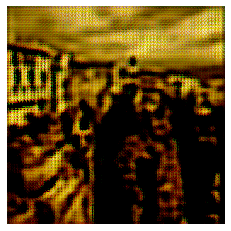

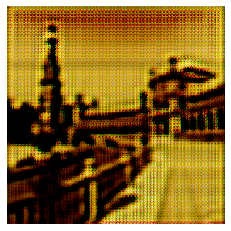

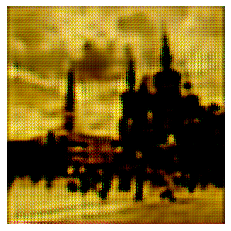

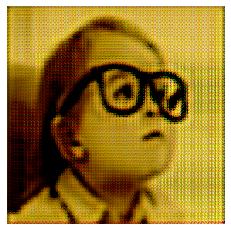

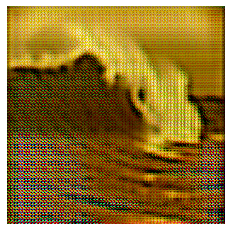

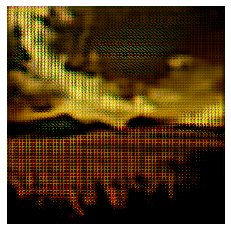

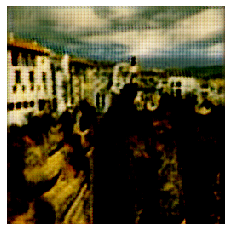

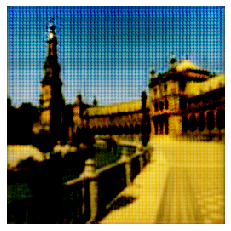

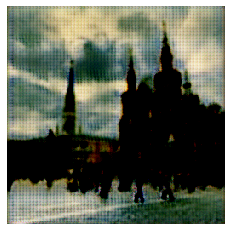

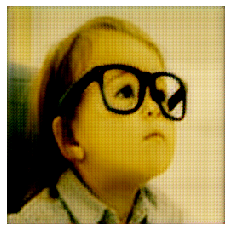

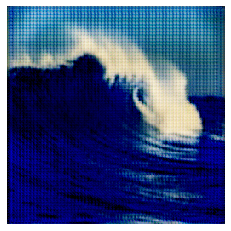

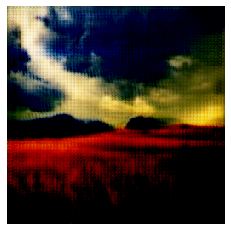

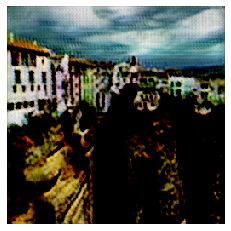

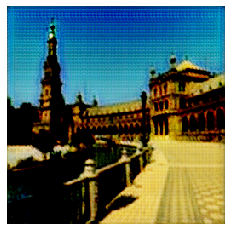

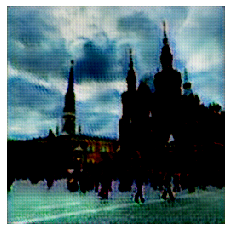

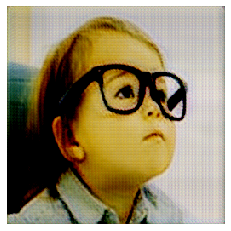

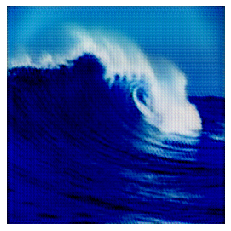

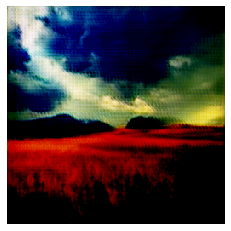

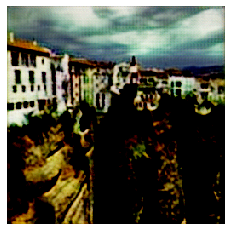

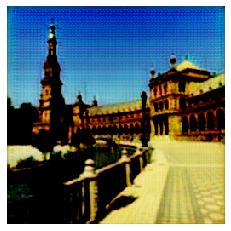

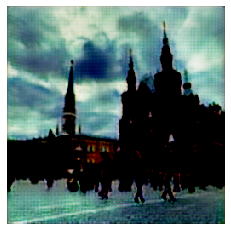

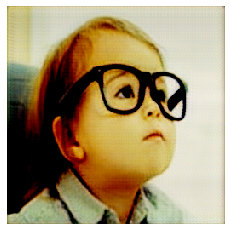

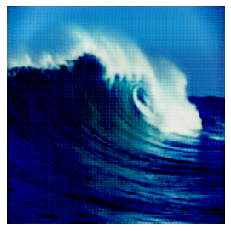

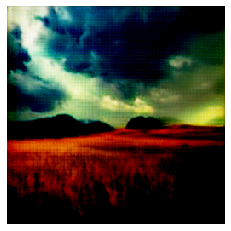

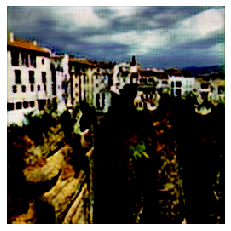

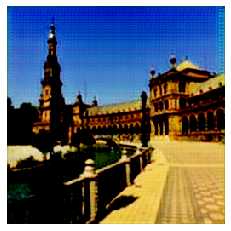

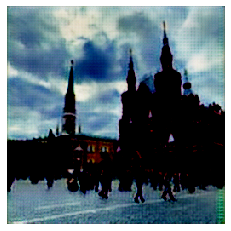

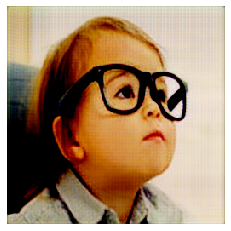

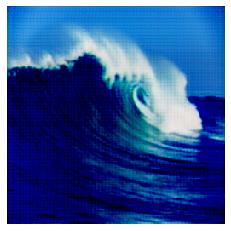

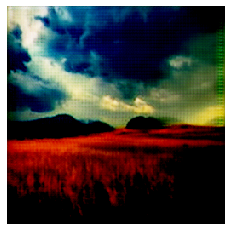

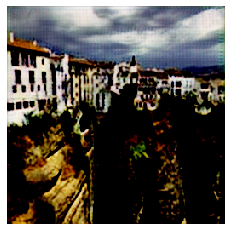

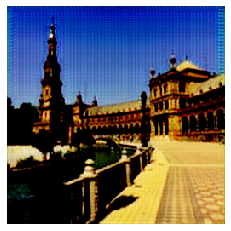

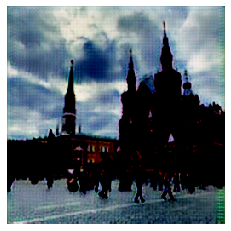

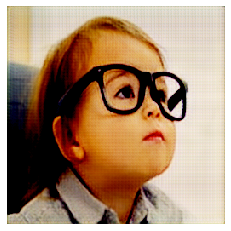

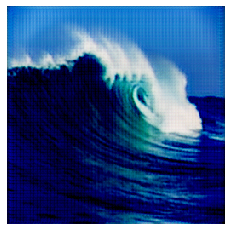

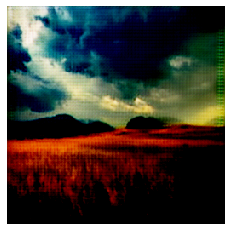

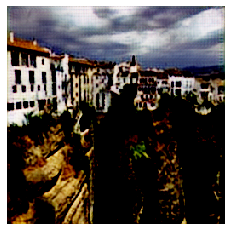

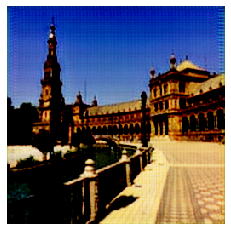

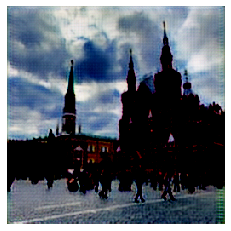

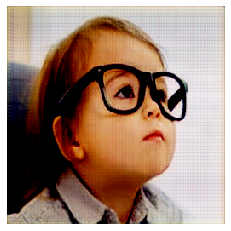

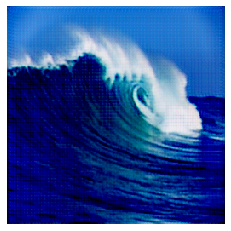

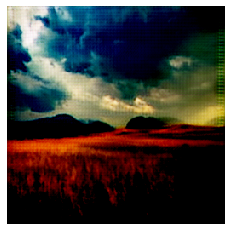

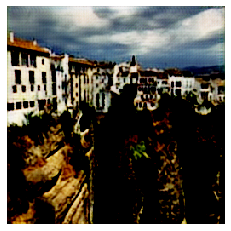

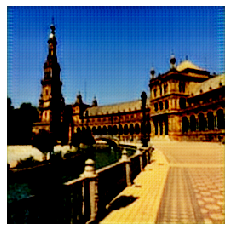

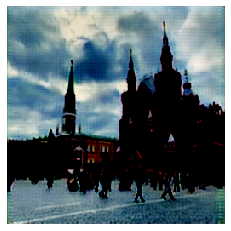

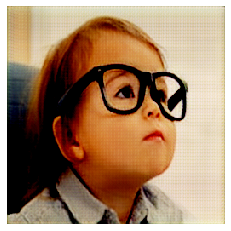

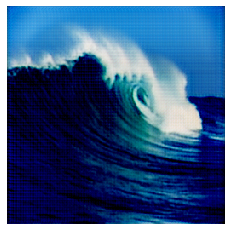

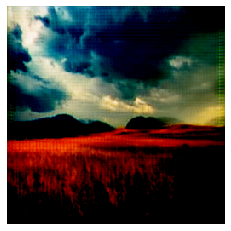

In [57]:
for epoch in range(epochs):
    print("Epoch:{}".format(epoch))

    num_batches = int(min(images_A.shape[0], images_B.shape[0]) / batch_size)
    print(images_A.shape[0])
    print("Number of batches:{}".format(num_batches))

    for index in range(num_batches):
        print("Batch:{}".format(index))

        # Get batch of images
        batch_A = images_A[index * batch_size:(index + 1) * batch_size]
        batch_B = images_B[index * batch_size:(index + 1) * batch_size]

        # Generate images from batch
        generatedB = generatorAToB.predict(batch_A)
        generatedA = generatorBToA.predict(batch_B)

        # For the Discriminator A train on batch of real images
        discriminatorA_loss_real = discriminatorA.train_on_batch(batch_A, labels_real)
        # of generated images
        discriminatorA_loss_gen = discriminatorA.train_on_batch(generatedA, labels_gen)

        # For the Discriminator B train on batch of real images
        discriminatorB_loss_real = discriminatorB.train_on_batch(batch_B, labels_real)
        # of generated images
        discriminatorB_loss_gen = discriminatorB.train_on_batch(generatedB, labels_gen)

        # Get Discriminator Loss (entire)
        discriminator_loss = 0.5 * np.add(0.5 * np.add(discriminatorA_loss_real, discriminatorA_loss_gen), 0.5 * np.add(discriminatorB_loss_real, discriminatorB_loss_gen))
        print("d_loss:{}".format(discriminator_loss))

        # Get Generator Loss (entire)
        generator_loss = model.train_on_batch([batch_A, batch_B], [labels_real, labels_real, batch_A, batch_B, batch_A, batch_B])
        print("g_loss:{}".format(generator_loss))
        

    if epoch % 5 == 0:
        # Get test images and generate
        images = load_test_images(folder)
        generated = generatorBToA.predict(images)

        # Save images
        for i in range(len(generated)):
            save_images(generated = generated[i], path = "results/vangogh_test_{}_{}".format(epoch, i))
            

In [ ]:
# Save models
generatorBToA.save_weights("generator_BA.h5")

D:\Anaconda\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
D:\Anaconda\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':
W0821 18:28:50.659326 13080 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 18:28:50.719166 13080 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 18:28:50.761054 13080 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0821 18:28:50.802941 1308

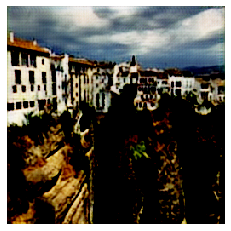

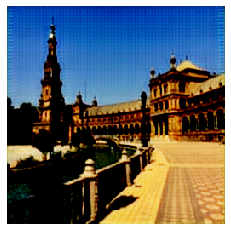

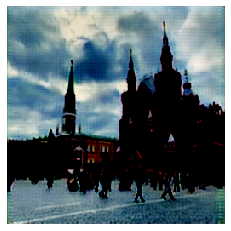

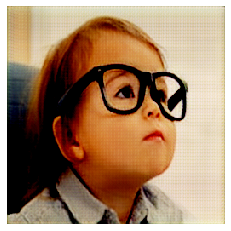

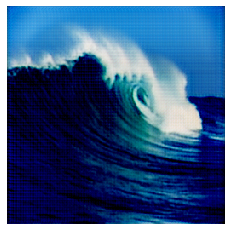

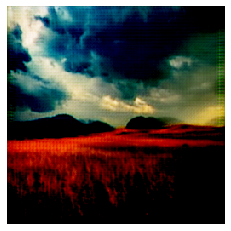

In [29]:
test_model = build_generator()
test_model.load_weights("generator_BA.h5")

images = load_test_images("../data/vangogh2photo/")
generated = test_modelmodel.predict(images)

# Save images
for i in range(len(generated)):
    save_images(generated = generated[i], path = "results/load_test_%d" % i)